<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Indices/USA500/USA500_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "USA500IDXUSD"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 11:13:18,703 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 11:13:18,704 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for USA500IDXUSD
2019-08-25 11:16:34,865 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 11:23:18,605 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 11:26:15,796 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 11:29:38,205 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 11:32:55,732 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 11:36:17,422 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 11:39:32,408 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 11:43:00,509 - findatapy.market.datavendorweb - INFO - Downloading... 2018

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-25 11:54:40,048 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_454__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_USA500IDXUSD__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-USA500IDXUSD__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-USA500IDXUSD to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open       High        Low      Close    Volume
Date                                                                     
2018-01-02 07:00:00  26.793489  26.799700  26.790991  26.795990  0.482150
2018-01-02 08:00:00  26.794701  26.794701  26.765989  26.775890  1.874790
2018-01-02 09:00:00  26.774700  26.775900  26.745890  26.753389  1.232290
2018-01-02 10:00:00  26.753389  26.783701  26.750891  26.781691  1.117820
2018-01-02 11:00:00  26.783400  26.811701  26.781691  26.808701  0.715780
...                        ...        ...        ...        ...       ...
2018-12-31 17:00:00  24.946699  25.018700  24.898701  25.008699  6.926188
2018-12-31 18:00:00  25.008699  25.086700  24.963699  24.968700  6.142362
2018-12-31 19:00:00  24.968700  25.011690  24.858700  24.941700  7.993590
2018-12-31 20:00:00  24.941700  25.070690  24.876699  25.067699  9.946327
2018-12-31 21:00:00  25.067699  25.120701  25.012699  25.075701  2.078577

[5234 rows x 5 columns]

Open         High          Low        Close       Volume
count  5234.000000  5234.000000  5234.000000  5234.000000  5234.000000
mean     27.507627    27.541725    27.469843    27.506889     3.026215
std       1.007903     0.994919     1.022745     1.008467     4.612226
min      23.264690    23.352699    23.147690    23.264700     0.000500
25%      26.897943    26.933701    26.853689    26.898468     0.716093
50%      27.437696    27.472495    27.403700    27.436695     1.563450
75%      28.174697    28.200448    28.146700    28.174193     3.497392
max      29.388700    29.408701    29.370689    29.388700   110.271423

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open       High        Low      Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08      SMA_8     TEMA_8    TRIMA_8      WMA_8     MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-05 15:00:00  27.295700  27.325701  27.287689  27.317699  0.796910    5          4          5             31    15             0               0               0                 0      1        1     1        4             3           1  27.292082  27.036203  27.267691  27.323668  27.299154  27.279832   27.297650   27.304290  27.237554  27.303570  27.316912  27.307314  27.309423  27.303570  27.312830  27.243368               27.335711                27.303570               27.271429               27.351781                27.303570               27.255358               27.367852                27.303570               27.239288               27.383922                27.303570               27.223217  27.299154  27.311975  27.253995               27.331295                27.299154               27.267013               27.347365                27.299154               27.250942               27.363436                27.299154               27.234872               27.379506   
2018-01-05 16:00:00  27.319691  27.349689  27.309690  27.337700  0.350740    5          4          5             31    16             0               0               0                 0      1        1     1        4             3           1  27.294363  27.042657  27.267691  27.333449  27.307720  27.289026   27.312345   27.308690  27.246285  27.311795  27.329138  27.312215  27.317008  27.311795  27.327700  27.251951               27.340836                27.311795               27.282753               27.355357                27.311795               27.268233               27.369877                27.311795               27.253712               27.384398                27.311795               27.239192  27.307720  27.329580  27.262189               27.336761                27.307720               27.278678               27.351281                27.307720               27.264158               27.365802                27.307720               27.249637               27.380323   
2018-01-05 17:00:00  27.334690  27.344700  27.314690  27.3

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000    5184.000000  5184.000000   5184.000000     5184.000000      5184.00000       5184.000000  5184.000000  5184.000000  5184.000000  5184.000000   5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000  5184.000000             5184.000000              5184.000000             5184.000000             5184.000000              5184.000000             5184.000000             5184.000000              5184.000000             5184.000000             5184.000000              5184.000000             5184.000000  5184.000000  5184.000000  5184.000000             5184.000000              5184.000000             5184.000000             5184.000000              5184.000000             5184.000000             5184.000000   
mean     27.511963    27.546200    27.473930    27.511137     3.016119    16.032793     2.027199   200.324846      30.487076    11.418403      0.035880        0.027585         0.00463          0.004823     7.086806     2.696181    28.964699     2.027199      2.037037    28.964699    27.512761    27.516097     2.091156    27.511116    27.512641    27.514172    27.510334    27.505405    27.497841    27.512654    27.511090    27.512651    27.512132    27.512654    27.511477    27.515666               27.617966                27.512654               27.407341               27.670623                27.512654               27.354685               27.723279                27.512654               27.302029               27.775935                27.512654               27.249372    27.512641    27.511475    27.515224               27.617954                27.512641               27.407329               27.670610                27.512641               27.354673               27.723267   
std       1.011633     0.998518     1.026677     1.012247     4.610303     8.691360     1.470736    97.689962       0.753810     6.398278      0.186008        0.163796         0.06789          0.069283     3.202743     1.047629    13.988092     1.470736      1.448511    13.988092     1.004547     0.992487    27.438688     1.013360     1.006345     1.003736     1.008263     1.009908     1.016379     1.007607     1.012960     1.008192     1.008729     1.007607     1.010871     0.998783                0.970776                 1.007607                1.052320                0.955608                 1.007607                1.077332                0.942750                 1.007607                1.103957                0.932298                 1.007607                1.132081     1.006345     1.010700     1.000087                0.969323                 1.006345                1.051242                0.954060                 1.006345                1.076344                0.941108   
min      23.264690    23.352699    23.1476

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-05 15:00:00  0.658230  0.656044  0.665274  0.661822  0.007222    5          4          5             31    15             0               0               0                 0      1        1     1        4             3           1  0.650917  0.598605  0.964583  0.664644  0.653988  0.649456    0.655400    0.658399  0.653227  0.657053  0.663927  0.658447  0.658711  0.657053  0.660479  0.638963                0.649725                 0.657053                0.667395                0.642531                 0.657053                0.680708                0.634810                 0.657053                0.696791                0.616359                 0.657053                0.711793  0.653988  0.660754  0.641685                0.648850                 0.653988                0.666957                0.641515                 0.653988                0.675863                0.633701                 0.653988                0.691665                0.625041                 0.653988   
2018-01-05 16:00:00  0.662148  0.660005  0.668809  0.665088  0.003176    5          4          5             31    16             0               0               0                 0      1        1     1        4             3           1  0.651301  0.599736  0.964583  0.666235  0.655426  0.651005    0.657845    0.659128  0.654622  0.658422  0.665919  0.659259  0.659969  0.658422  0.662923  0.640436                0.650586                 0.658422                0.669217                0.643132                 0.658422                0.682693                0.635150                 0.658422                0.698896                0.616438                 0.658422                0.713999  0.655426  0.663646  0.643085                0.649780                 0.655426                0.668836                0.642181                 0.655426                0.677931                0.634103                 0.655426                0.693857                0.625179                 0.655426   
2018-01-05 17:00:00  0.664597  0.659181  

140098

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfg_nokwz
  JVM stdout: /tmp/tmpfg_nokwz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpfg_nokwz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_t6jekr
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.537761  1.957438              0.497917  0.625727  0.391534
1  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.534961  0.729195              0.488710  0.512710  0.262872
2  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.522476  0.704812              0.489583  0.502015  0.252019
3  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.507042  0.837439              0.500000  0.546097  0.298222
4              DeepLearning_1_AutoML_20190825_120836  0.501023  0.715075              0.497917  0.505781  0.255814
5  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.500000  0.694044              0.500000  0.500416  0.250417
6  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.497917  0.691234              0.500000  0.499043  0.249043
7  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.496013  0.690705              0.490502  0.498778  0.248780
8  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.488501  0.693517              0.500000  0.500141  0.250141
9  DeepLearning_grid_1_AutoML_20190825_120836_mod...  0.487873  0.720568              0.497917  0.512288  0.262439

variable  relative_importance  scaled_importance  percentage
0               CDLMATCHINGLOW             1.000000           1.000000    0.004064
1            CDLINVERTEDHAMMER             0.926072           0.926072    0.003763
2          CDLGAPSIDESIDEWHITE             0.911826           0.911826    0.003705
3                 is_month_end             0.911146           0.911146    0.003703
4              CDLADVANCEBLOCK             0.889247           0.889247    0.003614
...                        ...                  ...                ...         ...
1033  BBANDS_middleband_12_4_3             0.186213           0.186213    0.000757
1034             MINMAX_min_12             0.185461           0.185461    0.000754
1035                  MEDPRICE             0.184428           0.184428    0.000749
1036                       SIN             0.184157           0.184157    0.000748
1037                 MAVP_12_5             0.183254           0.183254    0.000745

[1038 rows x 4 columns]

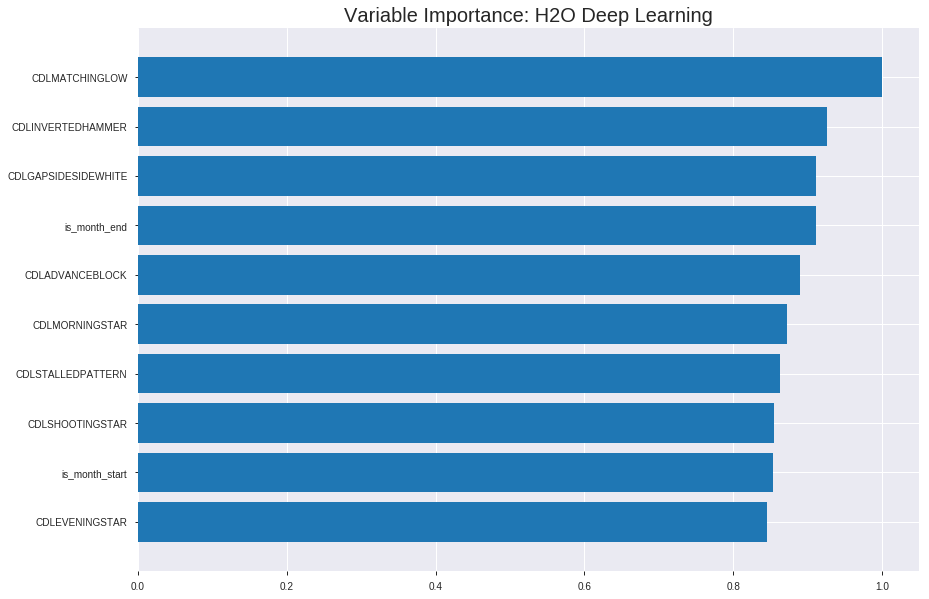

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_120836_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2941199686280348
RMSE: 0.5423282849234722
LogLoss: 0.9040100608858094
Mean Per-Class Error: 0.4069934995046136
AUC: 0.6035406381749258
pr_auc: 0.6291338033985268
Gini: 0.20708127634985152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0059652415775656355: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      26   1660  0.9846   (1660.0/1686.0)
1      6    1936  0.0031   (6.0/1942.0)
Total  32   3596  0.4592   (1666.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00596524   0.699169  396
max f2                       0.00260596   0.852373  398
max f0point5                 0.55107      0.614088  180
max accuracy                 0.55107      0.588479  180
max precision                0.990886     0.863636  3
max recall                   0.00081635   1         399
max specificity              0.999476     0.999407  0
max absolute_mcc             0.55107      0.186793  180
max min_per_class_accuracy   0.47559      0.580071  209
max mean_per_class_accuracy  0.55107      0.593007  180

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 46.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.984935           1.46425   1.46425            0.783784         0.992275   0.783784                    0.992275            0.0149331       0.0149331                  46.4247   46.4247
    2        0.0201213                   0.974116           1.50492   1.48431            0.805556         0.980626   0.794521                    0.98653             0.0149331       0.0298661                  50.492    48.4305
    3        0.0300441                   0.964369           1.24545   1.40542            0.666667         0.969499   0.752294                    0.980905            0.0123584       0.0422245                  24.5451   40.5418
    4        0.0402426                   0.953828           1.31277   1.38194            0.702703         0.959024   0.739726                    0.97536             0.0133883       0.0556128                  31.2773   38.1939
    5        0.0501654                   0.942149           1.29735   1.36521            0.694444         0.948617   0.730769                    0.97007             0.0128733       0.0684861                  29.7345   36.5206
    6        0.100055                    0.895482           1.24889   1.30721            0.668508         0.919111   0.699725                    0.944661            0.0623069       0.130793                   24.8892   30.7209
    7        0.150221                    0.848505           1.23177   1.28202            0.659341         0.871968   0.686239                    0.920385            0.061792        0.192585                   23.1765   28.2015
    8        0.20011                     0.795885           1.156     1.2506             0.618785         0.821007   0.669421                    0.895609            0.0576725       0.250257                   15.5999   25.0598
    9        0.300165                    0.692696           1.15796   1.21972            0.619835         0.743045   0.652893                    0.844754            0.11586         0.366117                   15.7961   21.9719
    10       0.399945                    0.592427           1.11471   1.19352            0.596685         0.642925   0.63887                     0.794401            0.111226        0.477343                   11.4713   19.3522
    11       0.5                         0.481082           0.972687  1.14933            0.520661         0.538754   0.615215                    0.743244            0.0973223       0.574665                   -2.73127  14.9331
    12       0.600055                    0.346251           0.900636  1.10786            0.482094         0.412841   0.593018                    0.688151            0.0901133       0.664779                   -9.93636  10.7863
    13       0.699835                    0.227372           0.805071  1.06469            0.430939         0.286098   0.569909                    0.630828            0.0803296       0.745108                   -19.4929  6.46917
    14       0.79989                     0.123671           0.88005   1.0416             0.471074         0.173523   0.557547                    0.573626            0.0880536       0.833162                   -11.995   4.15957
    15       0.899945                    0.0444614          0.916076  1.02764            0.490358         0.0833658  0.550077                    0.519119            0.0916581       0.92482                    -8.39242  2.76405
    16       1                           2.80691e-05        0.751388  1                  0.402204         0.0215942  0.535281                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3687398285161549
RMSE: 0.6072395149495419
LogLoss: 1.209619306290659
Mean Per-Class Error: 0.4780179615705932
AUC: 0.5227093030194534
pr_auc: 0.540093323263734
Gini: 0.045418606038906795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0021955407166701214: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    500   0.9921   (500.0/504.0)
1      2    530   0.0038   (2.0/532.0)
Total  6    1030  0.4846   (502.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00219554   0.678617   398
max f2                       0.000504358  0.840708   399
max f0point5                 0.0150263    0.574324   387
max accuracy                 0.022969     0.528958   380
max precision                0.999573     1          0
max recall                   0.000504358  1          399
max specificity              0.999573     1          0
max absolute_mcc             0.0150263    0.0691436  387
max min_per_class_accuracy   0.551396     0.507937   199
max mean_per_class_accuracy  0.651213     0.521982   164

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 49.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0106178                   0.986593           1.41627   1.41627            0.727273         0.992133   0.727273                    0.992133            0.0150376       0.0150376                  41.6268    41.6268
    2        0.0202703                   0.981093           1.36316   1.39098            0.7              0.983517   0.714286                    0.98803             0.0131579       0.0281955                  36.3158    39.0977
    3        0.030888                    0.977547           1.0622    1.27796            0.545455         0.979267   0.65625                     0.985018            0.0112782       0.0394737                  6.2201     27.7961
    4        0.0405405                   0.974213           1.36316   1.29825            0.7              0.975627   0.666667                    0.982782            0.0131579       0.0526316                  36.3158    29.8246
    5        0.0501931                   0.969129           0.778947  1.19838            0.4              0.972495   0.615385                    0.980804            0.0075188       0.0601504                  -22.1053   19.8381
    6        0.100386                    0.955048           1.01113   1.10476            0.519231         0.962744   0.567308                    0.971774            0.0507519       0.110902                   1.11336    10.4757
    7        0.150579                    0.930161           1.01113   1.07355            0.519231         0.943176   0.551282                    0.962241            0.0507519       0.161654                   1.11336    7.35493
    8        0.200772                    0.891854           0.973684  1.04858            0.5              0.910736   0.538462                    0.949365            0.0488722       0.210526                   -2.63158   4.8583
    9        0.300193                    0.799973           1.02095   1.03943            0.524272         0.843855   0.533762                    0.914421            0.101504        0.31203                    2.09504    3.94314
    10       0.400579                    0.686445           1.06731   1.04642            0.548077         0.742293   0.537349                    0.871285            0.107143        0.419173                   6.73077    4.64172
    11       0.5                         0.551171           0.907511  1.0188             0.466019         0.623877   0.523166                    0.82209             0.0902256       0.509398                   -9.24885   1.8797
    12       0.600386                    0.354599           0.992409  1.01438            0.509615         0.452495   0.5209                      0.760293            0.0996241       0.609023                   -0.759109  1.43848
    13       0.699807                    0.1435             1.03986   1.018              0.533981         0.239466   0.522759                    0.6863              0.103383        0.712406                   3.98569    1.80036
    14       0.800193                    0.0537995          0.95496   1.01009            0.490385         0.0912509  0.518697                    0.611649            0.0958647       0.808271                   -4.50405   1.00946
    15       0.899614                    0.02365            1.05876   1.01547            0.543689         0.0358429  0.521459                    0.548014            0.105263        0.913534                   5.87634    1.54732
    16       1                           4.20757e-05        0.861336  1                  0.442308         0.0133323  0.513514    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:08:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:08:46  6.161 sec         183 obs/sec       0.130926  1             475        0.668644         5.13329             -0.797288      0.519122        0.522124           1.06032          0.464719                         0.662358           5.72535               -0.756153        0.528244          0.525497             1.23923            0.486486
    2019-08-25 12:09:20  39.576 sec        210 obs/sec       1.90656   14            6917       0.671819         4.82271             -0.814396      0.525261        0.371062           1.46425          0.464719                         0.678436           5.65971               -0.84245         0.527258          0.387165             0.708134           0.486486
    2019-08-25 12:09:52  1 min 12.186 sec  215 obs/sec       3.69184   27            13394      0.6618           4.50597             -0.760682      0.549733        0.562883           1.41376          0.464719                         0.672375           5.25017               -0.809676        0.503495          0.478682             0.885167           0.486486
    2019-08-25 12:10:26  1 min 45.584 sec  217 obs/sec       5.54989   41            20135      0.602138         2.14376             -0.457539      0.581094        0.45848            1.36326          0.444598                         0.677896           3.53638               -0.839515        0.497731          0.409846             0.708134           0.484556
    2019-08-25 12:10:59  2 min 18.948 sec  220 obs/sec       7.44405   55            27007      0.598155         2.17454             -0.438317      0.578179        0.456792           1.1613           0.455899                         0.660486           3.08232               -0.746242        0.495677          0.414166             0.708134           0.486486
    2019-08-25 12:11:31  2 min 51.211 sec  221 obs/sec       9.29245   69            33713      0.57671          1.3392              -0.337033      0.589092        0.591423           1.46425          0.464719                         0.646826           2.07985               -0.674757        0.498868          0.49627              0.5311             0.486486
    2019-08-25 12:12:02  3 min 21.927 sec  223 obs/sec       11.0733   82            40174      0.610523         1.75356             -0.498413      0.588868        0.621986           1.56523          0.464719                         0.647113           2.13148               -0.676243        0.5083            0.501487             1.23923            0.486486
    2019-08-25 12:12:35  3 min 54.724 sec  224 obs/sec       12.9628   96            47029      0.582839         1.34295             -0.365605      0.613906        0.65317            1.61572          0.464719                         0.633622           1.74603               -0.607079        0.498501          0.505083             1.41627            0.486486
    2019-08-25 12:13:07

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLMATCHINGLOW            1.0                    1.0                  0.004063687204517961
CDLINVERTEDHAMMER         0.9260716438293457     0.9260716438293457   0.0037632654894962266
CDLGAPSIDESIDEWHITE       0.9118255376815796     0.9118255376815796   0.003705373770229345
is_month_end              0.911145806312561      0.911145806312561    0.0037026115545625545
CDLADVANCEBLOCK           0.8892470598220825     0.8892470598220825   0.0036136218986542144
---                       ---                    ---                  ---
BBANDS_middleband_12_4_3  0.1862131506204605     0.1862131506204605   0.0007567119974893412
MINMAX_min_12             0.18546076118946075    0.18546076118946075  0.0007536545221857729
MEDPRICE                  0.18442797660827637    0.18442797660827637  0.0007494576086981905
SIN                       0.18415722250938416    0.18415722250938416  0.0007483573487309514
MAVP_12_5                 0.18325373530387878    0.18325373530387878  0.0007446858593344936


See the whole table with table.as_data_frame()


('accuracy', 0.5606936416184971)

('F1', 0.7001254705144292)

('auc', 0.5377613500597371)

('logloss', 1.9574378156248522)

('mean_per_class_error', 0.45620519713261654)

('rmse', 0.6257267341880189)

('mse', 0.39153394587760376)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


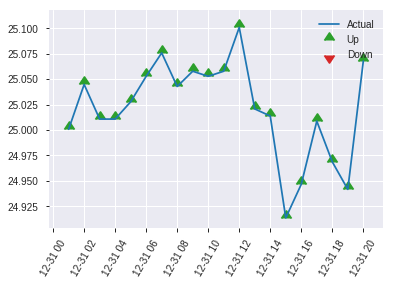


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.39153394587760376
RMSE: 0.6257267341880189
LogLoss: 1.9574378156248522
Mean Per-Class Error: 0.45620519713261654
AUC: 0.5377613500597371
pr_auc: 0.5509664540097424
Gini: 0.07552270011947426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.028591530292382584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    239  0.9958   (239.0/240.0)
1      0    279  0        (0.0/279.0)
Total  1    518  0.4605   (239.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0285915    0.700125   398
max f2                       0.0285915    0.853733   398
max f0point5                 0.624583     0.601699   340
max accuracy                 0.772769     0.560694   309
max precision                0.999985     0.714286   0
max recall                   0.0285915    1          398
max specificity              0.999985     0.991667   0
max absolute_mcc             0.767087     0.0958428  311
max min_per_class_accuracy   0.974428     0.523297   148
max mean_per_class_accuracy  0.934109     0.543795   219

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 87.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.99998            1.24014   1.24014            0.666667         0.999986  0.666667                    0.999986            0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.999963           1.11613   1.18377            0.6              0.999971  0.636364                    0.999979            0.0107527       0.0250896                  11.6129   18.3773
    3        0.0308285                   0.999944           1.48817   1.2789             0.8              0.999951  0.6875                      0.999971            0.0143369       0.0394265                  48.8172   27.8898
    4        0.0404624                   0.999914           0.372043  1.06298            0.2              0.99993   0.571429                    0.999961            0.00358423      0.0430108                  -62.7957  6.298
    5        0.0500963                   0.999889           1.48817   1.14475            0.8              0.9999    0.615385                    0.999949            0.0143369       0.0573477                  48.8172   14.4748
    6        0.100193                    0.99969            0.858561  1.00165            0.461538         0.999797  0.538462                    0.999873            0.0430108       0.100358                   -14.1439  0.165426
    7        0.150289                    0.999446           1.14475   1.04935            0.615385         0.999578  0.564103                    0.999775            0.0573477       0.157706                   14.4748   4.93521
    8        0.200385                    0.999134           0.930108  1.01954            0.5              0.999311  0.548077                    0.999659            0.046595        0.204301                   -6.98925  1.95409
    9        0.300578                    0.996671           1.03743   1.0255             0.557692         0.998175  0.551282                    0.999164            0.103943        0.308244                   3.74276   2.55032
    10       0.400771                    0.9892             1.14475   1.05531            0.615385         0.993695  0.567308                    0.997797            0.114695        0.422939                   14.4748   5.53143
    11       0.500963                    0.974427           1.00165   1.04458            0.538462         0.981751  0.561538                    0.994588            0.100358        0.523297                   0.165426  4.45823
    12       0.599229                    0.953936           0.98482   1.03478            0.529412         0.963913  0.55627                     0.989558            0.0967742       0.620072                   -1.51803  3.4782
    13       0.699422                    0.907683           1.0732    1.04029            0.576923         0.934058  0.559229                    0.981607            0.107527        0.727599                   7.3201    4.02856
    14       0.799615                    0.810385           1.03743   1.03993            0.557692         0.85535   0.559036                    0.965787            0.103943        0.831541                   3.74276   3.99275
    15       0.899807                    0.594409           0.894334  1.02372            0.480769         0.719575  0.550321                    0.938372            0.0896057       0.921147                   -10.5666  2.37158
    16       1                           0.00345047         0.787014  1                  0.423077         0.336637  0.537572                    0.878082           

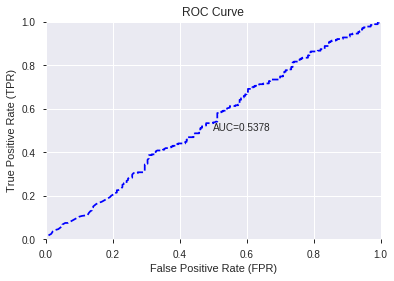

This function is available for GLM models only


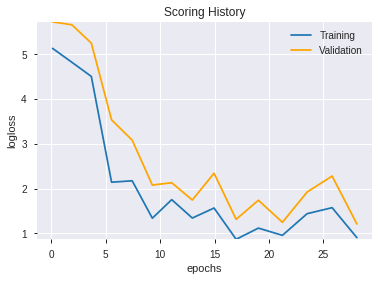

--2019-08-25 13:09:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  68.0MB/s    in 5.2s    

2019-08-25 13:09:05 (67.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_120836_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_120836_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_131000_model_5  0.523178  0.692524              0.495833  0.499664  0.249664
1  DeepLearning_grid_1_AutoML_20190825_131000_model_3  0.515300  0.728439              0.470587  0.512492  0.262648
2  DeepLearning_grid_1_AutoML_20190825_131000_model_9  0.500000  0.692618              0.500000  0.499735  0.249735
3  DeepLearning_grid_1_AutoML_20190825_131000_model_7  0.494556  0.791103              0.497917  0.532487  0.283543
4  DeepLearning_grid_1_AutoML_20190825_131000_model_8  0.494534  0.691173              0.500000  0.499008  0.249009
5  DeepLearning_grid_1_AutoML_20190825_131000_model_1  0.494026  1.226672              0.500000  0.598872  0.358648
6               DeepLearning_1_AutoML_20190825_131000  0.488964  0.720157              0.500000  0.510552  0.260663
7  DeepLearning_grid_1_AutoML_20190825_131000_model_4  0.484386  0.719983              0.500000  0.511569  0.261703
8  DeepLearning_grid_1_AutoML_20190825_131000_model_6  0.468765  0.696320              0.491084  0.501424  0.251426
9  DeepLearning_grid_1_AutoML_20190825_131000_model_2  0.449403  0.781649              0.500000  0.530680  0.281621

variable  relative_importance  scaled_importance  percentage
0              CDLTHRUSTING             1.000000           1.000000    0.022243
1                    VAR_12             0.992374           0.992374    0.022074
2                 STDDEV_14             0.985608           0.985608    0.021923
3              CDLTASUKIGAP             0.978999           0.978999    0.021776
4                    VAR_20             0.975079           0.975079    0.021689
5         CDLSTALLEDPATTERN             0.967511           0.967511    0.021521
6            CDLEVENINGSTAR             0.962985           0.962985    0.021420
7                 CDLONNECK             0.957444           0.957444    0.021297
8            CDLMATCHINGLOW             0.957060           0.957060    0.021288
9                 CDLHARAMI             0.955299           0.955299    0.021249
10                   VAR_30             0.940383           0.940383    0.020917
11         is_quarter_start             0.936776           0.936776    0.020837
12                   VAR_14             0.934712           0.934712    0.020791
13                   Volume             0.927924           0.927924    0.020640
14      CDLGAPSIDESIDEWHITE             0.919100           0.919100    0.020444
15       CDLIDENTICAL3CROWS             0.916109           0.916109    0.020377
16           CDL3LINESTRIKE             0.915355           0.915355    0.020361
17         CDLSTICKSANDWICH             0.914892           0.914892    0.020350
18          CDLHOMINGPIGEON             0.914440           0.914440    0.020340
19              CDLPIERCING             0.912576           0.912576    0.020299
20          CDLUNIQUE3RIVER             0.912451           0.912451    0.020296
21                CORREL_30             0.905893           0.905893    0.020150
22          CDLSHOOTINGSTAR             0.902519           0.902519    0.020075
23                  CDLDOJI             0.897992           0.897992    0.019974
24                   VAR_24             0.897699           0.897699    0.019968
25       CDLMORNINGDOJISTAR             0.893471           0.893471    0.019874
26           is_month_start             0.891280           0.891280    0.019825
27                   TRANGE             0.887941           0.887941    0.019751
28                    VAR_8             0.884929           0.884929    0.019684
29       CDLEVENINGDOJISTAR             0.884693           0.884693    0.019679
30       CDLSEPARATINGLINES             0.881918           0.881918    0.019617
31                      DIV             0.878764           0.878764    0.019547
32           CDLRICKSHAWMAN             0.875458           0.875458    0.019473
33        CDLINVERTEDHAMMER             0.874177           0.874177    0.019445
34                CDLTAKURI             0.871986           0.871986    0.019396
35              CDLDOJISTAR             0.870919           0.870919    0.019372
36        CDLLONGLEGGEDDOJI             0.868908           0.868908    0.019327
37  BBANDS_upperband_30_6_5             0.865173           0.865173    0.019244
38         CDLDRAGONFLYDOJI             0.858312           0.858312    0.019092
39                      SUB             0.856677           0.856677    0.019055
40        CDL3WHITESOLDIERS             0.855630           0.855630    0.019032
41            CDLHANGINGMAN             0.853651           0.853651    0.018988
42        CDLGRAVESTONEDOJI             0.848117           0.848117    0.018865
43           CDL3BLACKCROWS             0.845706           0.845706    0.018811
44                CDLHAMMER             0.843904           0.843904    0.018771
45        CDLDARKCLOUDCOVER             0.833175           0.833175    0.018533
46             is_month_end             0.831611           0.831611    0.018498
47               CDL3INSIDE             0.825298           0.825298    0.018357
48          CDLADVANCEBLOCK             0.814081           0.814081    0.018108
49           CDLMOR

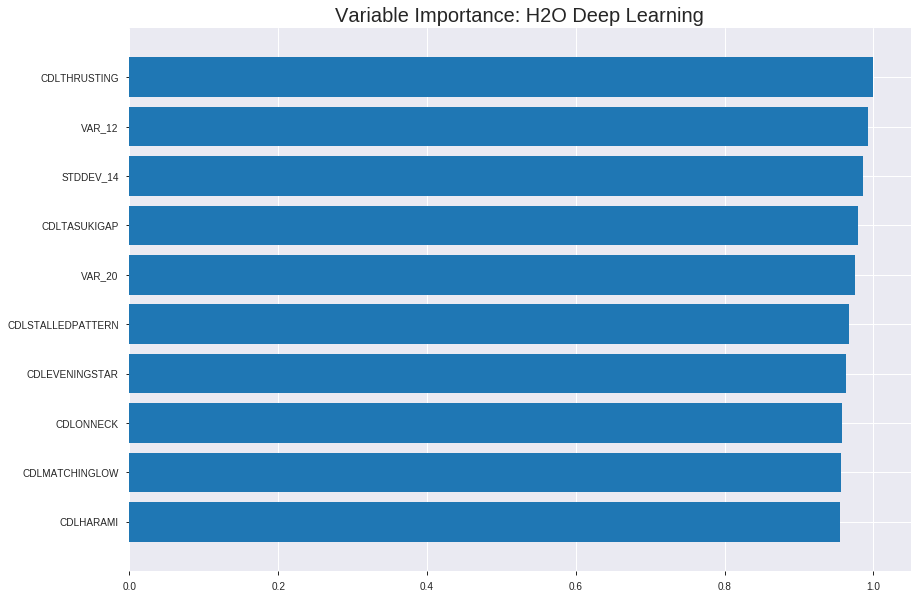

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_131000_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2495251169935835
RMSE: 0.4995248912652737
LogLoss: 0.6921569361836418
Mean Per-Class Error: 0.4772549853216591
AUC: 0.5229444519780637
pr_auc: 0.5568062618178607
Gini: 0.045888903956127436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41890359461947524: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      25   1661  0.9852   (1661.0/1686.0)
1      10   1932  0.0051   (10.0/1942.0)
Total  35   3593  0.4606   (1671.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.418904     0.698103   376
max f2                       0.361099     0.852353   395
max f0point5                 0.418904     0.592129   376
max accuracy                 0.418904     0.539416   376
max precision                0.789306     1          0
max recall                   0.361099     1          395
max specificity              0.789306     1          0
max absolute_mcc             0.553304     0.0521337  103
max min_per_class_accuracy   0.497556     0.520166   220
max mean_per_class_accuracy  0.504498     0.522745   199

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.61444            1.00983   1.00983            0.540541         0.660048  0.540541                    0.660048            0.0102987       0.0102987                  0.982548  0.982548
    2        0.0201213                   0.605471           0.934089  0.972476           0.5              0.609842  0.520548                    0.635289            0.0092688       0.0195675                  -6.59114  -2.75242
    3        0.0300441                   0.598221           1.34924   1.09691            0.722222         0.601672  0.587156                    0.624186            0.0133883       0.0329557                  34.9239   9.69113
    4        0.0402426                   0.592924           1.21179   1.12602            0.648649         0.595303  0.60274                     0.616866            0.0123584       0.0453141                  21.1791   12.6025
    5        0.0501654                   0.588344           1.14166   1.12912            0.611111         0.590387  0.604396                    0.611629            0.0113285       0.0566426                  14.1664   12.9118
    6        0.100055                    0.5619             1.11471   1.12194            0.596685         0.576793  0.600551                    0.594259            0.0556128       0.112255                   11.4713   12.1936
    7        0.150221                    0.539165           0.954618  1.06606            0.510989         0.549204  0.570642                    0.579213            0.0478888       0.160144                   -4.5382   6.60607
    8        0.20011                     0.522041           1.07343   1.0679             0.574586         0.530172  0.571625                    0.566986            0.053553        0.213697                   7.34277   6.78974
    9        0.300165                    0.511443           0.936662  1.02415            0.501377         0.516031  0.548209                    0.550001            0.0937178       0.307415                   -6.33382  2.41522
    10       0.399945                    0.504222           1.1302    1.05061            0.604972         0.508077  0.562371                    0.539542            0.11277         0.420185                   13.0196   5.06082
    11       0.5                         0.497522           0.98298   1.03708            0.526171         0.500815  0.555127                    0.531792            0.0983522       0.518538                   -1.70197  3.70752
    12       0.600055                    0.490205           0.957248  1.02376            0.512397         0.493652  0.548002                    0.525433            0.0957775       0.614315                   -4.27522  2.37645
    13       0.699835                    0.482146           0.980535  1.0176             0.524862         0.48611   0.544703                    0.519826            0.0978373       0.712152                   -1.9465   1.7601
    14       0.79989                     0.473273           0.957248  1.01005            0.512397         0.477677  0.540662                    0.514554            0.0957775       0.80793                    -4.27522  1.00517
    15       0.899945                    0.46028            0.988127  1.00761            0.528926         0.467437  0.539357                    0.509316            0.0988671       0.906797                   -1.18732  0.761407
    16       1                           0.290768           0.931515  1                  0.498623         0.442254  0.535281                    0.502606       



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2527231789506602
RMSE: 0.502715803362755
LogLoss: 0.6986800959953534
Mean Per-Class Error: 0.48329156223893066
AUC: 0.5023925140231531
pr_auc: 0.5031888804654634
Gini: 0.004785028046306206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4206234608004546: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   492   0.9762   (492.0/504.0)
1      5    527   0.0094   (5.0/532.0)
Total  17   1019  0.4797   (497.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.420623     0.679562   385
max f2                       0.381288     0.840974   398
max f0point5                 0.431704     0.572687   372
max accuracy                 0.447146     0.527027   334
max precision                0.604593     0.571429   18
max recall                   0.381288     1          398
max specificity              0.713468     0.998016   0
max absolute_mcc             0.58154      0.0655606  32
max min_per_class_accuracy   0.482734     0.507937   223
max mean_per_class_accuracy  0.447146     0.516708   334

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.620017           0.885167  0.885167           0.454545         0.657945  0.454545                    0.657945            0.0093985       0.0093985                  -11.4833  -11.4833
    2        0.0202703                   0.603701           1.36316   1.11278            0.7              0.610901  0.571429                    0.635543            0.0131579       0.0225564                  36.3158   11.2782
    3        0.030888                    0.588633           0.354067  0.851974           0.181818         0.597827  0.4375                      0.622578            0.0037594       0.0263158                  -64.5933  -14.8026
    4        0.0405405                   0.580972           0.194737  0.695489           0.1              0.582788  0.357143                    0.613104            0.0018797       0.0281955                  -80.5263  -30.4511
    5        0.0501931                   0.576223           1.16842   0.786437           0.6              0.578542  0.403846                    0.606458            0.0112782       0.0394737                  16.8421   -21.3563
    6        0.100386                    0.557312           0.861336  0.823887           0.442308         0.568406  0.423077                    0.587432            0.0432331       0.0827068                  -13.8664  -17.6113
    7        0.150579                    0.530237           1.16093   0.936235           0.596154         0.542907  0.480769                    0.57259             0.0582707       0.140977                   16.0931   -6.37652
    8        0.200772                    0.519897           1.04858   0.964322           0.538462         0.523999  0.495192                    0.560442            0.0526316       0.193609                   4.8583    -3.56781
    9        0.300193                    0.500695           0.945324  0.95803            0.485437         0.509682  0.491961                    0.543631            0.093985        0.287594                   -5.46755  -4.19699
    10       0.400579                    0.490983           1.23583   1.02765            0.634615         0.495574  0.527711                    0.531588            0.12406         0.411654                   23.583    2.76474
    11       0.5                         0.482704           0.983137  1.0188             0.504854         0.486713  0.523166                    0.522665            0.0977444       0.509398                   -1.68625  1.8797
    12       0.600386                    0.474405           0.973684  1.01125            0.5              0.478411  0.519293                    0.515266            0.0977444       0.607143                   -2.63158  1.1254
    13       0.699807                    0.466965           0.983137  1.00726            0.504854         0.471013  0.517241                    0.508979            0.0977444       0.704887                   -1.68625  0.725953
    14       0.800193                    0.456749           0.973684  1.00305            0.5              0.462001  0.515078                    0.503085            0.0977444       0.802632                   -2.63158  0.304743
    15       0.899614                    0.444449           1.09658   1.01338            0.563107         0.451028  0.520386                    0.497332            0.109023        0.911654                   9.65764   1.33838
    16       1                           0.289395           0.880061  1                  0.451923         0.43045   0.513514                    0.490618 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:15:58  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:16:00  3 min 26.304 sec  950 obs/sec       0.581312  1             2109       0.499525         0.692157            -0.00309491    0.522944        0.556806           1.00983          0.460584                         0.502716           0.69868               -0.0116317       0.502393          0.503189             0.885167           0.47973
    2019-08-25 13:16:18  3 min 43.760 sec  2112 obs/sec      10.4686   18            37980      0.498889         0.690398            -0.000540961   0.550697        0.587473           1.61572          0.45011                          0.503515           0.700966              -0.0148516       0.493831          0.502792             1.23923            0.486486
    2019-08-25 13:16:35  4 min  1.027 sec  2392 obs/sec      22.1075   38            80206      0.498847         0.689817            -0.000372759   0.576495        0.618533           1.66621          0.4457                           0.517508           0.734178              -0.0720429       0.484088          0.500311             1.0622             0.485521
    2019-08-25 13:16:53  4 min 18.755 sec  2555 obs/sec      34.9192   60            126687     0.494323         0.679821            0.0176875      0.581484        0.638239           1.7167           0.432194                         0.512806           0.723819              -0.052648        0.494294          0.506452             1.41627            0.483591
    2019-08-25 13:17:10  4 min 35.962 sec  2725 obs/sec      48.8707   84            177303     0.487977         0.666226            0.0427462      0.596953        0.65586            1.86818          0.427233                         0.509883           0.718774              -0.0406813       0.482089          0.502819             1.5933             0.483591
    2019-08-25 13:17:27  4 min 53.491 sec  2845 obs/sec      63.4256   109           230108     0.485498         0.659357            0.0524507      0.604287        0.669349           1.86818          0.425579                         0.514044           0.732944              -0.0577375       0.487786          0.498149             1.23923            0.486486
    2019-08-25 13:17:29  4 min 55.189 sec  2844 obs/sec      63.4256   109           230108     0.499525         0.692157            -0.00309491    0.522944        0.556806           1.00983          0.460584                         0.502716           0.69868               -0.0116317       0.502393          0.503189             0.885167           0.47973

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLTHRUSTING       1.0                    1.0                  0.022243326306789237
VAR_12             0.992373526096344      0.992373526096344    0.022073688159180004
STDDEV_14          0.985607922077179      0.985607922077179    0.02192319862131919
CDLTASUKIGAP       0.9789986610412598     0.9789986610412598   0.021776186671450492
VAR_20             0.9750787615776062     0.9750787615776062   0.021688995068590636
---                ---                    ---                  ---
CDLDARKCLOUDCOVER  0.8331748247146606     0.8331748247146606   0.018532579496730123
is_month_end       0.8316113352775574     0.8316113352775574   0.018497802291003416
CDL3INSIDE         0.8252983093261719     0.8252983093261719   0.018357379594783518
CDLADVANCEBLOCK    0.8140811920166016     0.8140811920166016   0.018107873594245212
CDLMORNINGSTAR     0.7803471088409424     0.7803471088409424   0.017357515374508657


See the whole table with table.as_data_frame()


('accuracy', 0.5529865125240848)

('F1', 0.7010050251256281)

('auc', 0.5231780167264038)

('logloss', 0.6925236039675634)

('mean_per_class_error', 0.46265681003584225)

('rmse', 0.49966410788705223)

('mse', 0.2496642207105638)

deeplearning prediction progress: |███████████████████████████████████████| 100%


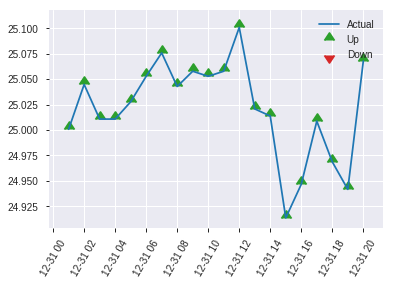


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2496642207105638
RMSE: 0.49966410788705223
LogLoss: 0.6925236039675634
Mean Per-Class Error: 0.46265681003584225
AUC: 0.5231780167264038
pr_auc: 0.5528648686756451
Gini: 0.0463560334528077
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43030958006428743: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    238  0.9917   (238.0/240.0)
1      0    279  0        (0.0/279.0)
Total  2    517  0.4586   (238.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.43031      0.701005   397
max f2                       0.43031      0.854256   397
max f0point5                 0.43031      0.594376   397
max accuracy                 0.488429     0.552987   278
max precision                0.687463     1          0
max recall                   0.43031      1          397
max specificity              0.687463     1          0
max absolute_mcc             0.488429     0.0821467  278
max min_per_class_accuracy   0.513372     0.512545   200
max mean_per_class_accuracy  0.488429     0.537343   278

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 51.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.662087           0.930108  0.930108           0.5              0.677695  0.5                         0.677695            0.0107527       0.0107527                  -6.98925  -6.98925
    2        0.0211946                   0.610489           0.372043  0.676442           0.2              0.624504  0.363636                    0.653517            0.00358423      0.0143369                  -62.7957  -32.3558
    3        0.0308285                   0.603959           1.48817   0.930108           0.8              0.607164  0.5                         0.639032            0.0143369       0.0286738                  48.8172   -6.98925
    4        0.0404624                   0.599323           0.744086  0.885817           0.4              0.601144  0.47619                     0.630011            0.00716846      0.0358423                  -25.5914  -11.4183
    5        0.0500963                   0.596299           1.86022   1.0732             1                0.598333  0.576923                    0.623919            0.0179211       0.0537634                  86.0215   7.3201
    6        0.100193                    0.581221           1.00165   1.03743            0.538462         0.588993  0.557692                    0.606456            0.0501792       0.103943                   0.165426  3.74276
    7        0.150289                    0.570432           1.00165   1.0255             0.538462         0.575612  0.551282                    0.596175            0.0501792       0.154122                   0.165426  2.55032
    8        0.200385                    0.554354           1.0732    1.03743            0.576923         0.562257  0.557692                    0.587695            0.0537634       0.207885                   7.3201    3.74276
    9        0.300578                    0.530956           1.00165   1.0255             0.538462         0.54257   0.551282                    0.572654            0.100358        0.308244                   0.165426  2.55032
    10       0.400771                    0.519931           0.965881  1.0106             0.519231         0.524925  0.543269                    0.560722            0.0967742       0.405018                   -3.41191  1.05976
    11       0.500963                    0.513134           1.0732    1.02312            0.576923         0.517109  0.55                        0.551999            0.107527        0.512545                   7.3201    2.31183
    12       0.599229                    0.501461           1.13072   1.04076            0.607843         0.507407  0.559486                    0.544687            0.111111        0.623656                   13.0719   4.07634
    13       0.699422                    0.489918           1.03743   1.04029            0.557692         0.495558  0.559229                    0.537649            0.103943        0.727599                   3.74276   4.02856
    14       0.799615                    0.477164           0.751241  1.00407            0.403846         0.483908  0.539759                    0.530915            0.0752688       0.802867                   -24.8759  0.406788
    15       0.899807                    0.457486           0.894334  0.991849           0.480769         0.467914  0.533191                    0.5239              0.0896057       0.892473                   -10.5666  -0.815086
    16       1                           0.427317           1.0732    1                  0.576923         0.446225  0.537572                    0.516117   

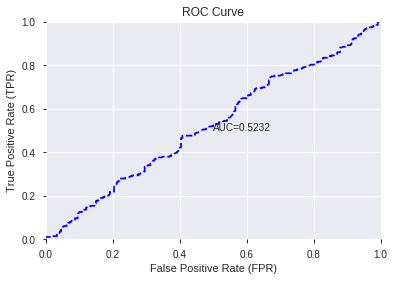

This function is available for GLM models only


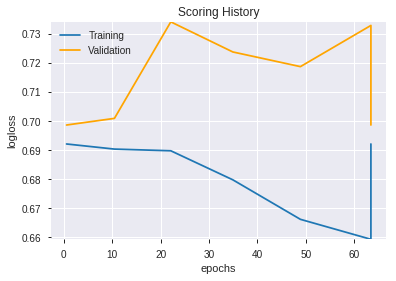

--2019-08-25 13:30:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_131000_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_131000_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLTHRUSTING',
 'VAR_12',
 'STDDEV_14',
 'CDLTASUKIGAP',
 'VAR_20',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'CDLONNECK',
 'CDLMATCHINGLOW',
 'CDLHARAMI',
 'VAR_30',
 'is_quarter_start',
 'VAR_14',
 'Volume',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'CDL3LINESTRIKE',
 'CDLSTICKSANDWICH',
 'CDLHOMINGPIGEON',
 'CDLPIERCING',
 'CDLUNIQUE3RIVER',
 'CORREL_30',
 'CDLSHOOTINGSTAR',
 'CDLDOJI',
 'VAR_24',
 'CDLMORNINGDOJISTAR',
 'is_month_start',
 'TRANGE',
 'VAR_8',
 'CDLEVENINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'DIV',
 'CDLRICKSHAWMAN',
 'CDLINVERTEDHAMMER',
 'CDLTAKURI',
 'CDLDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'BBANDS_upperband_30_6_5',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'CDL3WHITESOLDIERS',
 'CDLHANGINGMAN',
 'CDLGRAVESTONEDOJI',
 'CDL3BLACKCROWS',
 'CDLHAMMER',
 'CDLDARKCLOUDCOVER',
 'is_month_end',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'CDLMORNINGSTAR']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_133150_model_1  0.500568  0.690369                   0.5  0.498611  0.248613

variable  relative_importance  scaled_importance  percentage
0                CDL3INSIDE             0.008925           1.000000    0.063692
1              CDLTHRUSTING             0.006810           0.763061    0.048601
2       CDLGAPSIDESIDEWHITE             0.006344           0.710749    0.045269
3           CDLHOMINGPIGEON             0.006141           0.688063    0.043824
4                 CDLONNECK             0.005741           0.643257    0.040970
5            CDLMATCHINGLOW             0.005334           0.597636    0.038064
6         CDLGRAVESTONEDOJI             0.004912           0.550387    0.035055
7         CDLINVERTEDHAMMER             0.004904           0.549438    0.034995
8         CDLSTALLEDPATTERN             0.004744           0.531530    0.033854
9           CDLADVANCEBLOCK             0.004504           0.504597    0.032139
10        CDLDARKCLOUDCOVER             0.004067           0.455672    0.029022
11          CDLUNIQUE3RIVER             0.004026           0.451089    0.028731
12                CDLHAMMER             0.003804           0.426187    0.027145
13                   Volume             0.003792           0.424883    0.027061
14       CDLMORNINGDOJISTAR             0.003599           0.403247    0.025683
15           CDLRICKSHAWMAN             0.003586           0.401738    0.025587
16                CDLHARAMI             0.003543           0.396938    0.025282
17           CDL3BLACKCROWS             0.003542           0.396822    0.025274
18       CDLSEPARATINGLINES             0.003508           0.393014    0.025032
19             CDLTASUKIGAP             0.003467           0.388489    0.024743
20           CDLMORNINGSTAR             0.003212           0.359883    0.022922
21                  CDLDOJI             0.003155           0.353469    0.022513
22        CDLLONGLEGGEDDOJI             0.002695           0.301942    0.019231
23              CDLPIERCING             0.002630           0.294681    0.018769
24                   VAR_24             0.002554           0.286133    0.018224
25                    VAR_8             0.002538           0.284362    0.018112
26          CDLSHOOTINGSTAR             0.002331           0.261175    0.016635
27              CDLDOJISTAR             0.002241           0.251137    0.015995
28                   VAR_30             0.002210           0.247567    0.015768
29                   VAR_12             0.002116           0.237075    0.015100
30                   VAR_20             0.001926           0.215778    0.013743
31         CDLSTICKSANDWICH             0.001719           0.192579    0.012266
32                      DIV             0.001683           0.188620    0.012014
33             is_month_end             0.001646           0.184469    0.011749
34                      SUB             0.001644           0.184181    0.011731
35                   TRANGE             0.001274           0.142722    0.009090
36  BBANDS_upperband_30_6_5             0.001236           0.138523    0.008823
37            CDLHANGINGMAN             0.001004           0.112486    0.007164
38                STDDEV_14             0.000983           0.110139    0.007015
39           CDLEVENINGSTAR             0.000952           0.106634    0.006792
40                   VAR_14             0.000851           0.095375    0.006075
41       CDLIDENTICAL3CROWS             0.000768           0.086084    0.005483
42        CDL3WHITESOLDIERS             0.000641           0.071796    0.004573
43           CDL3LINESTRIKE             0.000586           0.065646    0.004181
44       CDLEVENINGDOJISTAR             0.000579           0.064904    0.004134
45                CORREL_30             0.000496           0.055542    0.003538
46         is_quarter_start             0.000402           0.045049    0.002869
47         CDLDRAGONFLYDOJI             0.000353           0.039595    0.002522
48                CDLTAKURI             0.000334           0.037378    0.002381
49           is_mon

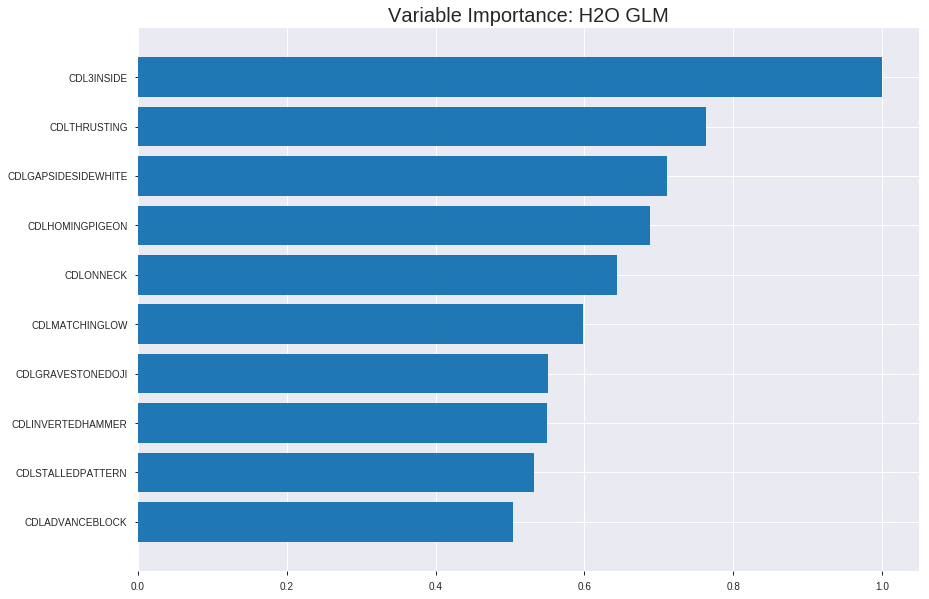

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_133150_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24814685816010235
RMSE: 0.49814341123827216
LogLoss: 0.6894321535959971
Null degrees of freedom: 3627
Residual degrees of freedom: 3577
Null deviance: 5011.396974952616
Residual deviance: 5002.519706492555
AIC: 5104.519706492555
AUC: 0.5414881504313099
pr_auc: 0.5754563899265482
Gini: 0.08297630086261987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5172323909582435: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      44   1642  0.9739   (1642.0/1686.0)
1      14   1928  0.0072   (14.0/1942.0)
Total  58   3570  0.4564   (1656.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517232     0.699565  359
max f2                       0.503396     0.852727  390
max f0point5                 0.52684      0.596954  317
max accuracy                 0.52684      0.549614  317
max precision                0.591344     1         0
max recall                   0.503396     1         390
max specificity              0.591344     1         0
max absolute_mcc             0.52684      0.085498  317
max min_per_class_accuracy   0.534878     0.524717  210
max mean_per_class_accuracy  0.534316     0.533838  227

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101985                   0.553282           1.41376   1.41376            0.756757         0.565318  0.756757                    0.565318            0.0144181       0.0144181                  41.3756    41.3756
    2        0.0201213                   0.548353           1.14166   1.27957            0.611111         0.550868  0.684932                    0.558192            0.0113285       0.0257467                  14.1664    27.9573
    3        0.0300441                   0.545406           1.08977   1.21689            0.583333         0.54649   0.651376                    0.554327            0.0108136       0.0365602                  8.977      21.6886
    4        0.0402426                   0.543854           1.21179   1.21559            0.648649         0.544662  0.650685                    0.551878            0.0123584       0.0489186                  21.1791    21.5595
    5        0.0501654                   0.542609           1.08977   1.19071            0.583333         0.543068  0.637363                    0.550135            0.0108136       0.0597322                  8.977      19.0706
    6        0.100055                    0.540526           1.14568   1.16825            0.61326          0.541393  0.625344                    0.545776            0.0571576       0.11689                    14.5678    16.8254
    7        0.150221                    0.538865           1.02647   1.12091            0.549451         0.53976   0.6                         0.543767            0.0514933       0.168383                   2.6471     12.0906
    8        0.20011                     0.537594           1.0115    1.09363            0.541436         0.538189  0.585399                    0.542376            0.0504634       0.218847                   1.14992    9.36299
    9        0.300165                    0.536221           1.00357   1.06361            0.53719          0.536828  0.56933                     0.540527            0.100412        0.319258                   0.356623   6.36087
    10       0.399945                    0.535398           1.01666   1.0519             0.544199         0.535789  0.56306                     0.539345            0.101442        0.4207                     1.66599    5.18957
    11       0.5                         0.534841           1.04474   1.05046            0.559229         0.535104  0.562293                    0.538496            0.104531        0.525232                   4.47382    5.04634
    12       0.600055                    0.534455           0.988127  1.04007            0.528926         0.534652  0.556729                    0.537855            0.0988671       0.624099                   -1.18732   4.00692
    13       0.699835                    0.534096           1.04246   1.04041            0.558011         0.534271  0.556912                    0.537344            0.104016        0.728115                   4.24635    4.04106
    14       0.79989                     0.533673           0.88005   1.02035            0.471074         0.533893  0.546175                    0.536913            0.0880536       0.816169                   -11.995    2.03517
    15       0.899945                    0.531923           0.993273  1.01734            0.53168          0.533213  0.544564                    0.536501            0.0993821       0.915551                   -0.672676  1.73412
    16       1                           0.473007           0.844025  1                  0.451791         0.524307  0.535281                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2504018646095857
RMSE: 0.5004017032440894
LogLoss: 0.6939552231208593
Null degrees of freedom: 1035
Residual degrees of freedom: 985
Null deviance: 1437.4140588309256
Residual deviance: 1437.8752223064205
AIC: 1539.8752223064205
AUC: 0.4975888381668457
pr_auc: 0.5070842206079643
Gini: -0.004822323666308637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4935946924876051: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    503   0.998    (503.0/504.0)
1      0    532   0        (0.0/532.0)
Total  1    1035  0.4855   (503.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.493595     0.679004   398
max f2                       0.493595     0.840974   398
max f0point5                 0.493595     0.569349   398
max accuracy                 0.533548     0.527992   277
max precision                0.590993     1          0
max recall                   0.493595     1          398
max specificity              0.590993     1          0
max absolute_mcc             0.537964     0.0643773  137
max min_per_class_accuracy   0.535605     0.505639   207
max mean_per_class_accuracy  0.533548     0.519893   277

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 53.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.549373           1.23923   1.23923            0.636364         0.560445  0.636364                    0.560445            0.0131579       0.0131579                  23.9234   23.9234
    2        0.0202703                   0.54644            0.778947  1.02005            0.4              0.547567  0.52381                     0.554313            0.0075188       0.0206767                  -22.1053  2.00501
    3        0.030888                    0.545538           1.0622    1.03454            0.545455         0.545951  0.53125                     0.551438            0.0112782       0.0319549                  6.2201    3.45395
    4        0.0405405                   0.544683           1.36316   1.11278            0.7              0.545049  0.571429                    0.549917            0.0131579       0.0451128                  36.3158   11.2782
    5        0.0501931                   0.543392           0.973684  1.08603            0.5              0.544128  0.557692                    0.548804            0.0093985       0.0545113                  -2.63158  8.60324
    6        0.100386                    0.541457           0.748988  0.91751            0.384615         0.542243  0.471154                    0.545523            0.037594        0.0921053                  -25.1012  -8.24899
    7        0.150579                    0.540013           1.01113   0.948718           0.519231         0.54063   0.487179                    0.543892            0.0507519       0.142857                   1.11336   -5.12821
    8        0.200772                    0.538939           0.711538  0.889423           0.365385         0.539402  0.456731                    0.54277             0.0357143       0.178571                   -28.8462  -11.0577
    9        0.300193                    0.537431           1.02095   0.932984           0.524272         0.538138  0.4791                      0.541236            0.101504        0.280075                   2.09504   -6.70164
    10       0.400579                    0.536376           1.10476   0.97603            0.567308         0.536803  0.501205                    0.540125            0.110902        0.390977                   10.4757   -2.39696
    11       0.5                         0.535596           1.1533    1.01128            0.592233         0.535932  0.519305                    0.539291            0.114662        0.505639                   15.3296   1.12782
    12       0.600386                    0.534924           1.02986   1.01438            0.528846         0.535223  0.5209                      0.538611            0.103383        0.609023                   2.98583   1.43848
    13       0.699807                    0.534288           1.00204   1.01263            0.514563         0.534611  0.52                        0.538042            0.0996241       0.708647                   0.204394  1.26316
    14       0.800193                    0.533542           1.10476   1.02419            0.567308         0.533914  0.525935                    0.537525            0.110902        0.819549                   10.4757   2.41889
    15       0.899614                    0.530816           0.775166  0.996668           0.398058         0.532814  0.511803                    0.537004            0.0770677       0.896617                   -22.4834  -0.333183
    16       1                           0.477396           1.02986   1                  0.528846         0.524823  0.513514                    0.535781  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 13:31:51  0.000 sec   2            2         51            1.37886           1.38791
    2019-08-25 13:31:51  0.037 sec   4            1.2       51            1.37776           1.38825
    2019-08-25 13:31:51  0.071 sec   6            0.75      51            1.37637           1.38882
    2019-08-25 13:31:51  0.105 sec   8            0.47      51            1.3748            1.38977
    2019-08-25 13:31:51  0.137 sec   10           0.29      51            1.37322           1.39117

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5414258188824663)

('F1', 0.6992481203007519)

('auc', 0.5005675029868578)

('logloss', 0.6903688659415634)

('mean_per_class_error', 0.47280465949820794)

('rmse', 0.49861148423989327)

('mse', 0.24861341221590932)

glm prediction progress: |████████████████████████████████████████████████| 100%


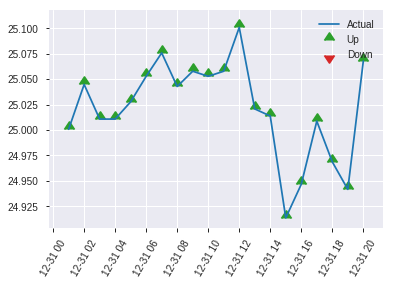


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24861341221590932
RMSE: 0.49861148423989327
LogLoss: 0.6903688659415634
Null degrees of freedom: 518
Residual degrees of freedom: 468
Null deviance: 716.5643274932833
Residual deviance: 716.6028828473428
AIC: 818.6028828473428
AUC: 0.5005675029868578
pr_auc: 0.543414654396959
Gini: 0.0011350059737156304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4952548307944232: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    240  1        (240.0/240.0)
1      0    279  0        (0.0/279.0)
Total  0    519  0.4624   (240.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.495255     0.699248   399
max f2                       0.495255     0.853211   399
max f0point5                 0.526606     0.594059   391
max accuracy                 0.526857     0.541426   389
max precision                0.589506     1          0
max recall                   0.495255     1          399
max specificity              0.589506     1          0
max absolute_mcc             0.541475     0.0692609  84
max min_per_class_accuracy   0.536862     0.495833   211
max mean_per_class_accuracy  0.541033     0.527195   92

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 53.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.552988           1.24014   1.24014            0.666667         0.56193   0.666667                    0.56193             0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.549649           0.744086  1.01466            0.4              0.551326  0.545455                    0.55711             0.00716846      0.0215054                  -25.5914  1.46628
    3        0.0308285                   0.54786            1.11613   1.04637            0.6              0.548406  0.5625                      0.55439             0.0107527       0.0322581                  11.6129   4.6371
    4        0.0404624                   0.547004           0         0.797235           0                0.547605  0.428571                    0.552774            0               0.0322581                  -100      -20.2765
    5        0.0500963                   0.54607            0.744086  0.787014           0.4              0.546416  0.423077                    0.551552            0.00716846      0.0394265                  -25.5914  -21.2986
    6        0.100193                    0.543598           1.21629   1.00165            0.653846         0.544952  0.538462                    0.548252            0.0609319       0.100358                   21.6294   0.165426
    7        0.150289                    0.542264           1.28784   1.09705            0.692308         0.542946  0.589744                    0.546483            0.0645161       0.164875                   28.7841   9.70499
    8        0.200385                    0.541171           1.14475   1.10897            0.615385         0.54164   0.596154                    0.545272            0.0573477       0.222222                   14.4748   10.8974
    9        0.300578                    0.539164           0.787014  1.00165            0.423077         0.540092  0.538462                    0.543546            0.078853        0.301075                   -21.2986  0.165426
    10       0.400771                    0.537762           1.0732    1.01954            0.576923         0.538474  0.548077                    0.542278            0.107527        0.408602                   7.3201    1.95409
    11       0.500963                    0.536862           0.894334  0.9945             0.480769         0.537336  0.534615                    0.541289            0.0896057       0.498208                   -10.5666  -0.550041
    12       0.599229                    0.535797           1.05777   1.00488            0.568627         0.536326  0.540193                    0.540475            0.103943        0.602151                   5.77693   0.487501
    13       0.699422                    0.535127           0.787014  0.973666           0.423077         0.535455  0.523416                    0.539756            0.078853        0.681004                   -21.2986  -2.63337
    14       0.799615                    0.534129           1.03743   0.981656           0.557692         0.53472   0.527711                    0.539125            0.103943        0.784946                   3.74276   -1.83443
    15       0.899807                    0.531968           1.03743   0.987866           0.557692         0.532951  0.531049                    0.538438            0.103943        0.888889                   3.74276   -1.21342
    16       1                           0.495255           1.10897   1                  0.596154         0.527783  0.537572                    0.53737 

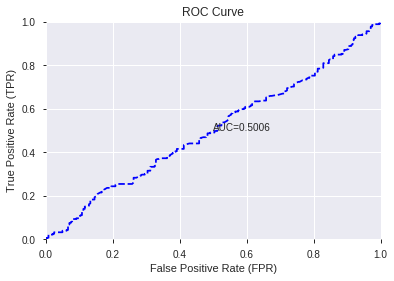

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


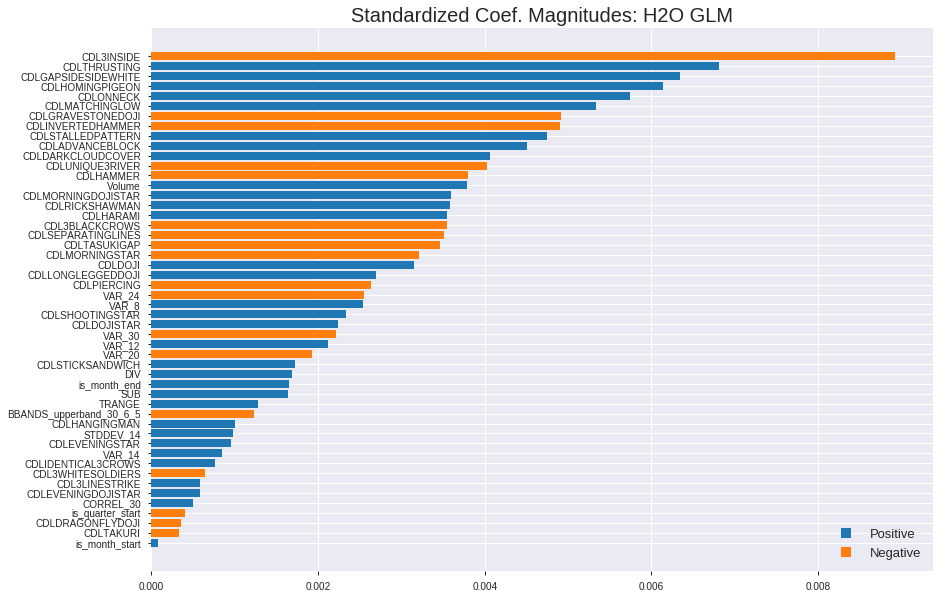

'log_likelihood'
--2019-08-25 13:32:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_133150_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_133150_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDL3INSIDE',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLHOMINGPIGEON',
 'CDLONNECK',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CDLSTALLEDPATTERN',
 'CDLADVANCEBLOCK',
 'CDLDARKCLOUDCOVER',
 'CDLUNIQUE3RIVER',
 'CDLHAMMER',
 'Volume',
 'CDLMORNINGDOJISTAR',
 'CDLRICKSHAWMAN',
 'CDLHARAMI',
 'CDL3BLACKCROWS',
 'CDLSEPARATINGLINES',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLPIERCING',
 'VAR_24',
 'VAR_8',
 'CDLSHOOTINGSTAR',
 'CDLDOJISTAR',
 'VAR_30',
 'VAR_12',
 'VAR_20',
 'CDLSTICKSANDWICH',
 'DIV',
 'is_month_end',
 'SUB',
 'TRANGE',
 'BBANDS_upperband_30_6_5',
 'CDLHANGINGMAN',
 'STDDEV_14',
 'CDLEVENINGSTAR',
 'VAR_14',
 'CDLIDENTICAL3CROWS',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLEVENINGDOJISTAR',
 'CORREL_30',
 'is_quarter_start',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_month_start']

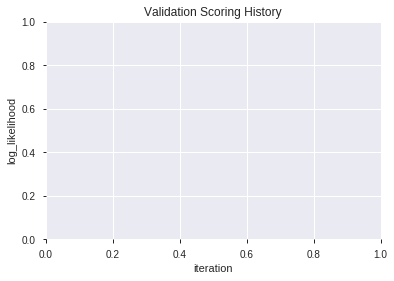

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_133258_model_1  0.492040  0.698144              0.500000  0.502415  0.252421
1  XGBoost_grid_1_AutoML_20190825_133258_model_2  0.489568  0.696265              0.500000  0.501515  0.251517
2               XGBoost_1_AutoML_20190825_133258  0.489524  0.706767              0.500000  0.506490  0.256532
3  XGBoost_grid_1_AutoML_20190825_133258_model_5  0.488695  0.731529              0.500000  0.516788  0.267070
4               XGBoost_3_AutoML_20190825_133258  0.487059  0.700605              0.500000  0.503571  0.253584
5               XGBoost_2_AutoML_20190825_133258  0.482930  0.710939              0.500000  0.508413  0.258483
6  XGBoost_grid_1_AutoML_20190825_133258_model_3  0.480369  0.703649              0.500000  0.505053  0.255079
7  XGBoost_grid_1_AutoML_20190825_133258_model_7  0.477681  0.713089              0.500000  0.509325  0.259412
8  XGBoost_grid_1_AutoML_20190825_133258_model_6  0.463068  0.705167              0.497917  0.505867  0.255901
9  XGBoost_grid_1_AutoML_20190825_133258_model_4  0.443474  0.701153              0.497917  0.503916  0.253932

variable  relative_importance  scaled_importance  percentage
0                    TRANGE           291.873077           1.000000    0.114906
1                     VAR_8           279.790466           0.958603    0.110150
2                 CORREL_30           277.086670           0.949340    0.109085
3   BBANDS_upperband_30_6_5           256.802063           0.879842    0.101099
4                    Volume           240.727295           0.824767    0.094771
5                    VAR_20           214.941757           0.736422    0.084619
6                    VAR_30           170.009705           0.582478    0.066930
7                    VAR_12           152.871536           0.523760    0.060183
8                       DIV           148.938919           0.510287    0.058635
9                 STDDEV_14           107.148354           0.367106    0.042183
10               CDL3INSIDE            92.177055           0.315812    0.036289
11                   VAR_24            86.794807           0.297372    0.034170
12                      SUB            75.822319           0.259778    0.029850
13           CDLMATCHINGLOW            36.885872           0.126376    0.014521
14        CDLLONGLEGGEDDOJI            27.678574           0.094831    0.010897
15                   VAR_14            22.853445           0.078299    0.008997
16                  CDLDOJI            20.028646           0.068621    0.007885
17           CDLRICKSHAWMAN            16.547552           0.056694    0.006515
18                CDLHARAMI             9.573894           0.032802    0.003769
19         CDLDRAGONFLYDOJI             4.125307           0.014134    0.001624
20                CDLHAMMER             2.983645           0.010222    0.001175
21          CDLADVANCEBLOCK             2.764124           0.009470    0.001088
22        CDLGRAVESTONEDOJI             1.672215           0.005729    0.000658

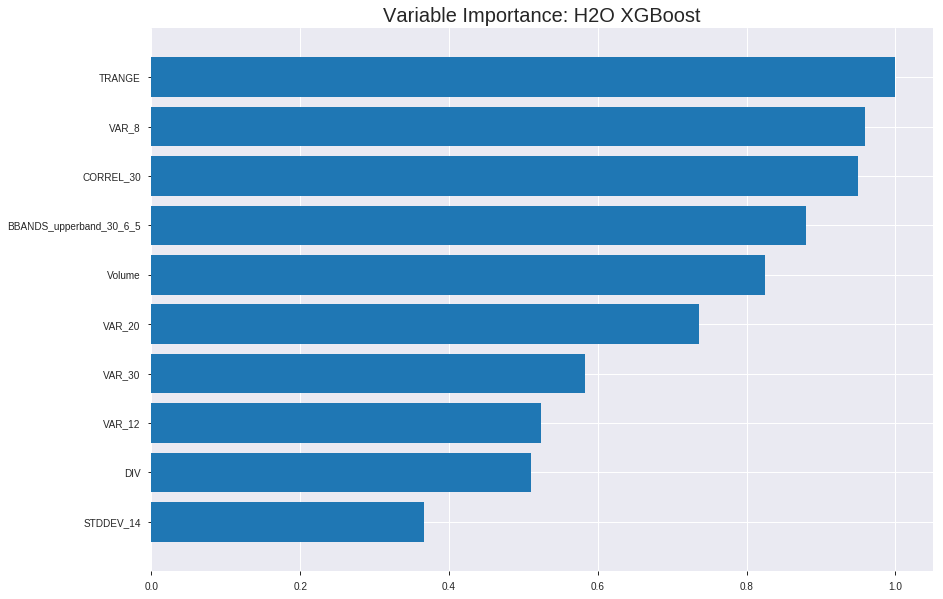

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_133258_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23195384618430287
RMSE: 0.48161586994647804
LogLoss: 0.6566018452841258
Mean Per-Class Error: 0.31265812965073736
AUC: 0.7535790290915798
pr_auc: 0.7715675099011728
Gini: 0.5071580581831596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5111477110120985: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      609  1077  0.6388   (1077.0/1686.0)
1      171  1771  0.0881   (171.0/1942.0)
Total  780  2848  0.344    (1248.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511148     0.739457  238
max f2                       0.481777     0.858034  289
max f0point5                 0.538167     0.713304  173
max accuracy                 0.537743     0.68495   174
max precision                0.740124     1         0
max recall                   0.335361     1         389
max specificity              0.740124     1         0
max absolute_mcc             0.537743     0.37407   174
max min_per_class_accuracy   0.535288     0.679197  179
max mean_per_class_accuracy  0.537743     0.687342  174

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.640145           1.81769   1.81769            0.972973         0.661737  0.972973                    0.661737            0.0185376       0.0185376                  81.7686   81.7686
    2        0.0201213                   0.624128           1.76439   1.7914             0.944444         0.630853  0.958904                    0.646506            0.0175077       0.0360453                  76.439    79.1403
    3        0.0300441                   0.61404            1.6606    1.7482             0.888889         0.618641  0.93578                     0.637303            0.0164779       0.0525232                  66.0602   74.8202
    4        0.0402426                   0.607594           1.66621   1.72742            0.891892         0.610439  0.924658                    0.630495            0.0169928       0.069516                   66.6212   72.7424
    5        0.050441                    0.602838           1.61572   1.70484            0.864865         0.605109  0.912568                    0.625362            0.0164779       0.0859938                  61.5721   70.4839
    6        0.100055                    0.58317            1.5153    1.61085            0.811111         0.592132  0.862259                    0.608885            0.0751802       0.161174                   51.5299   61.0852
    7        0.150221                    0.57134            1.62182   1.61452            0.868132         0.576601  0.86422                     0.598104            0.0813594       0.242533                   62.1824   61.4516
    8        0.20011                     0.562525           1.53789   1.59541            0.823204         0.566244  0.853994                    0.590161            0.076725        0.319258                   53.7892   59.5413
    9        0.300165                    0.548883           1.29177   1.4942             0.69146          0.55541   0.799816                    0.578577            0.129248        0.448507                   29.177    49.4199
    10       0.399945                    0.541574           1.13536   1.40467            0.607735         0.545063  0.751895                    0.570216            0.113285        0.561792                   13.5356   40.4674
    11       0.5                         0.535858           1.09106   1.34192            0.584022         0.539065  0.718302                    0.563982            0.109166        0.670958                   9.10566   34.1916
    12       0.600055                    0.528811           0.910929  1.27005            0.487603         0.532442  0.679835                    0.558723            0.0911432       0.762101                   -8.90707  27.0052
    13       0.699835                    0.520788           0.861839  1.21185            0.461326         0.525027  0.648681                    0.553919            0.0859938       0.848095                   -13.8161  21.185
    14       0.79989                     0.50877            0.725656  1.15103            0.38843          0.514935  0.616127                    0.549043            0.0726056       0.9207                     -27.4344  15.1034
    15       0.899945                    0.4854             0.535235  1.08257            0.286501         0.497852  0.579479                    0.543351            0.053553        0.974253                   -46.4765  8.257
    16       1                           0.295558           0.257325  1                  0.137741         0.4355    0.535281                    0.53256             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2528135060075948
RMSE: 0.5028056344230788
LogLoss: 0.6989258473914788
Mean Per-Class Error: 0.47744360902255645
AUC: 0.49747135696383815
pr_auc: 0.5173687138827953
Gini: -0.005057286072323697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3428107798099518: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    502   0.996    (502.0/504.0)
1      0    532   0        (0.0/532.0)
Total  2    1034  0.4846   (502.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.342811     0.679438   397
max f2                       0.342811     0.84124    397
max f0point5                 0.342811     0.569837   397
max accuracy                 0.497638     0.519305   343
max precision                0.727532     1          0
max recall                   0.342811     1          397
max specificity              0.727532     1          0
max absolute_mcc             0.589007     0.0605968  99
max min_per_class_accuracy   0.544139     0.492063   211
max mean_per_class_accuracy  0.589007     0.522556   99

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 54.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0106178                   0.667195           1.0622    1.0622             0.545455         0.684072  0.545455                    0.684072            0.0112782       0.0112782                  6.2201     6.2201
    2        0.0202703                   0.655971           0.973684  1.02005            0.5              0.660869  0.52381                     0.673023            0.0093985       0.0206767                  -2.63158   2.00501
    3        0.030888                    0.64724            1.0622    1.03454            0.545455         0.651522  0.53125                     0.665632            0.0112782       0.0319549                  6.2201     3.45395
    4        0.0405405                   0.63909            0.973684  1.02005            0.5              0.643092  0.52381                     0.660266            0.0093985       0.0413534                  -2.63158   2.00501
    5        0.0501931                   0.632078           0.973684  1.01113            0.5              0.635431  0.519231                    0.65549             0.0093985       0.0507519                  -2.63158   1.11336
    6        0.100386                    0.603811           1.12348   1.06731            0.576923         0.617254  0.548077                    0.636372            0.056391        0.107143                   12.3482    6.73077
    7        0.150579                    0.592397           1.19838   1.111              0.615385         0.598511  0.570513                    0.623752            0.0601504       0.167293                   19.8381    11.0999
    8        0.200772                    0.581366           1.01113   1.08603            0.519231         0.586873  0.557692                    0.614532            0.0507519       0.218045                   1.11336    8.60324
    9        0.300193                    0.566388           0.718447  0.964292           0.368932         0.573617  0.495177                    0.600981            0.0714286       0.289474                   -28.1553   -3.57082
    10       0.400579                    0.553117           0.973684  0.966646           0.5              0.55908   0.496386                    0.590481            0.0977444       0.387218                   -2.63158   -3.33545
    11       0.5                         0.544061           1.05876   0.984962           0.543689         0.548021  0.505792                    0.582038            0.105263        0.492481                   5.87634    -1.50376
    12       0.600386                    0.535933           1.04858   0.9956             0.538462         0.539862  0.511254                    0.574986            0.105263        0.597744                   4.8583     -0.440007
    13       0.699807                    0.529209           0.964231  0.991143           0.495146         0.5326    0.508966                    0.568965            0.0958647       0.693609                   -3.5769    -0.885662
    14       0.800193                    0.517993           1.12348   1.00775            0.576923         0.524028  0.517491                    0.563327            0.112782        0.806391                   12.3482    0.774554
    15       0.899614                    0.503597           0.945324  1.00085            0.485437         0.511468  0.513948                    0.557596            0.093985        0.900376                   -5.46755   0.0847075
    16       1                           0.327768           0.992409  1                  0.509615         0.472565  0.513514           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:33:13  0.023 sec   0                  0.5              0.693147            0.5             0                  1                0.464719                         0.5                0.693147              0.5               0                    1                  0.486486
    2019-08-25 13:33:13  0.092 sec   5                  0.497882         0.688915            0.595689        0.63012            1.61572          0.443219                         0.49982            0.692788              0.497367          0.518248             1.13596            0.486486
    2019-08-25 13:33:13  0.130 sec   10                 0.496127         0.685404            0.614404        0.64712            1.7167           0.428335                         0.499891           0.692932              0.505014          0.521042             1.07105            0.486486
    2019-08-25 13:33:13  0.177 sec   15                 0.494185         0.681529            0.646229        0.676039           1.76719          0.41538                          0.500071           0.693302              0.508481          0.521882             1.09539            0.482625
    2019-08-25 13:33:13  0.239 sec   20                 0.492341         0.677859            0.673382        0.698723           1.7167           0.374587                         0.500679           0.694533              0.50042           0.517817             0.885167           0.484556
    2019-08-25 13:33:13  0.314 sec   25                 0.490182         0.673568            0.698961        0.720033           1.7167           0.365491                         0.500944           0.695075              0.503614          0.519822             0.885167           0.484556
    2019-08-25 13:33:13  0.382 sec   30                 0.48889          0.670986            0.699177        0.720249           1.76719          0.374862                         0.501473           0.696146              0.498835          0.52019              1.29825            0.484556
    2019-08-25 13:33:13  0.464 sec   35                 0.486787         0.666819            0.723789        0.740448           1.7167           0.35419                          0.502005           0.697241              0.49551           0.518495             1.0622             0.484556
    2019-08-25 13:33:13  0.540 sec   40                 0.485006         0.663304            0.738231        0.755319           1.76719          0.359151                         0.502245           0.697746              0.496187          0.516507             0.885167           0.484556
    2019-08-25 13:33:13  0.622 sec   45                 0.483635         0.660585            0.742742        0.760226           1.81769          0.333241                         0.502394           0.698061              0.498715          0.517491             1.0622             0.483591
    2019-08-25 13:33:13  0.729 sec   50                 0.481616         0.656602            0.753579        0.771568           1.81769          0.343991                         0.502806           0.698926              0.497471          0.517369             1.0622             0.484556

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
TRANGE                   291.8730773925781      1.0                   0.11490625877224743
VAR_8                    279.79046630859375     0.95860320111768      0.11014950748753288
CORREL_30                277.086669921875       0.9493395978731709    0.10908506149595588
BBANDS_upperband_30_6_5  256.80206298828125     0.8798415574413351    0.10109930167793124
Volume                   240.727294921875       0.8247670428269391    0.09477089524989354
---                      ---                    ---                   ---
CDLHARAMI                9.573893547058105      0.03280156440801468   0.003769105048001876
CDLDRAGONFLYDOJI         4.125306606292725      0.014133905885207982  0.0016240742471082992
CDLHAMMER                2.98364520072937       0.01022240635341737   0.0011746184697208424
CDLADVANCEBLOCK          2.7641239166259766     0.009470294215962051  0.0010881960778286535
CDLGRAVESTONEDOJI        1.672215223312378      0.005729254778313102  0.0006583272321289803


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5414258188824663)

('F1', 0.6992481203007519)

('auc', 0.49204002389486257)

('logloss', 0.6981435740935095)

('mean_per_class_error', 0.4713037634408602)

('rmse', 0.5024151544181381)

('mse', 0.2524209873890016)

xgboost prediction progress: |████████████████████████████████████████████| 100%


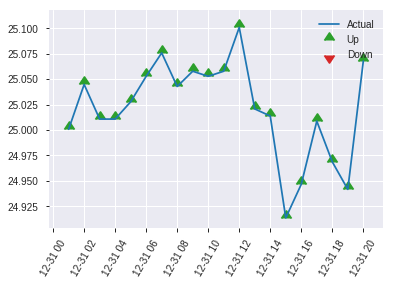


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2524209873890016
RMSE: 0.5024151544181381
LogLoss: 0.6981435740935095
Mean Per-Class Error: 0.4713037634408602
AUC: 0.49204002389486257
pr_auc: 0.527660858871129
Gini: -0.015919952210274868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4090169072151184: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    240  1        (240.0/240.0)
1      0    279  0        (0.0/279.0)
Total  0    519  0.4624   (240.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409017     0.699248  399
max f2                       0.409017     0.853211  399
max f0point5                 0.409017     0.592357  399
max accuracy                 0.511115     0.541426  304
max precision                0.672145     1         0
max recall                   0.409017     1         399
max specificity              0.672145     1         0
max absolute_mcc             0.43811      0.101888  389
max min_per_class_accuracy   0.540161     0.505376  202
max mean_per_class_accuracy  0.536336     0.528696  218

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.645735           1.24014   1.24014            0.666667         0.658595  0.666667                    0.658595            0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.635248           1.11613   1.18377            0.6              0.641749  0.636364                    0.650938            0.0107527       0.0250896                  11.6129   18.3773
    3        0.0308285                   0.630796           0.744086  1.04637            0.4              0.633032  0.5625                      0.645342            0.00716846      0.0322581                  -25.5914  4.6371
    4        0.0423892                   0.627435           0.620072  0.930108           0.333333         0.628721  0.5                         0.640809            0.00716846      0.0394265                  -37.9928  -6.98925
    5        0.0500963                   0.623803           1.39516   1.00165            0.75             0.626878  0.538462                    0.638666            0.0107527       0.0501792                  39.5161   0.165426
    6        0.1079                      0.606917           0.744086  0.863671           0.4              0.612061  0.464286                    0.624413            0.0430108       0.09319                    -25.5914  -13.6329
    7        0.152216                    0.591708           0.808789  0.847693           0.434783         0.598802  0.455696                    0.616957            0.0358423       0.129032                   -19.1211  -15.2307
    8        0.200385                    0.57962            1.11613   0.912221           0.6              0.58561   0.490385                    0.609421            0.0537634       0.182796                   11.6129   -8.77792
    9        0.300578                    0.563677           0.965881  0.930108           0.519231         0.571984  0.5                         0.596942            0.0967742       0.27957                    -3.41191  -6.98925
    10       0.400771                    0.547385           1.14475   0.983768           0.615385         0.554537  0.528846                    0.586341            0.114695        0.394265                   14.4748   -1.62324
    11       0.50289                     0.540061           1.12315   1.01207            0.603774         0.543349  0.544061                    0.577611            0.114695        0.508961                   12.3149   1.2071
    12       0.61079                     0.53235            1.06298   1.02106            0.571429         0.535518  0.548896                    0.570175            0.114695        0.623656                   6.298     2.10644
    13       0.699422                    0.521837           0.889668  1.00441            0.478261         0.526868  0.539945                    0.564687            0.078853        0.702509                   -11.0332  0.441364
    14       0.799615                    0.508965           1.10897   1.01752            0.596154         0.515273  0.546988                    0.558495            0.111111        0.81362                    10.8974   1.75152
    15       0.899807                    0.483701           0.715467  0.983882           0.384615         0.498379  0.528908                    0.551801            0.0716846       0.885305                   -28.4533  -1.61175
    16       1                           0.409017           1.14475   1                  0.615385         0.453354  0.537572                    0.541938  

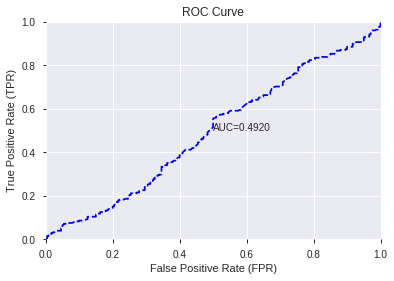

This function is available for GLM models only


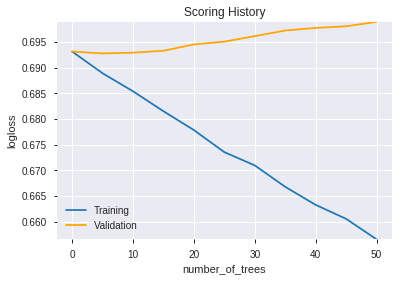

--2019-08-25 13:33:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_133258_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_133258_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['TRANGE',
 'VAR_8',
 'CORREL_30',
 'BBANDS_upperband_30_6_5',
 'Volume',
 'VAR_20',
 'VAR_30',
 'VAR_12',
 'DIV',
 'STDDEV_14',
 'CDL3INSIDE',
 'VAR_24',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLLONGLEGGEDDOJI',
 'VAR_14',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHARAMI',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDLADVANCEBLOCK',
 'CDLGRAVESTONEDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_133432_model_1  0.514329  0.690478              0.497917  0.498662  0.248664

variable  relative_importance  scaled_importance  percentage
0                   CDL3INSIDE         7.243445e-03           1.000000    0.012556
1               CDLHARAMICROSS         6.080691e-03           0.839475    0.010541
2                 CDLTHRUSTING         6.072816e-03           0.838388    0.010527
3         HT_PHASOR_quadrature         5.949528e-03           0.821367    0.010313
4                          OBV         5.623110e-03           0.776303    0.009747
...                        ...                  ...                ...         ...
1033                 MAVP_14_6         1.604485e-06           0.000222    0.000003
1034  BBANDS_middleband_20_2_5         1.491758e-06           0.000206    0.000003
1035  BBANDS_middleband_30_0_2         7.394615e-07           0.000102    0.000001
1036                    WMA_14         6.209664e-07           0.000086    0.000001
1037                   MA_14_2         0.000000e+00           0.000000    0.000000

[1038 rows x 4 columns]

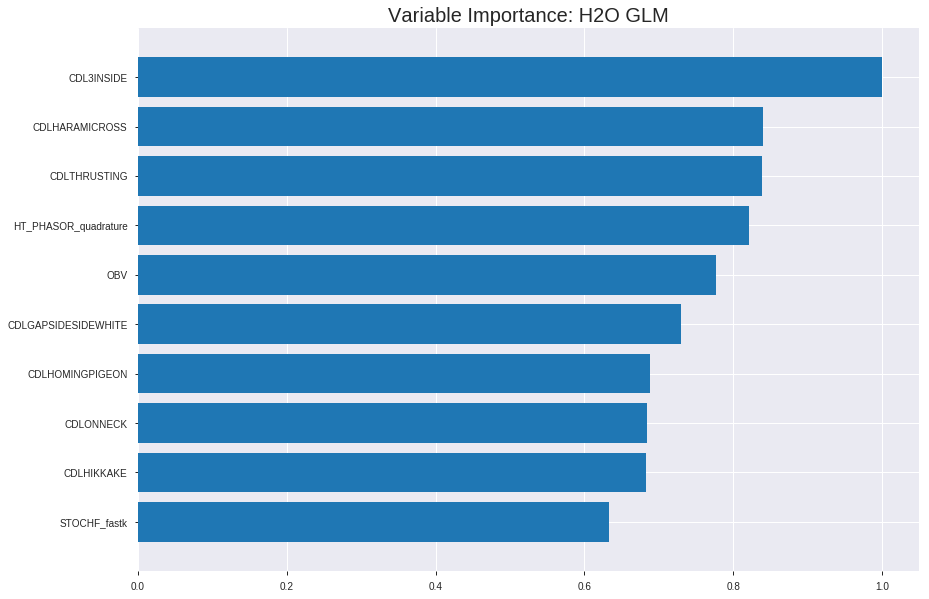

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_133432_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24701342343726654
RMSE: 0.497004450118172
LogLoss: 0.6871432517517012
Null degrees of freedom: 3627
Residual degrees of freedom: 2590
Null deviance: 5011.396974952616
Residual deviance: 4985.911434710344
AIC: 7061.911434710344
AUC: 0.5602566357951165
pr_auc: 0.5929601942499281
Gini: 0.12051327159023306
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4947326166074131: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      38   1648  0.9775   (1648.0/1686.0)
1      19   1923  0.0098   (19.0/1942.0)
Total  57   3571  0.4595   (1667.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.494733     0.697624   367
max f2                       0.421918     0.852053   399
max f0point5                 0.519229     0.598125   296
max accuracy                 0.521698     0.557056   283
max precision                0.659684     1          0
max recall                   0.421918     1          399
max specificity              0.659684     1          0
max absolute_mcc             0.532356     0.0905853  220
max min_per_class_accuracy   0.534281     0.541195   208
max mean_per_class_accuracy  0.532356     0.545213   220

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.584069           1.46425   1.46425            0.783784         0.60098   0.783784                    0.60098             0.0149331       0.0149331                  46.4247   46.4247
    2        0.0201213                   0.573941           1.34924   1.40753            0.722222         0.577042  0.753425                    0.589175            0.0133883       0.0283213                  34.9239   40.7531
    3        0.0300441                   0.57086            1.19356   1.33686            0.638889         0.57231   0.715596                    0.583605            0.0118435       0.0401648                  19.3558   33.6861
    4        0.0402426                   0.567184           1.31277   1.33076            0.702703         0.569073  0.712329                    0.579922            0.0133883       0.053553                   31.2773   33.0756
    5        0.0501654                   0.564922           1.29735   1.32415            0.694444         0.566157  0.708791                    0.577199            0.0128733       0.0664264                  29.7345   32.4148
    6        0.100055                    0.557015           1.13536   1.23001            0.607735         0.560753  0.658402                    0.568999            0.0566426       0.123069                   13.5356   23.0012
    7        0.150221                    0.552661           0.985412  1.14833            0.527473         0.554751  0.614679                    0.564241            0.0494336       0.172503                   -1.45879  14.8329
    8        0.20011                     0.549616           1.09407   1.1348             0.585635         0.551029  0.607438                    0.560947            0.0545829       0.227085                   9.40706   13.4802
    9        0.300165                    0.543594           1.06532   1.11164            0.570248         0.546364  0.595041                    0.556086            0.106591        0.333677                   6.53242   11.1643
    10       0.399945                    0.538791           1.02182   1.08923            0.546961         0.541232  0.583046                    0.55238             0.101957        0.435633                   2.18206   8.92335
    11       0.5                         0.534311           1.0293    1.07724            0.550964         0.536465  0.576626                    0.549195            0.102987        0.53862                    2.92987   7.724
    12       0.600055                    0.530108           0.98298   1.06152            0.526171         0.532152  0.568213                    0.546353            0.0983522       0.636972                   -1.70197  6.15228
    13       0.699835                    0.526116           0.949571  1.04556            0.508287         0.52807   0.559669                    0.543747            0.0947477       0.73172                    -5.04293  4.55611
    14       0.79989                     0.521568           1.01386   1.0416             0.5427           0.523944  0.557547                    0.54127             0.101442        0.833162                   1.38592   4.15957
    15       0.899945                    0.515113           0.864611  1.02192            0.46281          0.518681  0.547014                    0.538758            0.0865088       0.91967                    -13.5389  2.19186
    16       1                           0.421918           0.802853  1                  0.429752         0.504007  0.535281                    0.535281           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2506413726964361
RMSE: 0.5006409618643246
LogLoss: 0.694437470235043
Null degrees of freedom: 1035
Residual degrees of freedom: -2
Null deviance: 1437.4140588309256
Residual deviance: 1438.874438327009
AIC: 3514.874438327009
AUC: 0.49863498030791265
pr_auc: 0.5201222623436592
Gini: -0.0027300393841747095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48269890935554516: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    503   0.998    (503.0/504.0)
1      0    532   0        (0.0/532.0)
Total  1    1035  0.4855   (503.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.482699     0.679004   398
max f2                       0.482699     0.840974   398
max f0point5                 0.482699     0.569349   398
max accuracy                 0.528368     0.517375   252
max precision                0.611273     1          0
max recall                   0.482699     1          398
max specificity              0.611273     1          0
max absolute_mcc             0.583716     0.0555254  17
max min_per_class_accuracy   0.534342     0.5        214
max mean_per_class_accuracy  0.528368     0.513941   252

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 53.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.591597           1.41627   1.41627            0.727273         0.599197  0.727273                    0.599197            0.0150376       0.0150376                  41.6268   41.6268
    2        0.0202703                   0.582172           1.16842   1.29825            0.6              0.585354  0.666667                    0.592605            0.0112782       0.0263158                  16.8421   29.8246
    3        0.030888                    0.578756           0.885167  1.15625            0.454545         0.580041  0.59375                     0.588286            0.0093985       0.0357143                  -11.4833  15.625
    4        0.0405405                   0.57449            1.36316   1.20551            0.7              0.576643  0.619048                    0.585514            0.0131579       0.0488722                  36.3158   20.5514
    5        0.0501931                   0.57167            0.973684  1.16093            0.5              0.572849  0.596154                    0.583078            0.0093985       0.0582707                  -2.63158  16.0931
    6        0.100386                    0.561789           0.973684  1.06731            0.5              0.566332  0.548077                    0.574705            0.0488722       0.107143                   -2.63158  6.73077
    7        0.150579                    0.555841           0.898785  1.01113            0.461538         0.55852   0.519231                    0.56931             0.0451128       0.152256                   -10.1215  1.11336
    8        0.200772                    0.552569           0.973684  1.00177            0.5              0.554028  0.514423                    0.565489            0.0488722       0.201128                   -2.63158  0.177126
    9        0.300193                    0.545747           0.964231  0.989338           0.495146         0.549109  0.508039                    0.560065            0.0958647       0.296992                   -3.5769   -1.06617
    10       0.400579                    0.539848           1.04858   1.00419            0.538462         0.54266   0.515663                    0.555703            0.105263        0.402256                   4.8583    0.418516
    11       0.5                         0.534214           1.00204   1.00376            0.514563         0.537059  0.515444                    0.551996            0.0996241       0.50188                    0.204394  0.37594
    12       0.600386                    0.529722           1.08603   1.01752            0.557692         0.532011  0.522508                    0.548654            0.109023        0.610902                   8.60324   1.75157
    13       0.699807                    0.52474            0.831886  0.991143           0.427184         0.527111  0.508966                    0.545594            0.0827068       0.693609                   -16.8114  -0.885662
    14       0.800193                    0.518944           0.91751   0.981906           0.471154         0.521636  0.504222                    0.542588            0.0921053       0.785714                   -8.24899  -1.80941
    15       0.899614                    0.511827           1.09658   0.994579           0.563107         0.515455  0.51073                     0.539589            0.109023        0.894737                   9.65764   -0.542128
    16       1                           0.481524           1.04858   1                  0.538462         0.504134  0.513514                    0.53603   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 13:34:40  0.000 sec   2            2.4       1038          1.37429           1.38887
    2019-08-25 13:34:44  4.476 sec   4            1.7       1039          1.37272           1.38939
    2019-08-25 13:34:48  8.832 sec   6            1.3       1039          1.37087           1.39013
    2019-08-25 13:34:53  13.342 sec  8            0.92      1039          1.36874           1.39118
    2019-08-25 13:34:57  17.693 sec  10           0.67      1039          1.36634           1.39261

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5433526011560693)

('F1', 0.7001254705144292)

('auc', 0.5143294504181601)

('logloss', 0.6904780539160754)

('mean_per_class_error', 0.4731406810035842)

('rmse', 0.4986619060498309)

('mse', 0.24866369654525036)

glm prediction progress: |████████████████████████████████████████████████| 100%


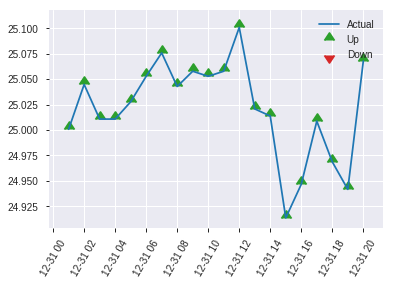


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24866369654525036
RMSE: 0.4986619060498309
LogLoss: 0.6904780539160754
Null degrees of freedom: 518
Residual degrees of freedom: -519
Null deviance: 716.5643274932833
Residual deviance: 716.7162199648862
AIC: 2792.7162199648865
AUC: 0.5143294504181601
pr_auc: 0.5512932359727849
Gini: 0.028658900836320278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4931851742648865: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    239  0.9958   (239.0/240.0)
1      0    279  0        (0.0/279.0)
Total  1    518  0.4605   (239.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.493185     0.700125   398
max f2                       0.493185     0.853733   398
max f0point5                 0.5144       0.594344   376
max accuracy                 0.5144       0.543353   376
max precision                0.652328     1          0
max recall                   0.493185     1          398
max specificity              0.652328     1          0
max absolute_mcc             0.573681     0.0692609  83
max min_per_class_accuracy   0.550046     0.494624   202
max mean_per_class_accuracy  0.573681     0.526859   83

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 55.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.620858           1.24014   1.24014            0.666667         0.629594  0.666667                    0.629594            0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.614018           0.744086  1.01466            0.4              0.617124  0.545455                    0.623926            0.00716846      0.0215054                  -25.5914  1.46628
    3        0.0308285                   0.609567           0.744086  0.930108           0.4              0.612141  0.5                         0.620243            0.00716846      0.0286738                  -25.5914  -6.98925
    4        0.0404624                   0.603999           1.48817   1.06298            0.8              0.607584  0.571429                    0.617229            0.0143369       0.0430108                  48.8172   6.298
    5        0.0500963                   0.598699           0.372043  0.930108           0.2              0.601299  0.5                         0.614166            0.00358423      0.046595                   -62.7957  -6.98925
    6        0.100193                    0.589446           1.21629   1.0732             0.653846         0.594166  0.576923                    0.604166            0.0609319       0.107527                   21.6294   7.3201
    7        0.150289                    0.578196           1.00165   1.04935            0.538462         0.583538  0.564103                    0.59729             0.0501792       0.157706                   0.165426  4.93521
    8        0.200385                    0.572447           1.28784   1.10897            0.692308         0.574748  0.596154                    0.591654            0.0645161       0.222222                   28.7841   10.8974
    9        0.300578                    0.562648           1.00165   1.0732             0.538462         0.566864  0.576923                    0.583391            0.100358        0.322581                   0.165426  7.3201
    10       0.400771                    0.556516           0.965881  1.04637            0.519231         0.559686  0.5625                      0.577465            0.0967742       0.419355                   -3.41191  4.6371
    11       0.500963                    0.54989            0.787014  0.9945             0.423077         0.552739  0.534615                    0.57252             0.078853        0.498208                   -21.2986  -0.550041
    12       0.599229                    0.544558           0.948345  0.986931           0.509804         0.546928  0.530547                    0.568323            0.09319         0.591398                   -5.16551  -1.30692
    13       0.699422                    0.537541           1.14475   1.00954            0.615385         0.5416    0.5427                      0.564495            0.114695        0.706093                   14.4748   0.95382
    14       0.799615                    0.530913           1.00165   1.00855            0.538462         0.534224  0.542169                    0.560702            0.100358        0.806452                   0.165426  0.855033
    15       0.899807                    0.521927           0.965881  1.0038             0.519231         0.526824  0.539615                    0.55693             0.0967742       0.903226                   -3.41191  0.379913
    16       1                           0.482324           0.965881  1                  0.519231         0.512414  0.537572                    0.552469       

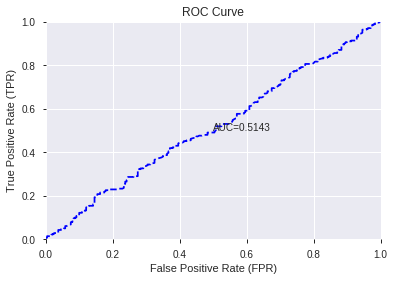

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


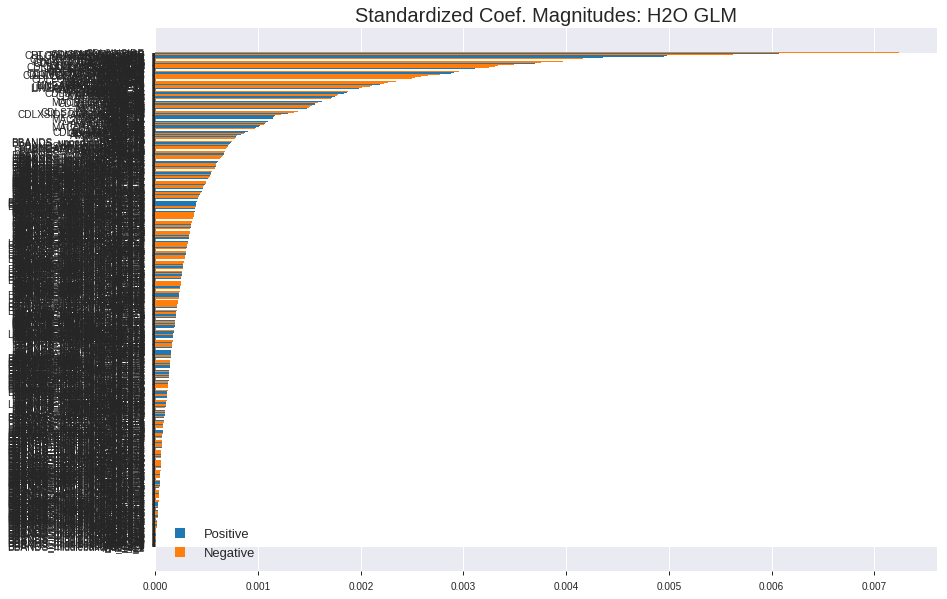

'log_likelihood'
--2019-08-25 13:35:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_133432_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_133432_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

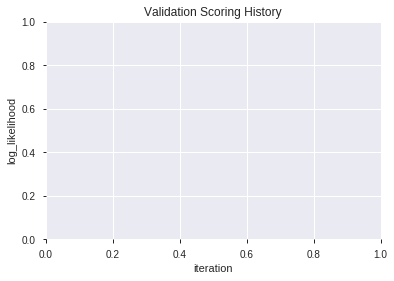

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190825_133620  0.530130  0.698565              0.495833  0.502217  0.252222
1  XGBoost_grid_1_AutoML_20190825_133620_model_7  0.528816  0.715546              0.497917  0.509648  0.259741
2  XGBoost_grid_1_AutoML_20190825_133620_model_5  0.521289  0.729542              0.493459  0.515396  0.265633
3  XGBoost_grid_1_AutoML_20190825_133620_model_3  0.518526  0.708771              0.493459  0.506541  0.256584
4               XGBoost_2_AutoML_20190825_133620  0.514434  0.710139              0.493459  0.507363  0.257417
5  XGBoost_grid_1_AutoML_20190825_133620_model_6  0.511544  0.713244              0.495833  0.508605  0.258679
6  XGBoost_grid_1_AutoML_20190825_133620_model_4  0.509401  0.701478              0.487209  0.503710  0.253724
7  XGBoost_grid_1_AutoML_20190825_133620_model_1  0.501964  0.711576              0.483378  0.507892  0.257954
8  XGBoost_grid_1_AutoML_20190825_133620_model_2  0.498619  0.699045              0.495833  0.502744  0.252751
9               XGBoost_1_AutoML_20190825_133620  0.496311  0.722852              0.500000  0.512967  0.263136

variable  relative_importance  scaled_importance  percentage
0                        OBV           210.201660           1.000000    0.029988
1                        BOP           187.548126           0.892230    0.026756
2       HT_PHASOR_quadrature           169.835800           0.807966    0.024229
3               STOCHF_fastk           118.280380           0.562700    0.016874
4                   WILLR_20            97.221428           0.462515    0.013870
..                       ...                  ...                ...         ...
306  BBANDS_upperband_12_2_3             1.905987           0.009067    0.000272
307               PLUS_DI_14             1.630069           0.007755    0.000233
308                   MOM_20             1.458414           0.006938    0.000208
309   BBANDS_lowerband_8_1_2             1.160400           0.005520    0.000166
310   BBANDS_lowerband_8_7_5             0.711510           0.003385    0.000102

[311 rows x 4 columns]

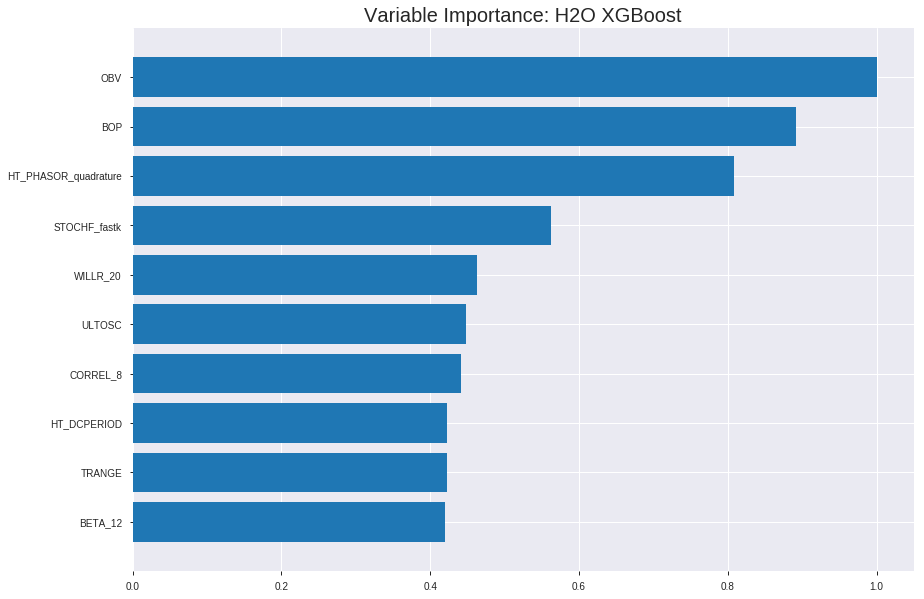

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190825_133620


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2042333276297537
RMSE: 0.4519218158373788
LogLoss: 0.5998822884754239
Mean Per-Class Error: 0.1736313958900646
AUC: 0.9087271990940111
pr_auc: 0.9159770531587014
Gini: 0.8174543981880222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5119823018709818: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1240  446   0.2645   (446.0/1686.0)
1      194   1748  0.0999   (194.0/1942.0)
Total  1434  2194  0.1764   (640.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511982     0.845261  234
max f2                       0.478592     0.900447  279
max f0point5                 0.544975     0.858263  187
max accuracy                 0.520812     0.828831  221
max precision                0.808171     1         0
max recall                   0.423108     1         341
max specificity              0.808171     1         0
max absolute_mcc             0.520812     0.655571  221
max min_per_class_accuracy   0.5289       0.821318  209
max mean_per_class_accuracy  0.522195     0.826369  219

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.713794           1.86818   1.86818            1                0.742198  1                           0.742198            0.0190525       0.0190525                  86.8177   86.8177
    2        0.0201213                   0.691188           1.86818   1.86818            1                0.699291  1                           0.721039            0.0185376       0.0375901                  86.8177   86.8177
    3        0.0300441                   0.676818           1.86818   1.86818            1                0.683207  1                           0.708544            0.0185376       0.0561277                  86.8177   86.8177
    4        0.0402426                   0.66335            1.86818   1.86818            1                0.669411  1                           0.698627            0.0190525       0.0751802                  86.8177   86.8177
    5        0.0501654                   0.65733            1.81628   1.85791            0.972222         0.66064   0.994505                    0.691113            0.0180227       0.0932029                  81.6283   85.7912
    6        0.100055                    0.628              1.81657   1.8373             0.972376         0.640566  0.983471                    0.665909            0.0906282       0.183831                   81.657    83.7298
    7        0.150221                    0.606098           1.77579   1.81676            0.950549         0.616265  0.972477                    0.649331            0.0890834       0.272915                   77.5795   81.6759
    8        0.20011                     0.593022           1.75464   1.80127            0.939227         0.599015  0.964187                    0.636786            0.0875386       0.360453                   75.4642   80.1273
    9        0.300165                    0.570791           1.63144   1.74466            0.873278         0.581569  0.933884                    0.618381            0.163234        0.523687                   63.1438   74.4661
    10       0.399945                    0.551918           1.54821   1.69565            0.828729         0.561556  0.90765                     0.604204            0.15448         0.678167                   54.8213   69.5651
    11       0.5                         0.53291            1.22487   1.60144            0.655647         0.542371  0.857222                    0.591831            0.122554        0.800721                   22.4865   60.1442
    12       0.600055                    0.512704           0.941808  1.49145            0.504132         0.522911  0.798346                    0.580339            0.0942327       0.894954                   -5.81917  49.1452
    13       0.699835                    0.492519           0.588321  1.36269            0.314917         0.503008  0.729421                    0.569313            0.0587024       0.953656                   -41.1679  36.2688
    14       0.79989                     0.467536           0.319083  1.23215            0.170799         0.480394  0.659545                    0.558191            0.0319258       0.985582                   -68.0917  23.2147
    15       0.899945                    0.436206           0.133809  1.11003            0.0716253        0.453     0.594181                    0.546496            0.0133883       0.99897                    -86.6191  11.0035
    16       1                           0.299004           0.010293  1                  0.00550964       0.404025  0.535281                    0.532241         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2557661757690907
RMSE: 0.5057333049830619
LogLoss: 0.7055098085270175
Mean Per-Class Error: 0.4817773600668338
AUC: 0.5066740511994271
pr_auc: 0.5083736291675013
Gini: 0.0133481023988542
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3738298714160919: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    504   1        (504.0/504.0)
1      0    532   0        (0.0/532.0)
Total  0    1036  0.4865   (504.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.37383      0.678571   399
max f2                       0.37383      0.840708   399
max f0point5                 0.424421     0.570175   374
max accuracy                 0.471353     0.523166   335
max precision                0.721467     0.538462   9
max recall                   0.37383      1          399
max specificity              0.786653     0.998016   0
max absolute_mcc             0.653113     0.0504816  56
max min_per_class_accuracy   0.55427      0.507519   203
max mean_per_class_accuracy  0.533035     0.518223   239

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 55.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.721957           0.885167  0.885167           0.454545         0.742988  0.454545                    0.742988            0.0093985       0.0093985                  -11.4833  -11.4833
    2        0.0202703                   0.701738           0.778947  0.834586           0.4              0.7125    0.428571                    0.72847             0.0075188       0.0169173                  -22.1053  -16.5414
    3        0.030888                    0.688093           1.0622    0.912829           0.545455         0.694688  0.46875                     0.716857            0.0112782       0.0281955                  6.2201    -8.71711
    4        0.0405405                   0.680165           0.973684  0.927318           0.5              0.683807  0.47619                     0.708988            0.0093985       0.037594                   -2.63158  -7.26817
    5        0.0501931                   0.675531           0.973684  0.936235           0.5              0.677724  0.480769                    0.702976            0.0093985       0.0469925                  -2.63158  -6.37652
    6        0.100386                    0.643265           0.936235  0.936235           0.480769         0.656972  0.480769                    0.679974            0.0469925       0.093985                   -6.37652  -6.37652
    7        0.150579                    0.620844           1.08603   0.986167           0.557692         0.630361  0.50641                     0.663437            0.0545113       0.148496                   8.60324   -1.38327
    8        0.200772                    0.609167           0.936235  0.973684           0.480769         0.614544  0.5                         0.651213            0.0469925       0.195489                   -6.37652  -2.63158
    9        0.300193                    0.589606           1.02095   0.989338           0.524272         0.599251  0.508039                    0.634004            0.101504        0.296992                   2.09504   -1.06617
    10       0.400579                    0.572522           1.16093   1.03234            0.596154         0.579114  0.53012                     0.620248            0.116541        0.413534                   16.0931   3.23399
    11       0.5                         0.55395            0.945324  1.01504            0.485437         0.563196  0.521236                    0.608904            0.093985        0.507519                   -5.46755  1.50376
    12       0.600386                    0.535765           1.04858   1.02065            0.538462         0.545201  0.524116                    0.598253            0.105263        0.612782                   4.8583    2.06465
    13       0.699807                    0.519239           0.945324  1.00995            0.485437         0.526919  0.518621                    0.588118            0.093985        0.706767                   -5.46755  0.994555
    14       0.800193                    0.499281           0.95496   1.00305            0.490385         0.509753  0.515078                    0.578287            0.0958647       0.802632                   -4.50405  0.304743
    15       0.899614                    0.47253            1.07767   1.01129            0.553398         0.486067  0.519313                    0.568096            0.107143        0.909774                   7.76699   1.12943
    16       1                           0.37383            0.898785  1                  0.461538         0.440109  0.513514                    0.5552


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:36:45  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.464719                         0.5                0.693147              0.5               0                    1                  0.486486
    2019-08-25 13:36:46  0.929 sec   5                  0.494252         0.681699            0.702517        0.729212           1.66621          0.379824                         0.500843           0.694842              0.485854          0.493672             0.885167           0.486486
    2019-08-25 13:36:46  1.240 sec   10                 0.488918         0.671152            0.767678        0.787089           1.81769          0.331863                         0.501794           0.696792              0.485242          0.490904             0.5311             0.484556
    2019-08-25 13:36:47  1.574 sec   15                 0.483722         0.66093             0.793383        0.810727           1.86818          0.290518                         0.502524           0.698322              0.485656          0.493094             0.486842           0.486486
    2019-08-25 13:36:47  1.887 sec   20                 0.478498         0.65073             0.829141        0.844238           1.86818          0.261852                         0.502415           0.69816               0.500034          0.501664             0.5311             0.484556
    2019-08-25 13:36:47  2.215 sec   25                 0.473312         0.640659            0.848725        0.859589           1.86818          0.241455                         0.503154           0.699743              0.501229          0.499774             0.5311             0.486486
    2019-08-25 13:36:47  2.550 sec   30                 0.468657         0.631675            0.865134        0.873968           1.86818          0.228501                         0.50394            0.701464              0.502068          0.499533             0.5311             0.485521
    2019-08-25 13:36:48  2.884 sec   35                 0.464069         0.622894            0.879708        0.887586           1.86818          0.202591                         0.503807           0.701235              0.508651          0.507869             0.708134           0.485521
    2019-08-25 13:36:48  3.227 sec   40                 0.459134         0.613526            0.894348        0.902271           1.86818          0.185777                         0.504794           0.703384              0.507107          0.507091             0.5311             0.486486
    2019-08-25 13:36:48  3.537 sec   45                 0.45578          0.607179            0.900912        0.908265           1.86818          0.179713                         0.505413           0.704726              0.504627          0.506112             1.0622             0.485521
    2019-08-25 13:36:49  3.865 sec   50                 0.451922         0.599882            0.908727        0.915977           1.86818          0.176406                         0.505733           0.70551               0.506674          0.508374             0.885167           0.486486

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
OBV                      210.20166015625        1.0                   0.02998778755670256
BOP                      187.54812622070312     0.8922295194114654    0.02675598927992985
HT_PHASOR_quadrature     169.83580017089844     0.8079660267414337    0.024229113562955172
STOCHF_fastk             118.28038024902344     0.5626995531866953    0.01687411465921407
WILLR_20                 97.22142791748047      0.4625150336358547    0.01386980257045315
---                      ---                    ---                   ---
BBANDS_upperband_12_2_3  1.9059867858886719     0.00906742023099098   0.0002719118715743044
PLUS_DI_14               1.6300687789916992     0.007754785465443108  0.00023254885908551273
MOM_20                   1.458414077758789      0.006938166314550991  0.0002080602574738251
BBANDS_lowerband_8_1_2   1.160400390625         0.00552041496609701   0.0001655450312281585
BBANDS_lowerband_8_7_5   0.7115097045898438     0.003384890985451564  0.00010150539177431907


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5568400770712909)

('F1', 0.7010050251256281)

('auc', 0.5301299283154122)

('logloss', 0.6985651675219688)

('mean_per_class_error', 0.46521057347670247)

('rmse', 0.502217463359615)

('mse', 0.2522223805033663)

xgboost prediction progress: |████████████████████████████████████████████| 100%


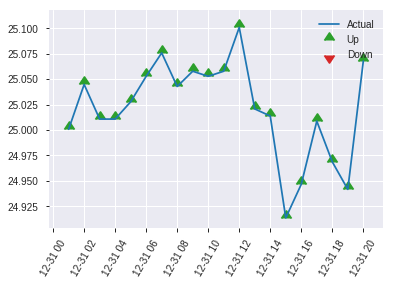


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2522223805033663
RMSE: 0.502217463359615
LogLoss: 0.6985651675219688
Mean Per-Class Error: 0.46521057347670247
AUC: 0.5301299283154122
pr_auc: 0.5514114601627224
Gini: 0.06025985663082434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41126251220703125: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    238  0.9917   (238.0/240.0)
1      0    279  0        (0.0/279.0)
Total  2    517  0.4586   (238.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.411263     0.701005   397
max f2                       0.411263     0.854256   397
max f0point5                 0.488732     0.600565   349
max accuracy                 0.488732     0.55684    349
max precision                0.724009     0.6        13
max recall                   0.411263     1          397
max specificity              0.764892     0.995833   0
max absolute_mcc             0.488732     0.0880584  349
max min_per_class_accuracy   0.587467     0.512545   195
max mean_per_class_accuracy  0.624483     0.534789   122

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 58.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.746746           0.620072  0.620072           0.333333         0.758123  0.333333                    0.758123            0.00716846      0.00716846                 -37.9928  -37.9928
    2        0.0211946                   0.733722           1.11613   0.845552           0.6              0.739926  0.454545                    0.749852            0.0107527       0.0179211                  11.6129   -15.4448
    3        0.0308285                   0.723031           1.48817   1.04637            0.8              0.726864  0.5625                      0.742668            0.0143369       0.0322581                  48.8172   4.6371
    4        0.0404624                   0.714576           1.11613   1.06298            0.6              0.719616  0.571429                    0.73718             0.0107527       0.0430108                  11.6129   6.298
    5        0.0500963                   0.706382           0.744086  1.00165            0.4              0.710908  0.538462                    0.732127            0.00716846      0.0501792                  -25.5914  0.165426
    6        0.100193                    0.682129           1.21629   1.10897            0.653846         0.694353  0.596154                    0.71324             0.0609319       0.111111                   21.6294   10.8974
    7        0.150289                    0.659186           0.858561  1.0255             0.461538         0.669651  0.551282                    0.698711            0.0430108       0.154122                   -14.1439  2.55032
    8        0.200385                    0.641767           1.00165   1.01954            0.538462         0.650097  0.548077                    0.686557            0.0501792       0.204301                   0.165426  1.95409
    9        0.300578                    0.622246           1.21629   1.08513            0.653846         0.630301  0.583333                    0.667805            0.121864        0.326165                   21.6294   8.51254
    10       0.400771                    0.606421           0.965881  1.05531            0.519231         0.61468   0.567308                    0.654524            0.0967742       0.422939                   -3.41191  5.53143
    11       0.500963                    0.586709           0.894334  1.02312            0.480769         0.596042  0.55                        0.642828            0.0896057       0.512545                   -10.5666  2.31183
    12       0.599229                    0.570117           1.05777   1.0288             0.568627         0.579073  0.553055                    0.632373            0.103943        0.616487                   5.77693   2.88006
    13       0.699422                    0.548433           1.0732    1.03516            0.576923         0.559951  0.556474                    0.621998            0.107527        0.724014                   7.3201    3.5161
    14       0.799615                    0.524105           0.930108  1.022              0.5              0.536112  0.549398                    0.611237            0.09319         0.817204                   -6.98925  2.19977
    15       0.899807                    0.484716           1.03743   1.02372            0.557692         0.505245  0.550321                    0.599435            0.103943        0.921147                   3.74276   2.37158
    16       1                           0.343774           0.787014  1                  0.423077         0.455059  0.537572                    0.584969          

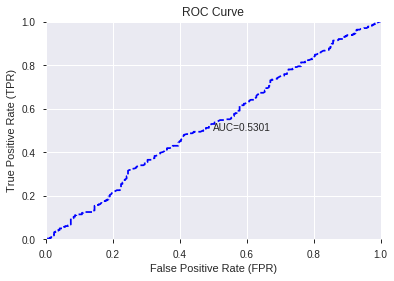

This function is available for GLM models only


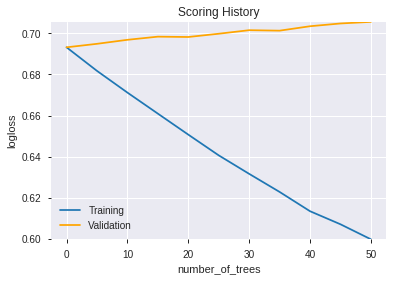

--2019-08-25 13:37:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190825_133620',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190825_133620',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b222',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_133846_model_3  0.534685  0.774072              0.476546  0.525346  0.275988
1  DeepLearning_grid_1_AutoML_20190825_133846_model_1  0.533587  0.984327              0.500000  0.552369  0.305111
2  DeepLearning_grid_1_AutoML_20190825_133846_model_5  0.521184  0.694206              0.497917  0.500542  0.250542
3  DeepLearning_grid_1_AutoML_20190825_133846_model_4  0.503196  0.723777              0.500000  0.512099  0.262246
4  DeepLearning_grid_1_AutoML_20190825_133846_model_8  0.496924  0.692341              0.500000  0.499584  0.249584
5  DeepLearning_grid_1_AutoML_20190825_133846_model_9  0.495923  0.690319              0.495833  0.498585  0.248587
6               DeepLearning_1_AutoML_20190825_133846  0.489710  0.715068              0.497917  0.509288  0.259375
7  DeepLearning_grid_1_AutoML_20190825_133846_model_6  0.487455  0.705232              0.489001  0.505202  0.255230
8  DeepLearning_grid_1_AutoML_20190825_133846_model_7  0.486783  0.872598              0.500000  0.548258  0.300587
9  DeepLearning_grid_1_AutoML_20190825_133846_model_2  0.485469  0.833442              0.500000  0.538818  0.290325

variable  relative_importance  scaled_importance  percentage
0           CDLHOMINGPIGEON             1.000000           1.000000    0.036079
1              CDLTHRUSTING             0.955850           0.955850    0.034486
2        CDLIDENTICAL3CROWS             0.930092           0.930092    0.033557
3        CDLEVENINGDOJISTAR             0.925754           0.925754    0.033401
4       CDLGAPSIDESIDEWHITE             0.924589           0.924589    0.033358
5         CDL3WHITESOLDIERS             0.911030           0.911030    0.032869
6          CDLSTICKSANDWICH             0.879630           0.879630    0.031736
7               CDLPIERCING             0.868551           0.868551    0.031337
8              CDLTASUKIGAP             0.821487           0.821487    0.029639
9            CDLMORNINGSTAR             0.817713           0.817713    0.029502
10                CDLONNECK             0.816865           0.816865    0.029472
11        CDLDARKCLOUDCOVER             0.795790           0.795790    0.028712
12           CDLEVENINGSTAR             0.792612           0.792612    0.028597
13         is_quarter_start             0.786235           0.786235    0.028367
14        CDLSTALLEDPATTERN             0.752576           0.752576    0.027152
15             is_month_end             0.685814           0.685814    0.024744
16           is_month_start             0.660650           0.660650    0.023836
17          CDLUNIQUE3RIVER             0.660142           0.660142    0.023817
18           CDL3BLACKCROWS             0.657644           0.657644    0.023727
19               CDL3INSIDE             0.655690           0.655690    0.023657
20       CDLMORNINGDOJISTAR             0.651439           0.651439    0.023503
21        CDLINVERTEDHAMMER             0.620033           0.620033    0.022370
22           CDLMATCHINGLOW             0.617215           0.617215    0.022269
23                    VAR_8             0.553287           0.553287    0.019962
24  BBANDS_upperband_30_6_5             0.500964           0.500964    0.018074
25           CDL3LINESTRIKE             0.485429           0.485429    0.017514
26                CORREL_30             0.474562           0.474562    0.017122
27          CDLSHOOTINGSTAR             0.460797           0.460797    0.016625
28          CDLADVANCEBLOCK             0.438705           0.438705    0.015828
29       CDLSEPARATINGLINES             0.416472           0.416472    0.015026
30                   VAR_12             0.395551           0.395551    0.014271
31                   VAR_20             0.390105           0.390105    0.014075
32                   VAR_24             0.386114           0.386114    0.013931
33                   Volume             0.368055           0.368055    0.013279
34                   VAR_14             0.358657           0.358657    0.012940
35            CDLHANGINGMAN             0.343335           0.343335    0.012387
36                   VAR_30             0.342521           0.342521    0.012358
37                      SUB             0.320729           0.320729    0.011572
38              CDLDOJISTAR             0.317376           0.317376    0.011451
39                   TRANGE             0.307174           0.307174    0.011083
40                      DIV             0.305948           0.305948    0.011038
41                CDLHAMMER             0.298035           0.298035    0.010753
42                STDDEV_14             0.291578           0.291578    0.010520
43        CDLGRAVESTONEDOJI             0.276828           0.276828    0.009988
44           CDLRICKSHAWMAN             0.268647           0.268647    0.009693
45                CDLHARAMI             0.263486           0.263486    0.009506
46                  CDLDOJI             0.253957           0.253957    0.009163
47        CDLLONGLEGGEDDOJI             0.245986           0.245986    0.008875
48                CDLTAKURI             0.235787           0.235787    0.008507
49         CDLDRAGO

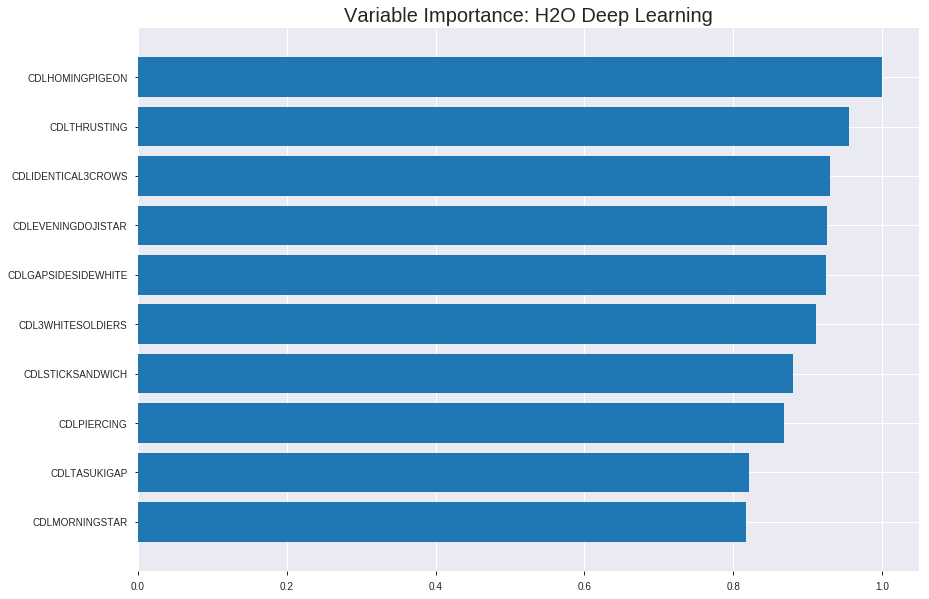

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_133846_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25326224191206304
RMSE: 0.5032516685636155
LogLoss: 0.7154749075378988
Mean Per-Class Error: 0.46338691569147017
AUC: 0.5484562392416863
pr_auc: 0.5768062004628167
Gini: 0.09691247848337259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0659251408410157: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      20   1666  0.9881   (1666.0/1686.0)
1      3    1939  0.0015   (3.0/1942.0)
Total  23   3605  0.46     (1669.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0659251    0.699117   386
max f2                       0.0473755    0.852522   390
max f0point5                 0.43366      0.596265   306
max accuracy                 0.443429     0.549338   300
max precision                0.998028     0.875      1
max recall                   0.0276534    1          396
max specificity              0.999807     0.998814   0
max absolute_mcc             0.594685     0.0769221  171
max min_per_class_accuracy   0.559631     0.527284   210
max mean_per_class_accuracy  0.562314     0.536613   205

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 57.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101985                   0.971563           1.36326   1.36326            0.72973          0.992199  0.72973                     0.992199            0.0139032       0.0139032                  36.3264    36.3264
    2        0.0201213                   0.940894           1.34924   1.35635            0.722222         0.959052  0.726027                    0.975853            0.0133883       0.0272915                  34.9239    35.6348
    3        0.0300441                   0.862772           0.778407  1.16547            0.416667         0.908013  0.623853                    0.953447            0.007724        0.0350154                  -22.1593   16.5468
    4        0.0402426                   0.797797           1.06032   1.13882            0.567568         0.826903  0.609589                    0.921378            0.0108136       0.045829                   6.03168    13.882
    5        0.0501654                   0.765858           1.14166   1.13938            0.611111         0.781119  0.60989                     0.893634            0.0113285       0.0571576                  14.1664    13.9383
    6        0.100055                    0.696995           1.19728   1.16825            0.640884         0.722253  0.625344                    0.808179            0.0597322       0.11689                    19.7285    16.8254
    7        0.150221                    0.656818           1.03674   1.12433            0.554945         0.67588   0.601835                    0.763999            0.0520082       0.168898                   3.67357    12.4334
    8        0.20011                     0.617728           1.10439   1.11936            0.59116          0.637262  0.599174                    0.732402            0.0550978       0.223996                   10.4392    11.9362
    9        0.300165                    0.579894           1.01901   1.08591            0.545455         0.595796  0.581267                    0.686866            0.101957        0.325953                   1.90057    8.59101
    10       0.399945                    0.564156           1.04246   1.07507            0.558011         0.570346  0.575465                    0.657797            0.104016        0.429969                   4.24635    7.50709
    11       0.5                         0.559589           0.993273  1.0587             0.53168          0.561717  0.566703                    0.63857             0.0993821       0.529351                   -0.672676  5.87024
    12       0.600055                    0.556137           0.98298   1.04608            0.526171         0.557824  0.559945                    0.625106            0.0983522       0.627703                   -1.70197   4.60762
    13       0.699835                    0.551598           0.980535  1.03673            0.524862         0.55404   0.554943                    0.614974            0.0978373       0.725541                   -1.9465    3.67316
    14       0.79989                     0.542449           0.952101  1.02615            0.509642         0.54813   0.549276                    0.606613            0.0952626       0.820803                   -4.78987   2.61455
    15       0.899945                    0.489587           0.967541  1.01963            0.517906         0.524195  0.545789                    0.597449            0.0968074       0.917611                   -3.24592   1.96299
    16       1                           0.0148573          0.823439  1                  0.440771         0.35924   0.535281                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2610061429320666
RMSE: 0.5108876030322781
LogLoss: 0.7406051048316254
Mean Per-Class Error: 0.4847013366750209
AUC: 0.5070526017424514
pr_auc: 0.5212086373413225
Gini: 0.01410520348490274
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0255289473420292: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    503   0.998    (503.0/504.0)
1      0    532   0        (0.0/532.0)
Total  1    1035  0.4855   (503.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0255289    0.679004   398
max f2                       0.0255289    0.840974   398
max f0point5                 0.343301     0.57058    369
max accuracy                 0.438954     0.521236   332
max precision                0.714316     0.627451   43
max recall                   0.0255289    1          398
max specificity              0.999956     0.998016   0
max absolute_mcc             0.687871     0.0572902  61
max min_per_class_accuracy   0.552442     0.507519   198
max mean_per_class_accuracy  0.687871     0.515299   61

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 55.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.941549           0.885167  0.885167           0.454545         0.983642  0.454545                    0.983642            0.0093985       0.0093985                  -11.4833  -11.4833
    2        0.0202703                   0.786712           0.973684  0.927318           0.5              0.845404  0.47619                     0.917815            0.0093985       0.018797                   -2.63158  -7.26817
    3        0.030888                    0.764384           1.5933    1.15625            0.818182         0.77465   0.59375                     0.868602            0.0169173       0.0357143                  59.3301   15.625
    4        0.0405405                   0.732006           0.973684  1.11278            0.5              0.742314  0.571429                    0.838533            0.0093985       0.0451128                  -2.63158  11.2782
    5        0.0501931                   0.712408           1.55789   1.19838            0.8              0.723238  0.615385                    0.816361            0.0150376       0.0601504                  55.7895   19.8381
    6        0.100386                    0.662826           1.01113   1.10476            0.519231         0.689092  0.567308                    0.752726            0.0507519       0.110902                   1.11336   10.4757
    7        0.150579                    0.625177           0.786437  0.99865            0.403846         0.641362  0.512821                    0.715605            0.0394737       0.150376                   -21.3563  -0.134953
    8        0.200772                    0.603485           1.12348   1.02986            0.576923         0.614341  0.528846                    0.690289            0.056391        0.206767                   12.3482   2.98583
    9        0.300193                    0.577966           0.983137  1.01438            0.504854         0.589679  0.5209                      0.656968            0.0977444       0.304511                   -1.68625  1.43848
    10       0.400579                    0.560401           1.06731   1.02765            0.548077         0.568435  0.527711                    0.634781            0.107143        0.411654                   6.73077   2.76474
    11       0.5                         0.551973           1.02095   1.02632            0.524272         0.555713  0.527027                    0.619059            0.101504        0.513158                   2.09504   2.63158
    12       0.600386                    0.545939           0.861336  0.998731           0.442308         0.549094  0.512862                    0.607361            0.0864662       0.599624                   -13.8664  -0.126925
    13       0.699807                    0.531239           0.945324  0.991143           0.485437         0.5396    0.508966                    0.597734            0.093985        0.693609                   -5.46755  -0.885662
    14       0.800193                    0.502781           1.01113   0.993651           0.519231         0.519517  0.510253                    0.587922            0.101504        0.795113                   1.11336   -0.63488
    15       0.899614                    0.453682           1.09658   1.00503            0.563107         0.484648  0.516094                    0.576508            0.109023        0.904135                   9.65764   0.502598
    16       1                           0.00595272         0.95496   1                  0.490385         0.36163   0.513514                    0.554938


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:41:36  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:41:43  2 min 55.815 sec  5715 obs/sec      10        1             36280      0.538566         0.903138            -0.166019      0.534094        0.557304           1.31277          0.459206                         0.569865           1.02043               -0.299936        0.493343          0.50811              1.0622             0.482625
    2019-08-25 13:41:51  3 min  4.231 sec  7478 obs/sec      30        3             108840     0.50566          0.733247            -0.0278857     0.54078         0.566849           1.21179          0.461136                         0.515647           0.818354              -0.0643436       0.50767           0.515155             1.0622             0.485521
    2019-08-25 13:41:58  3 min 11.313 sec  8480 obs/sec      50        5             181400     0.504023         0.7248              -0.0212399     0.542419        0.569896           1.31277          0.461411                         0.513137           0.766889              -0.0540084       0.500835          0.517778             0.885167           0.486486
    2019-08-25 13:42:05  3 min 17.983 sec  9115 obs/sec      70        7             253960     0.507019         0.745983            -0.0334175     0.532732        0.555023           1.21179          0.46086                          0.512764           0.800073              -0.0524756       0.514922          0.52344              1.0622             0.486486
    2019-08-25 13:42:11  3 min 24.387 sec  9589 obs/sec      90        9             326520     0.503252         0.715475            -0.0181182     0.548456        0.576806           1.36326          0.460033                         0.510888           0.740605              -0.0447877       0.507053          0.521209             0.885167           0.485521
    2019-08-25 13:42:17  3 min 30.461 sec  9996 obs/sec      110       11            399080     0.505213         0.736018            -0.0260701     0.546205        0.566779           1.21179          0.461136                         0.51277            0.773188              -0.0525021       0.508503          0.520519             0.885167           0.472973
    2019-08-25 13:42:23  3 min 36.445 sec  10323 obs/sec     130       13            471640     0.506149         0.753422            -0.0298752     0.547876        0.562025           1.21179          0.460033                         0.512421           0.820673              -0.0510683       0.507705          0.518348             1.23923            0.470077
    2019-08-25 13:42:29  3 min 42.265 sec  10606 obs/sec     150       15            544200     0.507647         0.744196            -0.0359818     0.528589        0.554513           1.11081          0.461411                         0.512802           0.783979              -0.0526317       0.512942          0.518144             0.5311             0.485521
    2019-08-25 13:42:29

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLHOMINGPIGEON      1.0                    1.0                  0.03607926095459607
CDLTHRUSTING         0.9558498859405518     0.9558498859405518   0.03448635746827006
CDLIDENTICAL3CROWS   0.9300919771194458     0.9300919771194458   0.03355703115426868
CDLEVENINGDOJISTAR   0.9257537126541138     0.9257537126541138   0.03340050977853392
CDLGAPSIDESIDEWHITE  0.924588680267334      0.924588680267334    0.03335847627103074
---                  ---                    ---                  ---
CDLHARAMI            0.26348572969436646    0.26348572969436646  0.00950637039945521
CDLDOJI              0.25395721197128296    0.25395721197128296  0.009162588522013588
CDLLONGLEGGEDDOJI    0.24598577618598938    0.24598577618598938  0.008874985010133176
CDLTAKURI            0.2357870191335678     0.2357870191335678   0.00850702139302633
CDLDRAGONFLYDOJI     0.22927160561084747    0.22927160561084747  0.008271950088313


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5568400770712909)

('F1', 0.7012987012987013)

('auc', 0.5346848864994026)

('logloss', 0.7740716353382293)

('mean_per_class_error', 0.45983422939068097)

('rmse', 0.525346060862858)

('mse', 0.2759884836641216)

deeplearning prediction progress: |███████████████████████████████████████| 100%


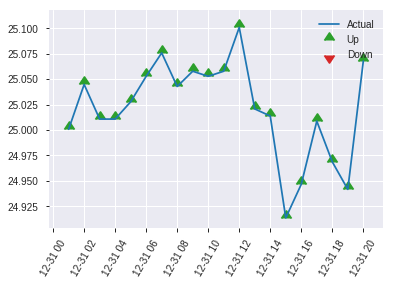


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2759884836641216
RMSE: 0.525346060862858
LogLoss: 0.7740716353382293
Mean Per-Class Error: 0.45983422939068097
AUC: 0.5346848864994026
pr_auc: 0.5726285067505862
Gini: 0.0693697729988052
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4322966079753007: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   221  0.9208   (221.0/240.0)
1      9    270  0.0323   (9.0/279.0)
Total  28   491  0.4432   (230.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432297     0.701299  374
max f2                       0.0882645    0.853211  399
max f0point5                 0.432297     0.601872  374
max accuracy                 0.432297     0.55684   374
max precision                0.999773     1         0
max recall                   0.0882645    1         399
max specificity              0.999773     1         0
max absolute_mcc             0.432297     0.103524  374
max min_per_class_accuracy   0.651265     0.512545  206
max mean_per_class_accuracy  0.736271     0.540166  128

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 65.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.97997            1.86022   1.86022            1                0.987722  1                           0.987722            0.0215054       0.0215054                  86.0215   86.0215
    2        0.0211946                   0.953462           0.744086  1.35288            0.4              0.962771  0.727273                    0.976381            0.00716846      0.0286738                  -25.5914  35.2884
    3        0.0308285                   0.941592           0.744086  1.16263            0.4              0.947225  0.625                       0.96727             0.00716846      0.0358423                  -25.5914  16.2634
    4        0.0404624                   0.92319            1.11613   1.15156            0.6              0.933564  0.619048                    0.959245            0.0107527       0.046595                   11.6129   15.1562
    5        0.0500963                   0.912745           0.744086  1.0732             0.4              0.915564  0.576923                    0.950844            0.00716846      0.0537634                  -25.5914  7.3201
    6        0.100193                    0.870203           1.0732    1.0732             0.576923         0.891924  0.576923                    0.921384            0.0537634       0.107527                   7.3201    7.3201
    7        0.150289                    0.822142           1.35939   1.1686             0.730769         0.843888  0.628205                    0.895552            0.0681004       0.175627                   35.9388   16.8597
    8        0.200385                    0.792517           1.00165   1.12686            0.538462         0.805878  0.605769                    0.873133            0.0501792       0.225806                   0.165426  12.6861
    9        0.300578                    0.73241            1.03743   1.09705            0.557692         0.759804  0.589744                    0.835357            0.103943        0.329749                   3.74276   9.70499
    10       0.400771                    0.681571           0.894334  1.04637            0.480769         0.705921  0.5625                      0.802998            0.0896057       0.419355                   -10.5666  4.6371
    11       0.500963                    0.646552           0.930108  1.02312            0.5              0.664424  0.55                        0.775283            0.09319         0.512545                   -6.98925  2.31183
    12       0.599229                    0.609363           0.91187   1.00488            0.490196         0.628635  0.540193                    0.751235            0.0896057       0.602151                   -8.81299  0.487501
    13       0.699422                    0.583166           1.0732    1.01466            0.576923         0.594862  0.545455                    0.728834            0.107527        0.709677                   7.3201    1.46628
    14       0.799615                    0.553515           1.03743   1.01752            0.557692         0.569692  0.546988                    0.708893            0.103943        0.81362                    3.74276   1.75152
    15       0.899807                    0.505513           0.965881  1.01177            0.519231         0.533353  0.543897                    0.689347            0.0967742       0.910394                   -3.41191  1.17658
    16       1                           0.0882645          0.894334  1                  0.480769         0.392126  0.537572                    0.659568           

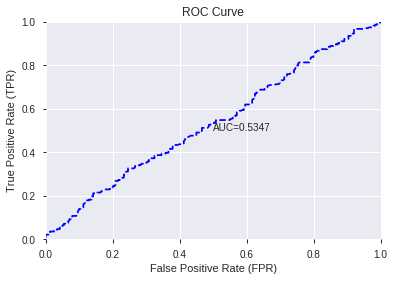

This function is available for GLM models only


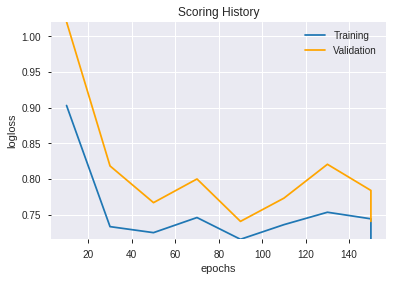

--2019-08-25 14:04:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_133846_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_133846_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'CDLIDENTICAL3CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDL3WHITESOLDIERS',
 'CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'is_quarter_start',
 'CDLSTALLEDPATTERN',
 'is_month_end',
 'is_month_start',
 'CDLUNIQUE3RIVER',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDLMORNINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'VAR_8',
 'BBANDS_upperband_30_6_5',
 'CDL3LINESTRIKE',
 'CORREL_30',
 'CDLSHOOTINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLSEPARATINGLINES',
 'VAR_12',
 'VAR_20',
 'VAR_24',
 'Volume',
 'VAR_14',
 'CDLHANGINGMAN',
 'VAR_30',
 'SUB',
 'CDLDOJISTAR',
 'TRANGE',
 'DIV',
 'CDLHAMMER',
 'STDDEV_14',
 'CDLGRAVESTONEDOJI',
 'CDLRICKSHAWMAN',
 'CDLHARAMI',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_140511_model_1  0.500568  0.690369                   0.5  0.498611  0.248613

variable  relative_importance  scaled_importance  percentage
0                CDL3INSIDE             0.008925           1.000000    0.063692
1              CDLTHRUSTING             0.006810           0.763061    0.048601
2       CDLGAPSIDESIDEWHITE             0.006344           0.710749    0.045269
3           CDLHOMINGPIGEON             0.006141           0.688063    0.043824
4                 CDLONNECK             0.005741           0.643257    0.040970
5            CDLMATCHINGLOW             0.005334           0.597636    0.038064
6         CDLGRAVESTONEDOJI             0.004912           0.550387    0.035055
7         CDLINVERTEDHAMMER             0.004904           0.549438    0.034995
8         CDLSTALLEDPATTERN             0.004744           0.531530    0.033854
9           CDLADVANCEBLOCK             0.004504           0.504597    0.032139
10        CDLDARKCLOUDCOVER             0.004067           0.455672    0.029022
11          CDLUNIQUE3RIVER             0.004026           0.451089    0.028731
12                CDLHAMMER             0.003804           0.426187    0.027145
13                   Volume             0.003792           0.424883    0.027061
14       CDLMORNINGDOJISTAR             0.003599           0.403247    0.025683
15           CDLRICKSHAWMAN             0.003586           0.401738    0.025587
16                CDLHARAMI             0.003543           0.396938    0.025282
17           CDL3BLACKCROWS             0.003542           0.396822    0.025274
18       CDLSEPARATINGLINES             0.003508           0.393014    0.025032
19             CDLTASUKIGAP             0.003467           0.388489    0.024743
20           CDLMORNINGSTAR             0.003212           0.359883    0.022922
21                  CDLDOJI             0.003155           0.353469    0.022513
22        CDLLONGLEGGEDDOJI             0.002695           0.301942    0.019231
23              CDLPIERCING             0.002630           0.294681    0.018769
24                   VAR_24             0.002554           0.286133    0.018224
25                    VAR_8             0.002538           0.284362    0.018112
26          CDLSHOOTINGSTAR             0.002331           0.261175    0.016635
27              CDLDOJISTAR             0.002241           0.251137    0.015995
28                   VAR_30             0.002210           0.247567    0.015768
29                   VAR_12             0.002116           0.237075    0.015100
30                   VAR_20             0.001926           0.215778    0.013743
31         CDLSTICKSANDWICH             0.001719           0.192579    0.012266
32                      DIV             0.001683           0.188620    0.012014
33             is_month_end             0.001646           0.184469    0.011749
34                      SUB             0.001644           0.184181    0.011731
35                   TRANGE             0.001274           0.142722    0.009090
36  BBANDS_upperband_30_6_5             0.001236           0.138523    0.008823
37            CDLHANGINGMAN             0.001004           0.112486    0.007164
38                STDDEV_14             0.000983           0.110139    0.007015
39           CDLEVENINGSTAR             0.000952           0.106634    0.006792
40                   VAR_14             0.000851           0.095375    0.006075
41       CDLIDENTICAL3CROWS             0.000768           0.086084    0.005483
42        CDL3WHITESOLDIERS             0.000641           0.071796    0.004573
43           CDL3LINESTRIKE             0.000586           0.065646    0.004181
44       CDLEVENINGDOJISTAR             0.000579           0.064904    0.004134
45                CORREL_30             0.000496           0.055542    0.003538
46         is_quarter_start             0.000402           0.045049    0.002869
47         CDLDRAGONFLYDOJI             0.000353           0.039595    0.002522
48                CDLTAKURI             0.000334           0.037378    0.002381
49           is_mon

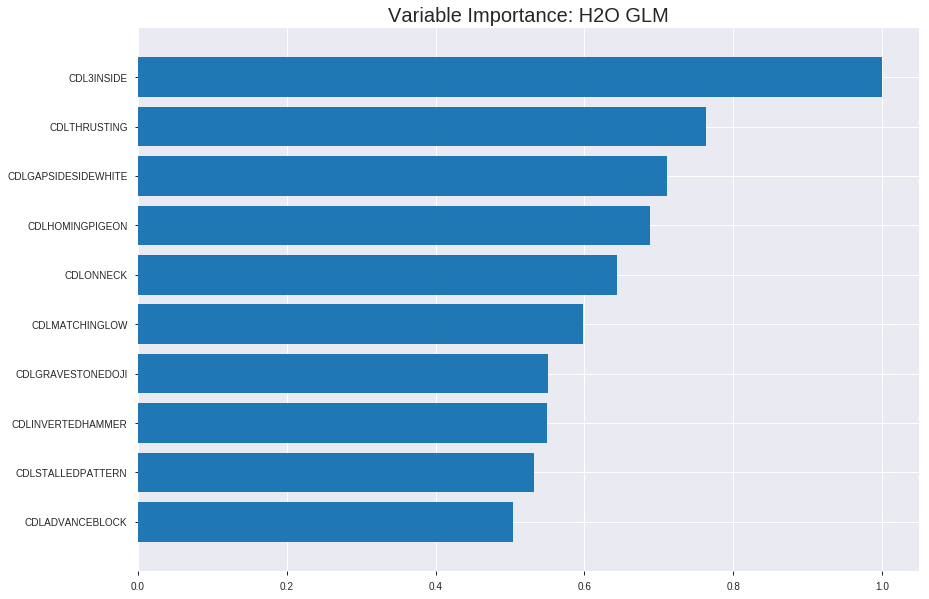

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_140511_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24814685816010235
RMSE: 0.49814341123827216
LogLoss: 0.6894321535959971
Null degrees of freedom: 3627
Residual degrees of freedom: 3577
Null deviance: 5011.396974952616
Residual deviance: 5002.519706492555
AIC: 5104.519706492555
AUC: 0.5414881504313099
pr_auc: 0.5754563899265482
Gini: 0.08297630086261987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5172323909582435: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      44   1642  0.9739   (1642.0/1686.0)
1      14   1928  0.0072   (14.0/1942.0)
Total  58   3570  0.4564   (1656.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517232     0.699565  359
max f2                       0.503396     0.852727  390
max f0point5                 0.52684      0.596954  317
max accuracy                 0.52684      0.549614  317
max precision                0.591344     1         0
max recall                   0.503396     1         390
max specificity              0.591344     1         0
max absolute_mcc             0.52684      0.085498  317
max min_per_class_accuracy   0.534878     0.524717  210
max mean_per_class_accuracy  0.534316     0.533838  227

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101985                   0.553282           1.41376   1.41376            0.756757         0.565318  0.756757                    0.565318            0.0144181       0.0144181                  41.3756    41.3756
    2        0.0201213                   0.548353           1.14166   1.27957            0.611111         0.550868  0.684932                    0.558192            0.0113285       0.0257467                  14.1664    27.9573
    3        0.0300441                   0.545406           1.08977   1.21689            0.583333         0.54649   0.651376                    0.554327            0.0108136       0.0365602                  8.977      21.6886
    4        0.0402426                   0.543854           1.21179   1.21559            0.648649         0.544662  0.650685                    0.551878            0.0123584       0.0489186                  21.1791    21.5595
    5        0.0501654                   0.542609           1.08977   1.19071            0.583333         0.543068  0.637363                    0.550135            0.0108136       0.0597322                  8.977      19.0706
    6        0.100055                    0.540526           1.14568   1.16825            0.61326          0.541393  0.625344                    0.545776            0.0571576       0.11689                    14.5678    16.8254
    7        0.150221                    0.538865           1.02647   1.12091            0.549451         0.53976   0.6                         0.543767            0.0514933       0.168383                   2.6471     12.0906
    8        0.20011                     0.537594           1.0115    1.09363            0.541436         0.538189  0.585399                    0.542376            0.0504634       0.218847                   1.14992    9.36299
    9        0.300165                    0.536221           1.00357   1.06361            0.53719          0.536828  0.56933                     0.540527            0.100412        0.319258                   0.356623   6.36087
    10       0.399945                    0.535398           1.01666   1.0519             0.544199         0.535789  0.56306                     0.539345            0.101442        0.4207                     1.66599    5.18957
    11       0.5                         0.534841           1.04474   1.05046            0.559229         0.535104  0.562293                    0.538496            0.104531        0.525232                   4.47382    5.04634
    12       0.600055                    0.534455           0.988127  1.04007            0.528926         0.534652  0.556729                    0.537855            0.0988671       0.624099                   -1.18732   4.00692
    13       0.699835                    0.534096           1.04246   1.04041            0.558011         0.534271  0.556912                    0.537344            0.104016        0.728115                   4.24635    4.04106
    14       0.79989                     0.533673           0.88005   1.02035            0.471074         0.533893  0.546175                    0.536913            0.0880536       0.816169                   -11.995    2.03517
    15       0.899945                    0.531923           0.993273  1.01734            0.53168          0.533213  0.544564                    0.536501            0.0993821       0.915551                   -0.672676  1.73412
    16       1                           0.473007           0.844025  1                  0.451791         0.524307  0.535281                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2504018646095857
RMSE: 0.5004017032440894
LogLoss: 0.6939552231208593
Null degrees of freedom: 1035
Residual degrees of freedom: 985
Null deviance: 1437.4140588309256
Residual deviance: 1437.8752223064205
AIC: 1539.8752223064205
AUC: 0.4975888381668457
pr_auc: 0.5070842206079643
Gini: -0.004822323666308637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4935946924876051: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    503   0.998    (503.0/504.0)
1      0    532   0        (0.0/532.0)
Total  1    1035  0.4855   (503.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.493595     0.679004   398
max f2                       0.493595     0.840974   398
max f0point5                 0.493595     0.569349   398
max accuracy                 0.533548     0.527992   277
max precision                0.590993     1          0
max recall                   0.493595     1          398
max specificity              0.590993     1          0
max absolute_mcc             0.537964     0.0643773  137
max min_per_class_accuracy   0.535605     0.505639   207
max mean_per_class_accuracy  0.533548     0.519893   277

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 53.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.549373           1.23923   1.23923            0.636364         0.560445  0.636364                    0.560445            0.0131579       0.0131579                  23.9234   23.9234
    2        0.0202703                   0.54644            0.778947  1.02005            0.4              0.547567  0.52381                     0.554313            0.0075188       0.0206767                  -22.1053  2.00501
    3        0.030888                    0.545538           1.0622    1.03454            0.545455         0.545951  0.53125                     0.551438            0.0112782       0.0319549                  6.2201    3.45395
    4        0.0405405                   0.544683           1.36316   1.11278            0.7              0.545049  0.571429                    0.549917            0.0131579       0.0451128                  36.3158   11.2782
    5        0.0501931                   0.543392           0.973684  1.08603            0.5              0.544128  0.557692                    0.548804            0.0093985       0.0545113                  -2.63158  8.60324
    6        0.100386                    0.541457           0.748988  0.91751            0.384615         0.542243  0.471154                    0.545523            0.037594        0.0921053                  -25.1012  -8.24899
    7        0.150579                    0.540013           1.01113   0.948718           0.519231         0.54063   0.487179                    0.543892            0.0507519       0.142857                   1.11336   -5.12821
    8        0.200772                    0.538939           0.711538  0.889423           0.365385         0.539402  0.456731                    0.54277             0.0357143       0.178571                   -28.8462  -11.0577
    9        0.300193                    0.537431           1.02095   0.932984           0.524272         0.538138  0.4791                      0.541236            0.101504        0.280075                   2.09504   -6.70164
    10       0.400579                    0.536376           1.10476   0.97603            0.567308         0.536803  0.501205                    0.540125            0.110902        0.390977                   10.4757   -2.39696
    11       0.5                         0.535596           1.1533    1.01128            0.592233         0.535932  0.519305                    0.539291            0.114662        0.505639                   15.3296   1.12782
    12       0.600386                    0.534924           1.02986   1.01438            0.528846         0.535223  0.5209                      0.538611            0.103383        0.609023                   2.98583   1.43848
    13       0.699807                    0.534288           1.00204   1.01263            0.514563         0.534611  0.52                        0.538042            0.0996241       0.708647                   0.204394  1.26316
    14       0.800193                    0.533542           1.10476   1.02419            0.567308         0.533914  0.525935                    0.537525            0.110902        0.819549                   10.4757   2.41889
    15       0.899614                    0.530816           0.775166  0.996668           0.398058         0.532814  0.511803                    0.537004            0.0770677       0.896617                   -22.4834  -0.333183
    16       1                           0.477396           1.02986   1                  0.528846         0.524823  0.513514                    0.535781  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 14:05:12  0.000 sec   2            2         51            1.37886           1.38791
    2019-08-25 14:05:12  0.014 sec   4            1.2       51            1.37776           1.38825
    2019-08-25 14:05:12  0.029 sec   6            0.75      51            1.37637           1.38882
    2019-08-25 14:05:12  0.048 sec   8            0.47      51            1.3748            1.38977
    2019-08-25 14:05:12  0.067 sec   10           0.29      51            1.37322           1.39117

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5414258188824663)

('F1', 0.6992481203007519)

('auc', 0.5005675029868578)

('logloss', 0.6903688659415634)

('mean_per_class_error', 0.47280465949820794)

('rmse', 0.49861148423989327)

('mse', 0.24861341221590932)

glm prediction progress: |████████████████████████████████████████████████| 100%


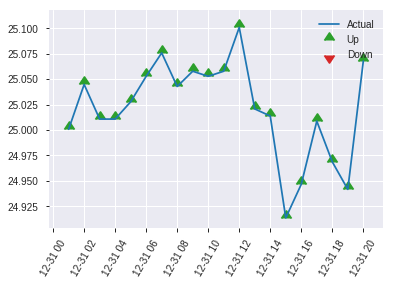


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24861341221590932
RMSE: 0.49861148423989327
LogLoss: 0.6903688659415634
Null degrees of freedom: 518
Residual degrees of freedom: 468
Null deviance: 716.5643274932833
Residual deviance: 716.6028828473428
AIC: 818.6028828473428
AUC: 0.5005675029868578
pr_auc: 0.543414654396959
Gini: 0.0011350059737156304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4952548307944232: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    240  1        (240.0/240.0)
1      0    279  0        (0.0/279.0)
Total  0    519  0.4624   (240.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.495255     0.699248   399
max f2                       0.495255     0.853211   399
max f0point5                 0.526606     0.594059   391
max accuracy                 0.526857     0.541426   389
max precision                0.589506     1          0
max recall                   0.495255     1          399
max specificity              0.589506     1          0
max absolute_mcc             0.541475     0.0692609  84
max min_per_class_accuracy   0.536862     0.495833   211
max mean_per_class_accuracy  0.541033     0.527195   92

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 53.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.552988           1.24014   1.24014            0.666667         0.56193   0.666667                    0.56193             0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.549649           0.744086  1.01466            0.4              0.551326  0.545455                    0.55711             0.00716846      0.0215054                  -25.5914  1.46628
    3        0.0308285                   0.54786            1.11613   1.04637            0.6              0.548406  0.5625                      0.55439             0.0107527       0.0322581                  11.6129   4.6371
    4        0.0404624                   0.547004           0         0.797235           0                0.547605  0.428571                    0.552774            0               0.0322581                  -100      -20.2765
    5        0.0500963                   0.54607            0.744086  0.787014           0.4              0.546416  0.423077                    0.551552            0.00716846      0.0394265                  -25.5914  -21.2986
    6        0.100193                    0.543598           1.21629   1.00165            0.653846         0.544952  0.538462                    0.548252            0.0609319       0.100358                   21.6294   0.165426
    7        0.150289                    0.542264           1.28784   1.09705            0.692308         0.542946  0.589744                    0.546483            0.0645161       0.164875                   28.7841   9.70499
    8        0.200385                    0.541171           1.14475   1.10897            0.615385         0.54164   0.596154                    0.545272            0.0573477       0.222222                   14.4748   10.8974
    9        0.300578                    0.539164           0.787014  1.00165            0.423077         0.540092  0.538462                    0.543546            0.078853        0.301075                   -21.2986  0.165426
    10       0.400771                    0.537762           1.0732    1.01954            0.576923         0.538474  0.548077                    0.542278            0.107527        0.408602                   7.3201    1.95409
    11       0.500963                    0.536862           0.894334  0.9945             0.480769         0.537336  0.534615                    0.541289            0.0896057       0.498208                   -10.5666  -0.550041
    12       0.599229                    0.535797           1.05777   1.00488            0.568627         0.536326  0.540193                    0.540475            0.103943        0.602151                   5.77693   0.487501
    13       0.699422                    0.535127           0.787014  0.973666           0.423077         0.535455  0.523416                    0.539756            0.078853        0.681004                   -21.2986  -2.63337
    14       0.799615                    0.534129           1.03743   0.981656           0.557692         0.53472   0.527711                    0.539125            0.103943        0.784946                   3.74276   -1.83443
    15       0.899807                    0.531968           1.03743   0.987866           0.557692         0.532951  0.531049                    0.538438            0.103943        0.888889                   3.74276   -1.21342
    16       1                           0.495255           1.10897   1                  0.596154         0.527783  0.537572                    0.53737 

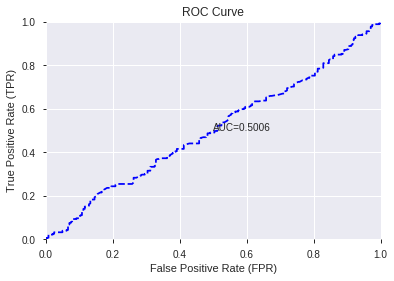

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


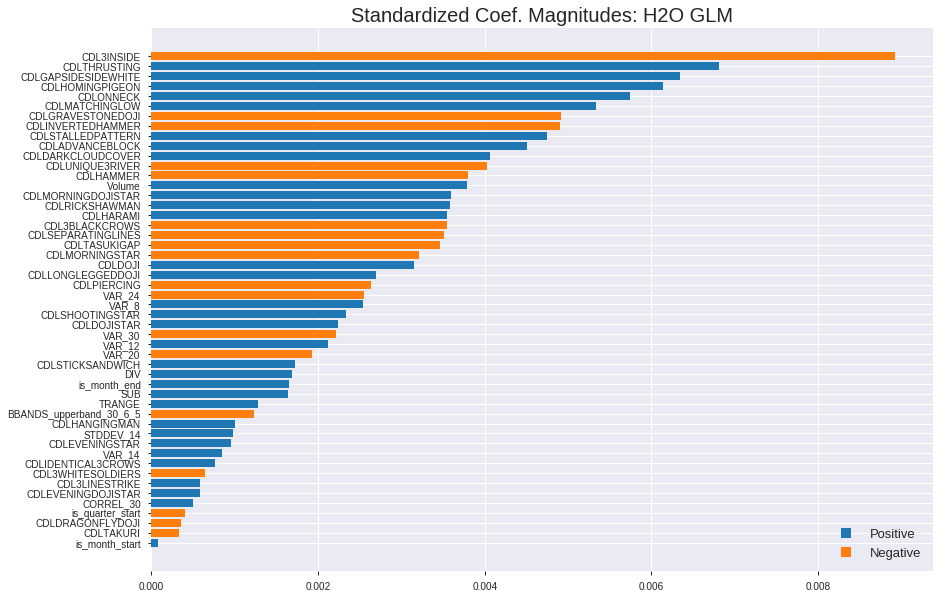

'log_likelihood'
--2019-08-25 14:05:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_140511_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_140511_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDL3INSIDE',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLHOMINGPIGEON',
 'CDLONNECK',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CDLSTALLEDPATTERN',
 'CDLADVANCEBLOCK',
 'CDLDARKCLOUDCOVER',
 'CDLUNIQUE3RIVER',
 'CDLHAMMER',
 'Volume',
 'CDLMORNINGDOJISTAR',
 'CDLRICKSHAWMAN',
 'CDLHARAMI',
 'CDL3BLACKCROWS',
 'CDLSEPARATINGLINES',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLPIERCING',
 'VAR_24',
 'VAR_8',
 'CDLSHOOTINGSTAR',
 'CDLDOJISTAR',
 'VAR_30',
 'VAR_12',
 'VAR_20',
 'CDLSTICKSANDWICH',
 'DIV',
 'is_month_end',
 'SUB',
 'TRANGE',
 'BBANDS_upperband_30_6_5',
 'CDLHANGINGMAN',
 'STDDEV_14',
 'CDLEVENINGSTAR',
 'VAR_14',
 'CDLIDENTICAL3CROWS',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLEVENINGDOJISTAR',
 'CORREL_30',
 'is_quarter_start',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_month_start']

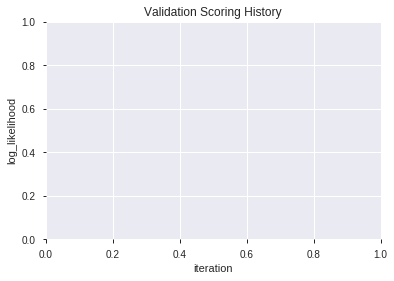

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_140618_model_1  0.492040  0.698144              0.500000  0.502415  0.252421
1  XGBoost_grid_1_AutoML_20190825_140618_model_2  0.489568  0.696265              0.500000  0.501515  0.251517
2               XGBoost_1_AutoML_20190825_140618  0.489524  0.706767              0.500000  0.506490  0.256532
3  XGBoost_grid_1_AutoML_20190825_140618_model_5  0.488695  0.731529              0.500000  0.516788  0.267070
4               XGBoost_3_AutoML_20190825_140618  0.487059  0.700605              0.500000  0.503571  0.253584
5               XGBoost_2_AutoML_20190825_140618  0.482930  0.710939              0.500000  0.508413  0.258483
6  XGBoost_grid_1_AutoML_20190825_140618_model_3  0.480369  0.703649              0.500000  0.505053  0.255079
7  XGBoost_grid_1_AutoML_20190825_140618_model_7  0.477681  0.713089              0.500000  0.509325  0.259412
8  XGBoost_grid_1_AutoML_20190825_140618_model_6  0.463068  0.705167              0.497917  0.505867  0.255901
9  XGBoost_grid_1_AutoML_20190825_140618_model_4  0.443474  0.701153              0.497917  0.503916  0.253932

variable  relative_importance  scaled_importance  percentage
0                    TRANGE           291.873077           1.000000    0.114906
1                     VAR_8           279.790466           0.958603    0.110150
2                 CORREL_30           277.086670           0.949340    0.109085
3   BBANDS_upperband_30_6_5           256.802063           0.879842    0.101099
4                    Volume           240.727295           0.824767    0.094771
5                    VAR_20           214.941757           0.736422    0.084619
6                    VAR_30           170.009705           0.582478    0.066930
7                    VAR_12           152.871536           0.523760    0.060183
8                       DIV           148.938919           0.510287    0.058635
9                 STDDEV_14           107.148354           0.367106    0.042183
10               CDL3INSIDE            92.177055           0.315812    0.036289
11                   VAR_24            86.794807           0.297372    0.034170
12                      SUB            75.822319           0.259778    0.029850
13           CDLMATCHINGLOW            36.885872           0.126376    0.014521
14        CDLLONGLEGGEDDOJI            27.678574           0.094831    0.010897
15                   VAR_14            22.853445           0.078299    0.008997
16                  CDLDOJI            20.028646           0.068621    0.007885
17           CDLRICKSHAWMAN            16.547552           0.056694    0.006515
18                CDLHARAMI             9.573894           0.032802    0.003769
19         CDLDRAGONFLYDOJI             4.125307           0.014134    0.001624
20                CDLHAMMER             2.983645           0.010222    0.001175
21          CDLADVANCEBLOCK             2.764124           0.009470    0.001088
22        CDLGRAVESTONEDOJI             1.672215           0.005729    0.000658

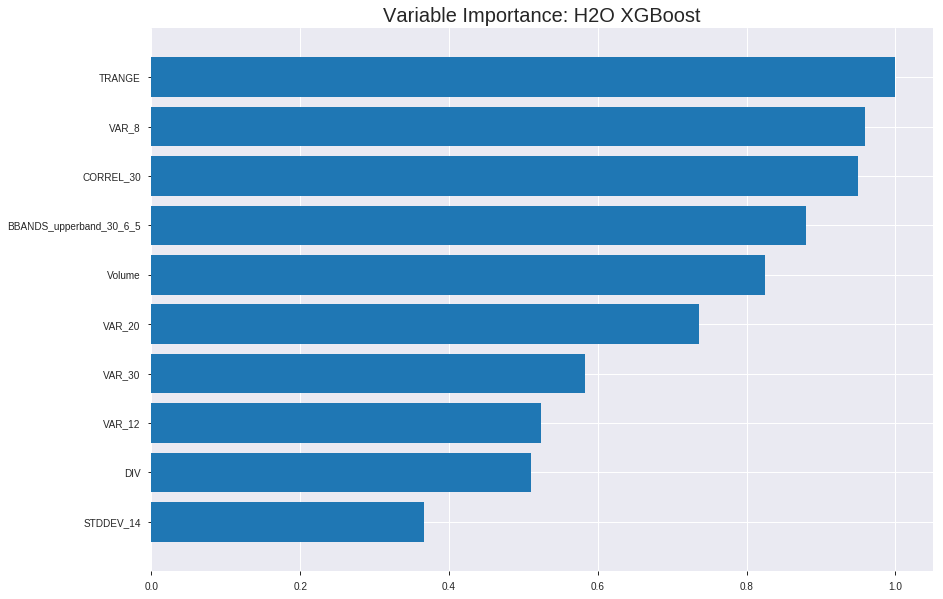

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_140618_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23195384618430287
RMSE: 0.48161586994647804
LogLoss: 0.6566018452841258
Mean Per-Class Error: 0.31265812965073736
AUC: 0.7535790290915798
pr_auc: 0.7715675099011728
Gini: 0.5071580581831596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5111477110120985: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      609  1077  0.6388   (1077.0/1686.0)
1      171  1771  0.0881   (171.0/1942.0)
Total  780  2848  0.344    (1248.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511148     0.739457  238
max f2                       0.481777     0.858034  289
max f0point5                 0.538167     0.713304  173
max accuracy                 0.537743     0.68495   174
max precision                0.740124     1         0
max recall                   0.335361     1         389
max specificity              0.740124     1         0
max absolute_mcc             0.537743     0.37407   174
max min_per_class_accuracy   0.535288     0.679197  179
max mean_per_class_accuracy  0.537743     0.687342  174

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.640145           1.81769   1.81769            0.972973         0.661737  0.972973                    0.661737            0.0185376       0.0185376                  81.7686   81.7686
    2        0.0201213                   0.624128           1.76439   1.7914             0.944444         0.630853  0.958904                    0.646506            0.0175077       0.0360453                  76.439    79.1403
    3        0.0300441                   0.61404            1.6606    1.7482             0.888889         0.618641  0.93578                     0.637303            0.0164779       0.0525232                  66.0602   74.8202
    4        0.0402426                   0.607594           1.66621   1.72742            0.891892         0.610439  0.924658                    0.630495            0.0169928       0.069516                   66.6212   72.7424
    5        0.050441                    0.602838           1.61572   1.70484            0.864865         0.605109  0.912568                    0.625362            0.0164779       0.0859938                  61.5721   70.4839
    6        0.100055                    0.58317            1.5153    1.61085            0.811111         0.592132  0.862259                    0.608885            0.0751802       0.161174                   51.5299   61.0852
    7        0.150221                    0.57134            1.62182   1.61452            0.868132         0.576601  0.86422                     0.598104            0.0813594       0.242533                   62.1824   61.4516
    8        0.20011                     0.562525           1.53789   1.59541            0.823204         0.566244  0.853994                    0.590161            0.076725        0.319258                   53.7892   59.5413
    9        0.300165                    0.548883           1.29177   1.4942             0.69146          0.55541   0.799816                    0.578577            0.129248        0.448507                   29.177    49.4199
    10       0.399945                    0.541574           1.13536   1.40467            0.607735         0.545063  0.751895                    0.570216            0.113285        0.561792                   13.5356   40.4674
    11       0.5                         0.535858           1.09106   1.34192            0.584022         0.539065  0.718302                    0.563982            0.109166        0.670958                   9.10566   34.1916
    12       0.600055                    0.528811           0.910929  1.27005            0.487603         0.532442  0.679835                    0.558723            0.0911432       0.762101                   -8.90707  27.0052
    13       0.699835                    0.520788           0.861839  1.21185            0.461326         0.525027  0.648681                    0.553919            0.0859938       0.848095                   -13.8161  21.185
    14       0.79989                     0.50877            0.725656  1.15103            0.38843          0.514935  0.616127                    0.549043            0.0726056       0.9207                     -27.4344  15.1034
    15       0.899945                    0.4854             0.535235  1.08257            0.286501         0.497852  0.579479                    0.543351            0.053553        0.974253                   -46.4765  8.257
    16       1                           0.295558           0.257325  1                  0.137741         0.4355    0.535281                    0.53256             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2528135060075948
RMSE: 0.5028056344230788
LogLoss: 0.6989258473914788
Mean Per-Class Error: 0.47744360902255645
AUC: 0.49747135696383815
pr_auc: 0.5173687138827953
Gini: -0.005057286072323697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3428107798099518: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    502   0.996    (502.0/504.0)
1      0    532   0        (0.0/532.0)
Total  2    1034  0.4846   (502.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.342811     0.679438   397
max f2                       0.342811     0.84124    397
max f0point5                 0.342811     0.569837   397
max accuracy                 0.497638     0.519305   343
max precision                0.727532     1          0
max recall                   0.342811     1          397
max specificity              0.727532     1          0
max absolute_mcc             0.589007     0.0605968  99
max min_per_class_accuracy   0.544139     0.492063   211
max mean_per_class_accuracy  0.589007     0.522556   99

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 54.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0106178                   0.667195           1.0622    1.0622             0.545455         0.684072  0.545455                    0.684072            0.0112782       0.0112782                  6.2201     6.2201
    2        0.0202703                   0.655971           0.973684  1.02005            0.5              0.660869  0.52381                     0.673023            0.0093985       0.0206767                  -2.63158   2.00501
    3        0.030888                    0.64724            1.0622    1.03454            0.545455         0.651522  0.53125                     0.665632            0.0112782       0.0319549                  6.2201     3.45395
    4        0.0405405                   0.63909            0.973684  1.02005            0.5              0.643092  0.52381                     0.660266            0.0093985       0.0413534                  -2.63158   2.00501
    5        0.0501931                   0.632078           0.973684  1.01113            0.5              0.635431  0.519231                    0.65549             0.0093985       0.0507519                  -2.63158   1.11336
    6        0.100386                    0.603811           1.12348   1.06731            0.576923         0.617254  0.548077                    0.636372            0.056391        0.107143                   12.3482    6.73077
    7        0.150579                    0.592397           1.19838   1.111              0.615385         0.598511  0.570513                    0.623752            0.0601504       0.167293                   19.8381    11.0999
    8        0.200772                    0.581366           1.01113   1.08603            0.519231         0.586873  0.557692                    0.614532            0.0507519       0.218045                   1.11336    8.60324
    9        0.300193                    0.566388           0.718447  0.964292           0.368932         0.573617  0.495177                    0.600981            0.0714286       0.289474                   -28.1553   -3.57082
    10       0.400579                    0.553117           0.973684  0.966646           0.5              0.55908   0.496386                    0.590481            0.0977444       0.387218                   -2.63158   -3.33545
    11       0.5                         0.544061           1.05876   0.984962           0.543689         0.548021  0.505792                    0.582038            0.105263        0.492481                   5.87634    -1.50376
    12       0.600386                    0.535933           1.04858   0.9956             0.538462         0.539862  0.511254                    0.574986            0.105263        0.597744                   4.8583     -0.440007
    13       0.699807                    0.529209           0.964231  0.991143           0.495146         0.5326    0.508966                    0.568965            0.0958647       0.693609                   -3.5769    -0.885662
    14       0.800193                    0.517993           1.12348   1.00775            0.576923         0.524028  0.517491                    0.563327            0.112782        0.806391                   12.3482    0.774554
    15       0.899614                    0.503597           0.945324  1.00085            0.485437         0.511468  0.513948                    0.557596            0.093985        0.900376                   -5.46755   0.0847075
    16       1                           0.327768           0.992409  1                  0.509615         0.472565  0.513514           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:06:24  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.464719                         0.5                0.693147              0.5               0                    1                  0.486486
    2019-08-25 14:06:24  0.082 sec   5                  0.497882         0.688915            0.595689        0.63012            1.61572          0.443219                         0.49982            0.692788              0.497367          0.518248             1.13596            0.486486
    2019-08-25 14:06:24  0.120 sec   10                 0.496127         0.685404            0.614404        0.64712            1.7167           0.428335                         0.499891           0.692932              0.505014          0.521042             1.07105            0.486486
    2019-08-25 14:06:24  0.163 sec   15                 0.494185         0.681529            0.646229        0.676039           1.76719          0.41538                          0.500071           0.693302              0.508481          0.521882             1.09539            0.482625
    2019-08-25 14:06:24  0.210 sec   20                 0.492341         0.677859            0.673382        0.698723           1.7167           0.374587                         0.500679           0.694533              0.50042           0.517817             0.885167           0.484556
    2019-08-25 14:06:24  0.260 sec   25                 0.490182         0.673568            0.698961        0.720033           1.7167           0.365491                         0.500944           0.695075              0.503614          0.519822             0.885167           0.484556
    2019-08-25 14:06:24  0.320 sec   30                 0.48889          0.670986            0.699177        0.720249           1.76719          0.374862                         0.501473           0.696146              0.498835          0.52019              1.29825            0.484556
    2019-08-25 14:06:24  0.387 sec   35                 0.486787         0.666819            0.723789        0.740448           1.7167           0.35419                          0.502005           0.697241              0.49551           0.518495             1.0622             0.484556
    2019-08-25 14:06:24  0.446 sec   40                 0.485006         0.663304            0.738231        0.755319           1.76719          0.359151                         0.502245           0.697746              0.496187          0.516507             0.885167           0.484556
    2019-08-25 14:06:24  0.505 sec   45                 0.483635         0.660585            0.742742        0.760226           1.81769          0.333241                         0.502394           0.698061              0.498715          0.517491             1.0622             0.483591
    2019-08-25 14:06:24  0.575 sec   50                 0.481616         0.656602            0.753579        0.771568           1.81769          0.343991                         0.502806           0.698926              0.497471          0.517369             1.0622             0.484556

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
TRANGE                   291.8730773925781      1.0                   0.11490625877224743
VAR_8                    279.79046630859375     0.95860320111768      0.11014950748753288
CORREL_30                277.086669921875       0.9493395978731709    0.10908506149595588
BBANDS_upperband_30_6_5  256.80206298828125     0.8798415574413351    0.10109930167793124
Volume                   240.727294921875       0.8247670428269391    0.09477089524989354
---                      ---                    ---                   ---
CDLHARAMI                9.573893547058105      0.03280156440801468   0.003769105048001876
CDLDRAGONFLYDOJI         4.125306606292725      0.014133905885207982  0.0016240742471082992
CDLHAMMER                2.98364520072937       0.01022240635341737   0.0011746184697208424
CDLADVANCEBLOCK          2.7641239166259766     0.009470294215962051  0.0010881960778286535
CDLGRAVESTONEDOJI        1.672215223312378      0.005729254778313102  0.0006583272321289803


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5414258188824663)

('F1', 0.6992481203007519)

('auc', 0.49204002389486257)

('logloss', 0.6981435740935095)

('mean_per_class_error', 0.4713037634408602)

('rmse', 0.5024151544181381)

('mse', 0.2524209873890016)

xgboost prediction progress: |████████████████████████████████████████████| 100%


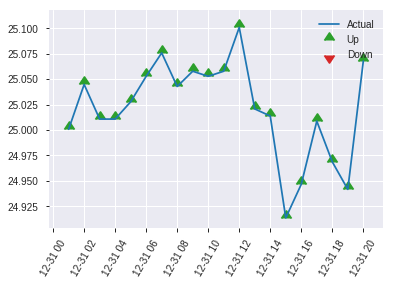


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2524209873890016
RMSE: 0.5024151544181381
LogLoss: 0.6981435740935095
Mean Per-Class Error: 0.4713037634408602
AUC: 0.49204002389486257
pr_auc: 0.527660858871129
Gini: -0.015919952210274868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4090169072151184: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    240  1        (240.0/240.0)
1      0    279  0        (0.0/279.0)
Total  0    519  0.4624   (240.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409017     0.699248  399
max f2                       0.409017     0.853211  399
max f0point5                 0.409017     0.592357  399
max accuracy                 0.511115     0.541426  304
max precision                0.672145     1         0
max recall                   0.409017     1         399
max specificity              0.672145     1         0
max absolute_mcc             0.43811      0.101888  389
max min_per_class_accuracy   0.540161     0.505376  202
max mean_per_class_accuracy  0.536336     0.528696  218

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.645735           1.24014   1.24014            0.666667         0.658595  0.666667                    0.658595            0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.635248           1.11613   1.18377            0.6              0.641749  0.636364                    0.650938            0.0107527       0.0250896                  11.6129   18.3773
    3        0.0308285                   0.630796           0.744086  1.04637            0.4              0.633032  0.5625                      0.645342            0.00716846      0.0322581                  -25.5914  4.6371
    4        0.0423892                   0.627435           0.620072  0.930108           0.333333         0.628721  0.5                         0.640809            0.00716846      0.0394265                  -37.9928  -6.98925
    5        0.0500963                   0.623803           1.39516   1.00165            0.75             0.626878  0.538462                    0.638666            0.0107527       0.0501792                  39.5161   0.165426
    6        0.1079                      0.606917           0.744086  0.863671           0.4              0.612061  0.464286                    0.624413            0.0430108       0.09319                    -25.5914  -13.6329
    7        0.152216                    0.591708           0.808789  0.847693           0.434783         0.598802  0.455696                    0.616957            0.0358423       0.129032                   -19.1211  -15.2307
    8        0.200385                    0.57962            1.11613   0.912221           0.6              0.58561   0.490385                    0.609421            0.0537634       0.182796                   11.6129   -8.77792
    9        0.300578                    0.563677           0.965881  0.930108           0.519231         0.571984  0.5                         0.596942            0.0967742       0.27957                    -3.41191  -6.98925
    10       0.400771                    0.547385           1.14475   0.983768           0.615385         0.554537  0.528846                    0.586341            0.114695        0.394265                   14.4748   -1.62324
    11       0.50289                     0.540061           1.12315   1.01207            0.603774         0.543349  0.544061                    0.577611            0.114695        0.508961                   12.3149   1.2071
    12       0.61079                     0.53235            1.06298   1.02106            0.571429         0.535518  0.548896                    0.570175            0.114695        0.623656                   6.298     2.10644
    13       0.699422                    0.521837           0.889668  1.00441            0.478261         0.526868  0.539945                    0.564687            0.078853        0.702509                   -11.0332  0.441364
    14       0.799615                    0.508965           1.10897   1.01752            0.596154         0.515273  0.546988                    0.558495            0.111111        0.81362                    10.8974   1.75152
    15       0.899807                    0.483701           0.715467  0.983882           0.384615         0.498379  0.528908                    0.551801            0.0716846       0.885305                   -28.4533  -1.61175
    16       1                           0.409017           1.14475   1                  0.615385         0.453354  0.537572                    0.541938  

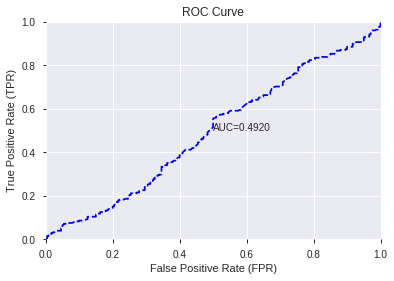

This function is available for GLM models only


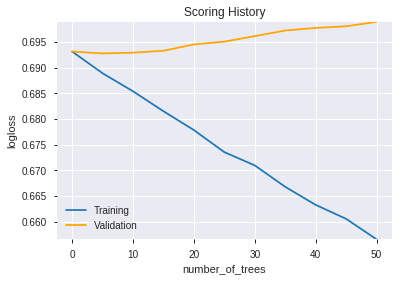

--2019-08-25 14:06:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_140618_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_140618_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['TRANGE',
 'VAR_8',
 'CORREL_30',
 'BBANDS_upperband_30_6_5',
 'Volume',
 'VAR_20',
 'VAR_30',
 'VAR_12',
 'DIV',
 'STDDEV_14',
 'CDL3INSIDE',
 'VAR_24',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLLONGLEGGEDDOJI',
 'VAR_14',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHARAMI',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDLADVANCEBLOCK',
 'CDLGRAVESTONEDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 919 929] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_140741_model_2  0.529114  1.080108              0.485125  0.586549  0.344040
1  DeepLearning_grid_1_AutoML_20190825_140741_model_6  0.525747  0.693419              0.500000  0.500058  0.250058
2  DeepLearning_grid_1_AutoML_20190825_140741_model_4  0.520034  0.790943              0.497917  0.533546  0.284671
3               DeepLearning_1_AutoML_20190825_140741  0.500620  0.724296              0.500000  0.507828  0.257889
4  DeepLearning_grid_1_AutoML_20190825_140741_model_5  0.500612  0.690484              0.489292  0.498660  0.248662
5  DeepLearning_grid_1_AutoML_20190825_140741_model_9  0.500000  0.690397              0.500000  0.498624  0.248626
6  DeepLearning_grid_1_AutoML_20190825_140741_model_8  0.500000  0.691757              0.500000  0.499305  0.249305
7  DeepLearning_grid_1_AutoML_20190825_140741_model_1  0.486992  0.934286              0.500000  0.562649  0.316574
8  DeepLearning_grid_1_AutoML_20190825_140741_model_3  0.483423  0.793819              0.497917  0.538263  0.289727
9  DeepLearning_grid_1_AutoML_20190825_140741_model_7  0.480264  0.745322              0.500000  0.517690  0.268003

variable  relative_importance  scaled_importance  percentage
0                         hour             1.000000           1.000000    0.001946
1                    dayofweek             0.979944           0.979944    0.001907
2                 HT_TRENDMODE             0.977710           0.977710    0.001903
3                      weekday             0.946695           0.946695    0.001842
4            CDL3WHITESOLDIERS             0.922556           0.922556    0.001795
...                        ...                  ...                ...         ...
1033  BBANDS_middleband_14_6_5             0.411928           0.411928    0.000802
1034    BBANDS_upperband_8_2_5             0.411622           0.411622    0.000801
1035                 MAVP_30_0             0.410184           0.410184    0.000798
1036       CDLXSIDEGAP3METHODS             0.397905           0.397905    0.000774
1037  BBANDS_middleband_14_7_5             0.397110           0.397110    0.000773

[1038 rows x 4 columns]

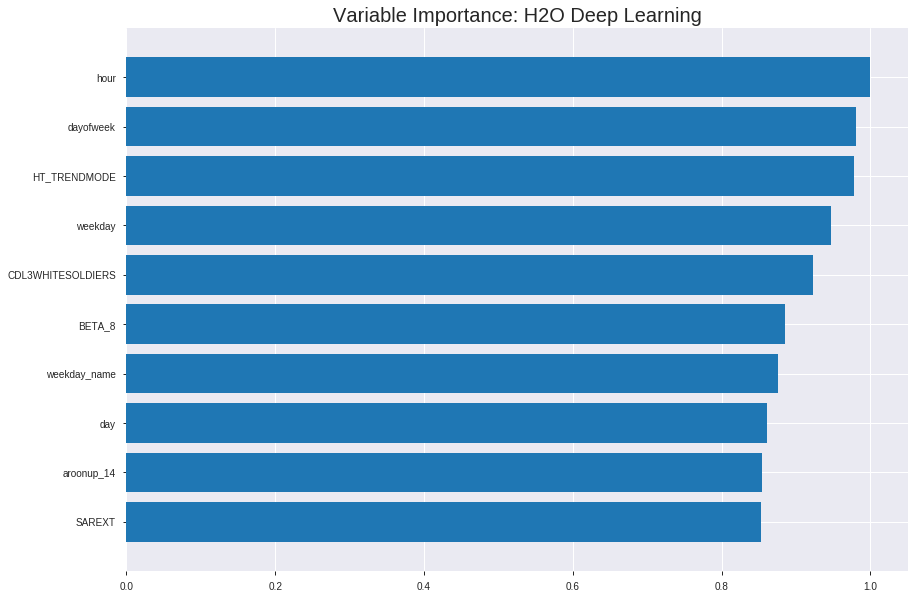

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_140741_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.272189173355826
RMSE: 0.5217175225692788
LogLoss: 0.7511870907082497
Mean Per-Class Error: 0.4732747910031483
AUC: 0.5290937178166838
pr_auc: 0.5577338554833576
Gini: 0.05818743563336759
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3390951195350487: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      4    1682  0.9976   (1682.0/1686.0)
1      1    1941  0.0005   (1.0/1942.0)
Total  5    3623  0.4639   (1683.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.339095     0.697574   395
max f2                       0.319892     0.852128   398
max f0point5                 0.463234     0.592605   344
max accuracy                 0.463234     0.542999   344
max precision                0.93766      0.75       5
max recall                   0.319892     1          398
max specificity              0.974055     0.999407   0
max absolute_mcc             0.641156     0.0537137  208
max min_per_class_accuracy   0.661507     0.522657   188
max mean_per_class_accuracy  0.641156     0.526725   208

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 65.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.903828           1.00983   1.00983            0.540541         0.925782  0.540541                    0.925782            0.0102987       0.0102987                  0.982548  0.982548
    2        0.0201213                   0.884919           1.19356   1.10043            0.638889         0.893432  0.589041                    0.909828            0.0118435       0.0221421                  19.3558   10.0433
    3        0.0300441                   0.866438           0.882195  1.02835            0.472222         0.874079  0.550459                    0.898021            0.00875386      0.030896                   -11.7805  2.83544
    4        0.0402426                   0.856437           1.26228   1.08764            0.675676         0.861333  0.582192                    0.888723            0.0128733       0.0437693                  26.2282   8.76374
    5        0.0501654                   0.847483           1.19356   1.10859            0.638889         0.851623  0.593407                    0.881385            0.0118435       0.0556128                  19.3558   10.8589
    6        0.100055                    0.816444           1.06311   1.08591            0.569061         0.832176  0.581267                    0.856848            0.0530381       0.108651                   6.31063   8.59101
    7        0.150221                    0.78947            1.03674   1.06949            0.554945         0.801364  0.572477                    0.83832             0.0520082       0.160659                   3.67357   6.94886
    8        0.20011                     0.763814           1.00118   1.05246            0.535912         0.776866  0.563361                    0.822999            0.0499485       0.210608                   0.11778   5.24579
    9        0.300165                    0.728278           1.04988   1.0516             0.561983         0.74523   0.562902                    0.797076            0.105046        0.315654                   4.98847   5.16002
    10       0.399945                    0.693474           1.05278   1.0519             0.563536         0.710654  0.56306                     0.775515            0.105046        0.4207                     5.27849   5.18957
    11       0.5                         0.661245           1.00871   1.04325            0.539945         0.677453  0.558434                    0.755892            0.100927        0.521627                   0.871272  4.32544
    12       0.600055                    0.627111           1.00357   1.03664            0.53719          0.644454  0.554892                    0.73731             0.100412        0.622039                   0.356623  3.66366
    13       0.699835                    0.597952           0.934089  1.02202            0.5              0.612272  0.547066                    0.719483            0.0932029       0.715242                   -6.59114  2.20158
    14       0.79989                     0.558722           0.926369  1.01005            0.495868         0.579237  0.540662                    0.70194             0.092688        0.80793                    -7.36312  1.00517
    15       0.899945                    0.494133           1.00357   1.00933            0.53719          0.530996  0.540276                    0.682935            0.100412        0.908342                   0.356623  0.933062
    16       1                           0.306734           0.916076  1                  0.490358         0.440833  0.535281                    0.658711       



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2801694326950053
RMSE: 0.5293103368488143
LogLoss: 0.7667560674701382
Mean Per-Class Error: 0.4680973266499582
AUC: 0.5232780612244897
pr_auc: 0.5327440075018909
Gini: 0.04655612244897944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37274990990906987: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    495   0.9821   (495.0/504.0)
1      2    530   0.0038   (2.0/532.0)
Total  11   1025  0.4797   (497.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.37275      0.680796   390
max f2                       0.332483     0.841506   396
max f0point5                 0.509424     0.574029   322
max accuracy                 0.586304     0.537645   261
max precision                0.875081     1          0
max recall                   0.332483     1          396
max specificity              0.875081     1          0
max absolute_mcc             0.538616     0.0722302  300
max min_per_class_accuracy   0.671405     0.50188    185
max mean_per_class_accuracy  0.586304     0.531903   261

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 65.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.86238            1.23923   1.23923            0.636364         0.868475  0.636364                    0.868475            0.0131579       0.0131579                  23.9234   23.9234
    2        0.0202703                   0.856256           0.778947  1.02005            0.4              0.859526  0.52381                     0.864214            0.0075188       0.0206767                  -22.1053  2.00501
    3        0.030888                    0.847579           1.41627   1.15625            0.727273         0.85041   0.59375                     0.859469            0.0150376       0.0357143                  41.6268   15.625
    4        0.0405405                   0.841963           0.973684  1.11278            0.5              0.844174  0.571429                    0.855827            0.0093985       0.0451128                  -2.63158  11.2782
    5        0.0501931                   0.836447           1.16842   1.12348            0.6              0.838909  0.576923                    0.852574            0.0112782       0.056391                   16.8421   12.3482
    6        0.100386                    0.808393           1.01113   1.06731            0.519231         0.823022  0.548077                    0.837798            0.0507519       0.107143                   1.11336   6.73077
    7        0.150579                    0.786762           1.27328   1.13596            0.653846         0.796731  0.583333                    0.824109            0.0639098       0.171053                   27.3279   13.5965
    8        0.200772                    0.7684             0.936235  1.08603            0.480769         0.778083  0.557692                    0.812602            0.0469925       0.218045                   -6.37652  8.60324
    9        0.300193                    0.743193           0.888605  1.02065            0.456311         0.754979  0.524116                    0.793518            0.0883459       0.306391                   -11.1395  2.06465
    10       0.400579                    0.713946           0.973684  1.00888            0.5              0.728133  0.518072                    0.777132            0.0977444       0.404135                   -2.63158  0.887762
    11       0.5                         0.670649           0.983137  1.00376            0.504854         0.69155   0.515444                    0.760115            0.0977444       0.50188                    -1.68625  0.37594
    12       0.600386                    0.632485           1.14221   1.02691            0.586538         0.650554  0.527331                    0.741796            0.114662        0.616541                   14.2206   2.69081
    13       0.699807                    0.593341           1.07767   1.03412            0.553398         0.612347  0.531034                    0.723405            0.107143        0.723684                   7.76699   3.41198
    14       0.800193                    0.542408           1.01113   1.03124            0.519231         0.56698   0.529554                    0.703782            0.101504        0.825188                   1.11336   3.12361
    15       0.899614                    0.490043           0.869699  1.01338            0.446602         0.517811  0.520386                    0.683229            0.0864662       0.911654                   -13.0301  1.33838
    16       1                           0.318319           0.880061  1                  0.451923         0.433298  0.513514                    0.658139         


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:18:27  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:18:30  10 min 47.127 sec  322 obs/sec       0.218026  1             791        0.697411         11.1459             -0.955263      0.505433        0.362522           0.975706         0.464719                         0.685731           10.7711               -0.882285        0.524949          0.380101             1.15167            0.486486
    2019-08-25 14:19:01  11 min 18.134 sec  369 obs/sec       3.10557   14            11267      0.540281         0.81742             -0.173457      0.51816         0.553935           1.21179          0.463065                         0.54897            0.88219               -0.206353        0.528949          0.548189             1.77033            0.486486
    2019-08-25 14:19:31  11 min 48.321 sec  400 obs/sec       6.36963   29            23109      0.521718         0.751187            -0.0942048     0.529094        0.557734           1.00983          0.463892                         0.52931            0.766756              -0.121497        0.523278          0.532744             1.23923            0.47973
    2019-08-25 14:20:02  12 min 19.087 sec  420 obs/sec       9.90821   45            35947      0.563912         0.912888            -0.278351      0.507336        0.550714           1.26228          0.464719                         0.598432           1.03609               -0.433531        0.475038          0.498512             0.708134           0.486486
    2019-08-25 14:20:32  12 min 49.615 sec  438 obs/sec       13.661    62            49562      0.538305         0.838717            -0.164889      0.513963        0.547729           1.21179          0.464168                         0.564828           0.961265              -0.277055        0.473742          0.494364             0.885167           0.485521
    2019-08-25 14:21:03  13 min 20.053 sec  454 obs/sec       17.5956   80            63837      0.569906         0.9547              -0.305671      0.515261        0.554628           1.1613           0.464719                         0.580712           1.00506               -0.34989         0.52201           0.540445             1.41627            0.477799
    2019-08-25 14:21:34  13 min 51.686 sec  472 obs/sec       21.9972   100           79806      0.553249         0.874291            -0.230462      0.518074        0.554658           1.31277          0.464443                         0.575701           0.96156               -0.326694        0.524734          0.541792             1.0622             0.48166
    2019-08-25 14:21:37  13 min 54.770 sec  472 obs/sec       21.9972   100           79806      0.521718         0.751187            -0.0942048     0.529094        0.557734           1.00983          0.463892                         0.52931            0.766756              -0.121497        0.523278          0.532744             1.23923            0.47973

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
hour                      1.0                    1.0                  0.0019460675401430862
dayofweek                 0.9799442291259766     0.9799442291259766   0.001907037655452602
HT_TRENDMODE              0.9777101278305054     0.9777101278305054   0.001902689943440094
weekday                   0.9466946721076965     0.9466946721076965   0.0018423317718151905
CDL3WHITESOLDIERS         0.9225556254386902     0.9225556254386902   0.0017953555566426382
---                       ---                    ---                  ---
BBANDS_middleband_14_6_5  0.411927729845047      0.411927729845047    0.0008016391839362764
BBANDS_upperband_8_2_5    0.4116218686103821     0.4116218686103821   0.0008010439573157069
MAVP_30_0                 0.4101838171482086     0.4101838171482086   0.0007982454120441158
CDLXSIDEGAP3METHODS       0.3979054093360901     0.3979054093360901   0.0007743508011563127
BBANDS_middleband_14_7_5  0.39710962772369385    0.39710962772369385  0.0007728021563913856


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5529865125240848)

('F1', 0.7046894803548795)

('auc', 0.5291143966547193)

('logloss', 1.0801081018982728)

('mean_per_class_error', 0.46565860215053767)

('rmse', 0.5865494714910666)

('mse', 0.34404028250644964)

deeplearning prediction progress: |███████████████████████████████████████| 100%


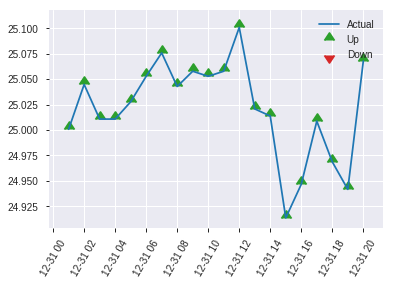


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.34404028250644964
RMSE: 0.5865494714910666
LogLoss: 1.0801081018982728
Mean Per-Class Error: 0.46565860215053767
AUC: 0.5291143966547193
pr_auc: 0.5710918930470253
Gini: 0.05822879330943853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49328862991386: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    232  0.9667   (232.0/240.0)
1      1    278  0.0036   (1.0/279.0)
Total  9    510  0.4489   (233.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493289     0.704689  390
max f2                       0.451444     0.855828  394
max f0point5                 0.522603     0.600261  385
max accuracy                 0.522603     0.552987  385
max precision                0.991079     1         0
max recall                   0.451444     1         394
max specificity              0.991079     1         0
max absolute_mcc             0.493289     0.113625  390
max min_per_class_accuracy   0.847626     0.526882  179
max mean_per_class_accuracy  0.91521      0.534341  128

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 82.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.990167           1.24014   1.24014            0.666667         0.990548  0.666667                    0.990548            0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.989433           1.48817   1.35288            0.8              0.989763  0.727273                    0.990191            0.0143369       0.0286738                  48.8172   35.2884
    3        0.0308285                   0.988719           1.11613   1.2789             0.6              0.989097  0.6875                      0.989849            0.0107527       0.0394265                  11.6129   27.8898
    4        0.0404624                   0.987908           1.48817   1.32873            0.8              0.988265  0.714286                    0.989472            0.0143369       0.0537634                  48.8172   32.8725
    5        0.0500963                   0.986902           0.744086  1.21629            0.4              0.987454  0.653846                    0.989084            0.00716846      0.0609319                  -25.5914  21.6294
    6        0.100193                    0.972635           1.14475   1.18052            0.615385         0.978724  0.634615                    0.983904            0.0573477       0.11828                    14.4748   18.0521
    7        0.150289                    0.966754           0.787014  1.04935            0.423077         0.970168  0.564103                    0.979325            0.0394265       0.157706                   -21.2986  4.93521
    8        0.200385                    0.957473           1.14475   1.0732             0.615385         0.962581  0.576923                    0.975139            0.0573477       0.215054                   14.4748   7.3201
    9        0.300578                    0.938064           1.0732    1.0732             0.576923         0.948196  0.576923                    0.966158            0.107527        0.322581                   7.3201    7.3201
    10       0.400771                    0.902475           1.03743   1.06426            0.557692         0.920878  0.572115                    0.954838            0.103943        0.426523                   3.74276   6.42577
    11       0.500963                    0.847626           1.00165   1.05174            0.538462         0.871911  0.565385                    0.938253            0.100358        0.526882                   0.165426  5.1737
    12       0.599229                    0.812694           0.98482   1.04076            0.529412         0.828284  0.559486                    0.920219            0.0967742       0.623656                   -1.51803  4.07634
    13       0.699422                    0.760561           0.751241  0.999289           0.403846         0.787326  0.53719                     0.901182            0.0752688       0.698925                   -24.8759  -0.0710922
    14       0.799615                    0.725841           0.965881  0.995103           0.519231         0.741428  0.53494                     0.881165            0.0967742       0.795699                   -3.41191  -0.489701
    15       0.899807                    0.622179           1.0732    1.0038             0.576923         0.691803  0.539615                    0.860079            0.107527        0.903226                   7.3201    0.379913
    16       1                           0.36036            0.965881  1                  0.519231         0.544938  0.537572                    0.828505      

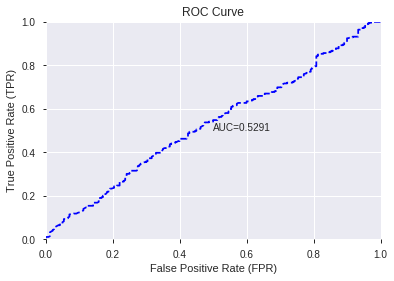

This function is available for GLM models only


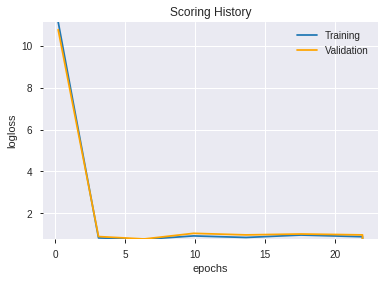

--2019-08-25 15:07:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_140741_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_140741_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['hour',
 'dayofweek',
 'HT_TRENDMODE',
 'weekday',
 'CDL3WHITESOLDIERS',
 'BETA_8',
 'weekday_name',
 'day',
 'aroonup_14',
 'SAREXT',
 'CDLGAPSIDESIDEWHITE',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'aroondown_20',
 'BOP',
 'CDLIDENTICAL3CROWS',
 'CDLHOMINGPIGEON',
 'aroondown_24',
 'aroonup_8',
 'BETA_14',
 'aroondown_14',
 'DX_8',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'CDLSTICKSANDWICH',
 'aroonup_20',
 'CORREL_30',
 'BETA_30',
 'BETA_24',
 'AROONOSC_8',
 'CDLRICKSHAWMAN',
 'aroondown_8',
 'CDLTHRUSTING',
 'aroondown_12',
 'CORREL_8',
 'is_quarter_start',
 'weekofyear',
 'STOCHF_fastk',
 'AROONOSC_12',
 'week',
 'aroonup_24',
 'CDL3BLACKCROWS',
 'aroondown_30',
 'BETA_12',
 'aroonup_30',
 'month',
 'CDLSPINNINGTOP',
 'aroonup_12',
 'HT_DCPERIOD',
 'ADX_20',
 'AD',
 'CORREL_20',
 'DX_12',
 'CDLTASUKIGAP',
 'CDLUNIQUE3RIVER',
 'HT_PHASOR_quadrature',
 'MACDEXT_hist',
 'CORREL_14',
 'BETA_20',
 'dayofyear',
 'DX_20',
 'OBV',
 'quarter',
 'ADXR_14',
 'DX_14',
 'ADX_8',
 'W

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_150850_model_1  0.514329  0.690478              0.497917  0.498662  0.248664

variable  relative_importance  scaled_importance  percentage
0                   CDL3INSIDE         7.243445e-03           1.000000    0.012556
1               CDLHARAMICROSS         6.080691e-03           0.839475    0.010541
2                 CDLTHRUSTING         6.072816e-03           0.838388    0.010527
3         HT_PHASOR_quadrature         5.949528e-03           0.821367    0.010313
4                          OBV         5.623110e-03           0.776303    0.009747
...                        ...                  ...                ...         ...
1033                 MAVP_14_6         1.604485e-06           0.000222    0.000003
1034  BBANDS_middleband_20_2_5         1.491758e-06           0.000206    0.000003
1035  BBANDS_middleband_30_0_2         7.394615e-07           0.000102    0.000001
1036                    WMA_14         6.209664e-07           0.000086    0.000001
1037                   MA_14_2         0.000000e+00           0.000000    0.000000

[1038 rows x 4 columns]

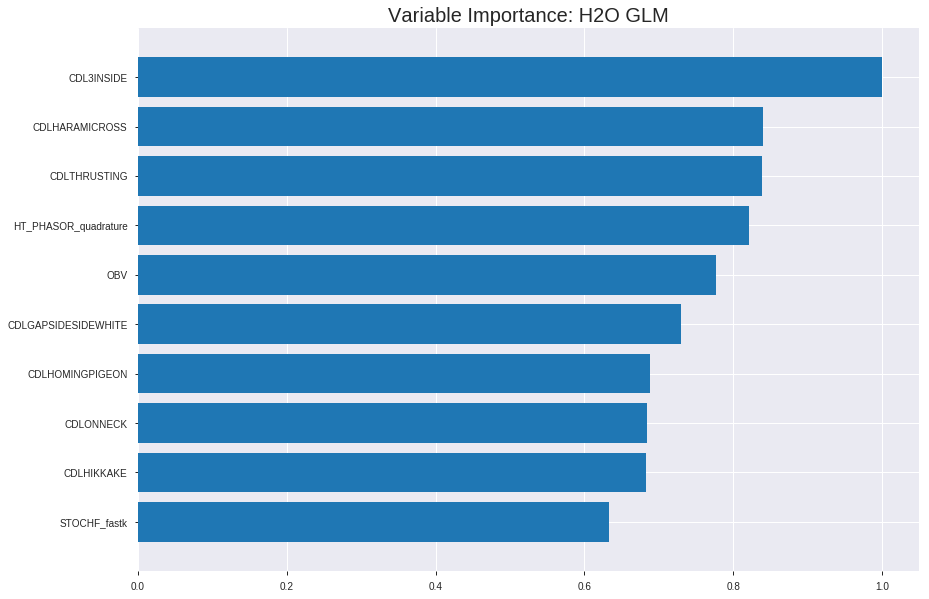

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_150850_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24701342343726654
RMSE: 0.497004450118172
LogLoss: 0.6871432517517012
Null degrees of freedom: 3627
Residual degrees of freedom: 2590
Null deviance: 5011.396974952616
Residual deviance: 4985.911434710344
AIC: 7061.911434710344
AUC: 0.5602566357951165
pr_auc: 0.5929601942499281
Gini: 0.12051327159023306
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4947326166074131: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      38   1648  0.9775   (1648.0/1686.0)
1      19   1923  0.0098   (19.0/1942.0)
Total  57   3571  0.4595   (1667.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.494733     0.697624   367
max f2                       0.421918     0.852053   399
max f0point5                 0.519229     0.598125   296
max accuracy                 0.521698     0.557056   283
max precision                0.659684     1          0
max recall                   0.421918     1          399
max specificity              0.659684     1          0
max absolute_mcc             0.532356     0.0905853  220
max min_per_class_accuracy   0.534281     0.541195   208
max mean_per_class_accuracy  0.532356     0.545213   220

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.584069           1.46425   1.46425            0.783784         0.60098   0.783784                    0.60098             0.0149331       0.0149331                  46.4247   46.4247
    2        0.0201213                   0.573941           1.34924   1.40753            0.722222         0.577042  0.753425                    0.589175            0.0133883       0.0283213                  34.9239   40.7531
    3        0.0300441                   0.57086            1.19356   1.33686            0.638889         0.57231   0.715596                    0.583605            0.0118435       0.0401648                  19.3558   33.6861
    4        0.0402426                   0.567184           1.31277   1.33076            0.702703         0.569073  0.712329                    0.579922            0.0133883       0.053553                   31.2773   33.0756
    5        0.0501654                   0.564922           1.29735   1.32415            0.694444         0.566157  0.708791                    0.577199            0.0128733       0.0664264                  29.7345   32.4148
    6        0.100055                    0.557015           1.13536   1.23001            0.607735         0.560753  0.658402                    0.568999            0.0566426       0.123069                   13.5356   23.0012
    7        0.150221                    0.552661           0.985412  1.14833            0.527473         0.554751  0.614679                    0.564241            0.0494336       0.172503                   -1.45879  14.8329
    8        0.20011                     0.549616           1.09407   1.1348             0.585635         0.551029  0.607438                    0.560947            0.0545829       0.227085                   9.40706   13.4802
    9        0.300165                    0.543594           1.06532   1.11164            0.570248         0.546364  0.595041                    0.556086            0.106591        0.333677                   6.53242   11.1643
    10       0.399945                    0.538791           1.02182   1.08923            0.546961         0.541232  0.583046                    0.55238             0.101957        0.435633                   2.18206   8.92335
    11       0.5                         0.534311           1.0293    1.07724            0.550964         0.536465  0.576626                    0.549195            0.102987        0.53862                    2.92987   7.724
    12       0.600055                    0.530108           0.98298   1.06152            0.526171         0.532152  0.568213                    0.546353            0.0983522       0.636972                   -1.70197  6.15228
    13       0.699835                    0.526116           0.949571  1.04556            0.508287         0.52807   0.559669                    0.543747            0.0947477       0.73172                    -5.04293  4.55611
    14       0.79989                     0.521568           1.01386   1.0416             0.5427           0.523944  0.557547                    0.54127             0.101442        0.833162                   1.38592   4.15957
    15       0.899945                    0.515113           0.864611  1.02192            0.46281          0.518681  0.547014                    0.538758            0.0865088       0.91967                    -13.5389  2.19186
    16       1                           0.421918           0.802853  1                  0.429752         0.504007  0.535281                    0.535281           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2506413726964361
RMSE: 0.5006409618643246
LogLoss: 0.694437470235043
Null degrees of freedom: 1035
Residual degrees of freedom: -2
Null deviance: 1437.4140588309256
Residual deviance: 1438.874438327009
AIC: 3514.874438327009
AUC: 0.49863498030791265
pr_auc: 0.5201222623436592
Gini: -0.0027300393841747095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48269890935554516: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    503   0.998    (503.0/504.0)
1      0    532   0        (0.0/532.0)
Total  1    1035  0.4855   (503.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.482699     0.679004   398
max f2                       0.482699     0.840974   398
max f0point5                 0.482699     0.569349   398
max accuracy                 0.528368     0.517375   252
max precision                0.611273     1          0
max recall                   0.482699     1          398
max specificity              0.611273     1          0
max absolute_mcc             0.583716     0.0555254  17
max min_per_class_accuracy   0.534342     0.5        214
max mean_per_class_accuracy  0.528368     0.513941   252

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 53.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.591597           1.41627   1.41627            0.727273         0.599197  0.727273                    0.599197            0.0150376       0.0150376                  41.6268   41.6268
    2        0.0202703                   0.582172           1.16842   1.29825            0.6              0.585354  0.666667                    0.592605            0.0112782       0.0263158                  16.8421   29.8246
    3        0.030888                    0.578756           0.885167  1.15625            0.454545         0.580041  0.59375                     0.588286            0.0093985       0.0357143                  -11.4833  15.625
    4        0.0405405                   0.57449            1.36316   1.20551            0.7              0.576643  0.619048                    0.585514            0.0131579       0.0488722                  36.3158   20.5514
    5        0.0501931                   0.57167            0.973684  1.16093            0.5              0.572849  0.596154                    0.583078            0.0093985       0.0582707                  -2.63158  16.0931
    6        0.100386                    0.561789           0.973684  1.06731            0.5              0.566332  0.548077                    0.574705            0.0488722       0.107143                   -2.63158  6.73077
    7        0.150579                    0.555841           0.898785  1.01113            0.461538         0.55852   0.519231                    0.56931             0.0451128       0.152256                   -10.1215  1.11336
    8        0.200772                    0.552569           0.973684  1.00177            0.5              0.554028  0.514423                    0.565489            0.0488722       0.201128                   -2.63158  0.177126
    9        0.300193                    0.545747           0.964231  0.989338           0.495146         0.549109  0.508039                    0.560065            0.0958647       0.296992                   -3.5769   -1.06617
    10       0.400579                    0.539848           1.04858   1.00419            0.538462         0.54266   0.515663                    0.555703            0.105263        0.402256                   4.8583    0.418516
    11       0.5                         0.534214           1.00204   1.00376            0.514563         0.537059  0.515444                    0.551996            0.0996241       0.50188                    0.204394  0.37594
    12       0.600386                    0.529722           1.08603   1.01752            0.557692         0.532011  0.522508                    0.548654            0.109023        0.610902                   8.60324   1.75157
    13       0.699807                    0.52474            0.831886  0.991143           0.427184         0.527111  0.508966                    0.545594            0.0827068       0.693609                   -16.8114  -0.885662
    14       0.800193                    0.518944           0.91751   0.981906           0.471154         0.521636  0.504222                    0.542588            0.0921053       0.785714                   -8.24899  -1.80941
    15       0.899614                    0.511827           1.09658   0.994579           0.563107         0.515455  0.51073                     0.539589            0.109023        0.894737                   9.65764   -0.542128
    16       1                           0.481524           1.04858   1                  0.538462         0.504134  0.513514                    0.53603   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:08:57  0.000 sec   2            2.4       1038          1.37429           1.38887
    2019-08-25 15:09:01  4.288 sec   4            1.7       1039          1.37272           1.38939
    2019-08-25 15:09:06  8.636 sec   6            1.3       1039          1.37087           1.39013
    2019-08-25 15:09:10  13.126 sec  8            0.92      1039          1.36874           1.39118
    2019-08-25 15:09:14  17.443 sec  10           0.67      1039          1.36634           1.39261

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5433526011560693)

('F1', 0.7001254705144292)

('auc', 0.5143294504181601)

('logloss', 0.6904780539160754)

('mean_per_class_error', 0.4731406810035842)

('rmse', 0.4986619060498309)

('mse', 0.24866369654525036)

glm prediction progress: |████████████████████████████████████████████████| 100%


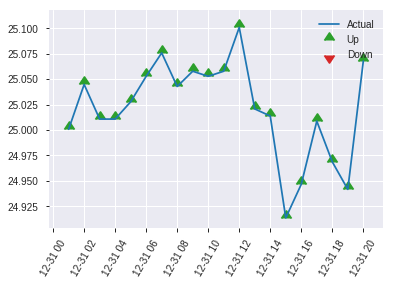


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24866369654525036
RMSE: 0.4986619060498309
LogLoss: 0.6904780539160754
Null degrees of freedom: 518
Residual degrees of freedom: -519
Null deviance: 716.5643274932833
Residual deviance: 716.7162199648862
AIC: 2792.7162199648865
AUC: 0.5143294504181601
pr_auc: 0.5512932359727849
Gini: 0.028658900836320278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4931851742648865: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    239  0.9958   (239.0/240.0)
1      0    279  0        (0.0/279.0)
Total  1    518  0.4605   (239.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.493185     0.700125   398
max f2                       0.493185     0.853733   398
max f0point5                 0.5144       0.594344   376
max accuracy                 0.5144       0.543353   376
max precision                0.652328     1          0
max recall                   0.493185     1          398
max specificity              0.652328     1          0
max absolute_mcc             0.573681     0.0692609  83
max min_per_class_accuracy   0.550046     0.494624   202
max mean_per_class_accuracy  0.573681     0.526859   83

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 55.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.620858           1.24014   1.24014            0.666667         0.629594  0.666667                    0.629594            0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.614018           0.744086  1.01466            0.4              0.617124  0.545455                    0.623926            0.00716846      0.0215054                  -25.5914  1.46628
    3        0.0308285                   0.609567           0.744086  0.930108           0.4              0.612141  0.5                         0.620243            0.00716846      0.0286738                  -25.5914  -6.98925
    4        0.0404624                   0.603999           1.48817   1.06298            0.8              0.607584  0.571429                    0.617229            0.0143369       0.0430108                  48.8172   6.298
    5        0.0500963                   0.598699           0.372043  0.930108           0.2              0.601299  0.5                         0.614166            0.00358423      0.046595                   -62.7957  -6.98925
    6        0.100193                    0.589446           1.21629   1.0732             0.653846         0.594166  0.576923                    0.604166            0.0609319       0.107527                   21.6294   7.3201
    7        0.150289                    0.578196           1.00165   1.04935            0.538462         0.583538  0.564103                    0.59729             0.0501792       0.157706                   0.165426  4.93521
    8        0.200385                    0.572447           1.28784   1.10897            0.692308         0.574748  0.596154                    0.591654            0.0645161       0.222222                   28.7841   10.8974
    9        0.300578                    0.562648           1.00165   1.0732             0.538462         0.566864  0.576923                    0.583391            0.100358        0.322581                   0.165426  7.3201
    10       0.400771                    0.556516           0.965881  1.04637            0.519231         0.559686  0.5625                      0.577465            0.0967742       0.419355                   -3.41191  4.6371
    11       0.500963                    0.54989            0.787014  0.9945             0.423077         0.552739  0.534615                    0.57252             0.078853        0.498208                   -21.2986  -0.550041
    12       0.599229                    0.544558           0.948345  0.986931           0.509804         0.546928  0.530547                    0.568323            0.09319         0.591398                   -5.16551  -1.30692
    13       0.699422                    0.537541           1.14475   1.00954            0.615385         0.5416    0.5427                      0.564495            0.114695        0.706093                   14.4748   0.95382
    14       0.799615                    0.530913           1.00165   1.00855            0.538462         0.534224  0.542169                    0.560702            0.100358        0.806452                   0.165426  0.855033
    15       0.899807                    0.521927           0.965881  1.0038             0.519231         0.526824  0.539615                    0.55693             0.0967742       0.903226                   -3.41191  0.379913
    16       1                           0.482324           0.965881  1                  0.519231         0.512414  0.537572                    0.552469       

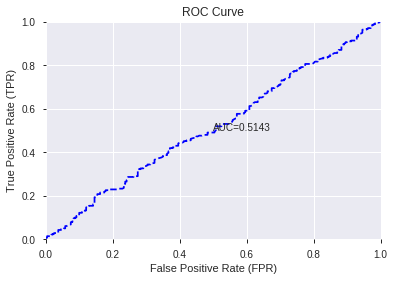

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


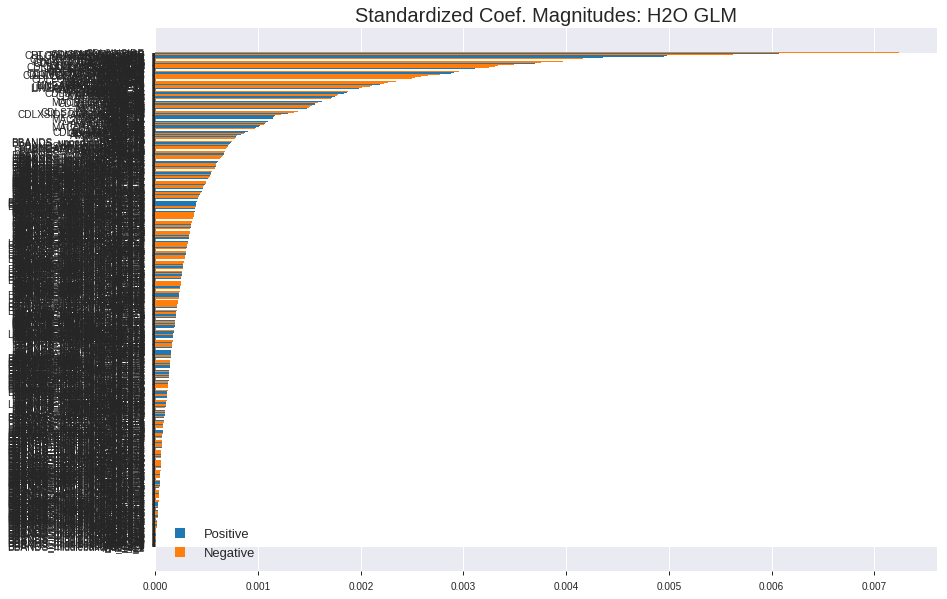

'log_likelihood'
--2019-08-25 15:09:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_150850_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_150850_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDL3INSIDE',
 'CDLHARAMICROSS',
 'CDLTHRUSTING',
 'HT_PHASOR_quadrature',
 'OBV',
 'CDLGAPSIDESIDEWHITE',
 'CDLHOMINGPIGEON',
 'CDLONNECK',
 'CDLHIKKAKE',
 'STOCHF_fastk',
 'CDLMATCHINGLOW',
 'WILLR_8',
 'CDLINVERTEDHAMMER',
 'ROCR_8',
 'ROCR100_8',
 'ROC_8',
 'days_in_month',
 'ROCP_8',
 'MOM_8',
 'CDLGRAVESTONEDOJI',
 'CDLSTALLEDPATTERN',
 'WILLR_14',
 'PLUS_DI_30',
 'BETA_12',
 'aroondown_30',
 'SAREXT',
 'BETA_20',
 'CDLUNIQUE3RIVER',
 'CDLADVANCEBLOCK',
 'CDLHAMMER',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'CDLRICKSHAWMAN',
 'weekday',
 'PLUS_DI_24',
 'dayofweek',
 'hour',
 'CORREL_8',
 'CDL3BLACKCROWS',
 'HT_PHASOR_inphase',
 'BOP',
 'WILLR_12',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'Volume',
 'CDLDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLSEPARATINGLINES',
 'CDLMORNINGSTAR',
 'PLUS_DI_20',
 'BETA_8',
 'MFI_20',
 'WILLR_20',
 'MACDFIX_hist_24',
 'TAN',
 'CDLLONGLEGGEDDOJI',
 'WILLR_30',
 'CDLLONGLINE',
 'ADOSC',
 'STOCHRSI_fastd',
 'COS',
 'MACDFIX_hist_20',
 'CDLHIGHWAVE',
 'CDLP

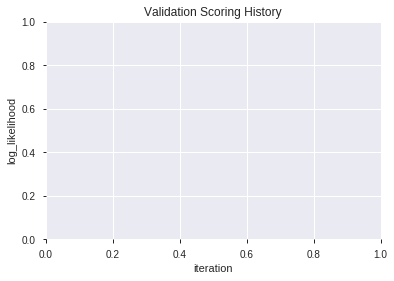

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190825_151038  0.530130  0.698565              0.495833  0.502217  0.252222
1  XGBoost_grid_1_AutoML_20190825_151038_model_7  0.528816  0.715546              0.497917  0.509648  0.259741
2  XGBoost_grid_1_AutoML_20190825_151038_model_5  0.521289  0.729542              0.493459  0.515396  0.265633
3  XGBoost_grid_1_AutoML_20190825_151038_model_3  0.518526  0.708771              0.493459  0.506541  0.256584
4               XGBoost_2_AutoML_20190825_151038  0.514434  0.710139              0.493459  0.507363  0.257417
5  XGBoost_grid_1_AutoML_20190825_151038_model_6  0.511544  0.713244              0.495833  0.508605  0.258679
6  XGBoost_grid_1_AutoML_20190825_151038_model_4  0.509401  0.701478              0.487209  0.503710  0.253724
7  XGBoost_grid_1_AutoML_20190825_151038_model_1  0.501964  0.711576              0.483378  0.507892  0.257954
8  XGBoost_grid_1_AutoML_20190825_151038_model_2  0.498619  0.699045              0.495833  0.502744  0.252751
9               XGBoost_1_AutoML_20190825_151038  0.496311  0.722852              0.500000  0.512967  0.263136

variable  relative_importance  scaled_importance  percentage
0                        OBV           210.201660           1.000000    0.029988
1                        BOP           187.548126           0.892230    0.026756
2       HT_PHASOR_quadrature           169.835800           0.807966    0.024229
3               STOCHF_fastk           118.280380           0.562700    0.016874
4                   WILLR_20            97.221428           0.462515    0.013870
..                       ...                  ...                ...         ...
306  BBANDS_upperband_12_2_3             1.905987           0.009067    0.000272
307               PLUS_DI_14             1.630069           0.007755    0.000233
308                   MOM_20             1.458414           0.006938    0.000208
309   BBANDS_lowerband_8_1_2             1.160400           0.005520    0.000166
310   BBANDS_lowerband_8_7_5             0.711510           0.003385    0.000102

[311 rows x 4 columns]

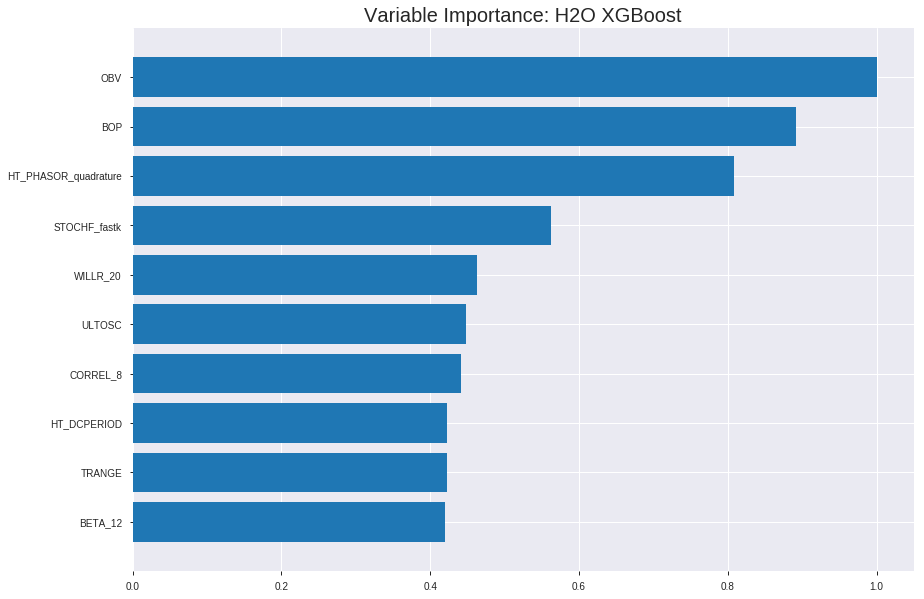

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190825_151038


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2042333276297537
RMSE: 0.4519218158373788
LogLoss: 0.5998822884754239
Mean Per-Class Error: 0.1736313958900646
AUC: 0.9087271990940111
pr_auc: 0.9159770531587014
Gini: 0.8174543981880222
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5119823018709818: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1240  446   0.2645   (446.0/1686.0)
1      194   1748  0.0999   (194.0/1942.0)
Total  1434  2194  0.1764   (640.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511982     0.845261  234
max f2                       0.478592     0.900447  279
max f0point5                 0.544975     0.858263  187
max accuracy                 0.520812     0.828831  221
max precision                0.808171     1         0
max recall                   0.423108     1         341
max specificity              0.808171     1         0
max absolute_mcc             0.520812     0.655571  221
max min_per_class_accuracy   0.5289       0.821318  209
max mean_per_class_accuracy  0.522195     0.826369  219

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.713794           1.86818   1.86818            1                0.742198  1                           0.742198            0.0190525       0.0190525                  86.8177   86.8177
    2        0.0201213                   0.691188           1.86818   1.86818            1                0.699291  1                           0.721039            0.0185376       0.0375901                  86.8177   86.8177
    3        0.0300441                   0.676818           1.86818   1.86818            1                0.683207  1                           0.708544            0.0185376       0.0561277                  86.8177   86.8177
    4        0.0402426                   0.66335            1.86818   1.86818            1                0.669411  1                           0.698627            0.0190525       0.0751802                  86.8177   86.8177
    5        0.0501654                   0.65733            1.81628   1.85791            0.972222         0.66064   0.994505                    0.691113            0.0180227       0.0932029                  81.6283   85.7912
    6        0.100055                    0.628              1.81657   1.8373             0.972376         0.640566  0.983471                    0.665909            0.0906282       0.183831                   81.657    83.7298
    7        0.150221                    0.606098           1.77579   1.81676            0.950549         0.616265  0.972477                    0.649331            0.0890834       0.272915                   77.5795   81.6759
    8        0.20011                     0.593022           1.75464   1.80127            0.939227         0.599015  0.964187                    0.636786            0.0875386       0.360453                   75.4642   80.1273
    9        0.300165                    0.570791           1.63144   1.74466            0.873278         0.581569  0.933884                    0.618381            0.163234        0.523687                   63.1438   74.4661
    10       0.399945                    0.551918           1.54821   1.69565            0.828729         0.561556  0.90765                     0.604204            0.15448         0.678167                   54.8213   69.5651
    11       0.5                         0.53291            1.22487   1.60144            0.655647         0.542371  0.857222                    0.591831            0.122554        0.800721                   22.4865   60.1442
    12       0.600055                    0.512704           0.941808  1.49145            0.504132         0.522911  0.798346                    0.580339            0.0942327       0.894954                   -5.81917  49.1452
    13       0.699835                    0.492519           0.588321  1.36269            0.314917         0.503008  0.729421                    0.569313            0.0587024       0.953656                   -41.1679  36.2688
    14       0.79989                     0.467536           0.319083  1.23215            0.170799         0.480394  0.659545                    0.558191            0.0319258       0.985582                   -68.0917  23.2147
    15       0.899945                    0.436206           0.133809  1.11003            0.0716253        0.453     0.594181                    0.546496            0.0133883       0.99897                    -86.6191  11.0035
    16       1                           0.299004           0.010293  1                  0.00550964       0.404025  0.535281                    0.532241         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2557661757690907
RMSE: 0.5057333049830619
LogLoss: 0.7055098085270175
Mean Per-Class Error: 0.4817773600668338
AUC: 0.5066740511994271
pr_auc: 0.5083736291675013
Gini: 0.0133481023988542
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3738298714160919: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    504   1        (504.0/504.0)
1      0    532   0        (0.0/532.0)
Total  0    1036  0.4865   (504.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.37383      0.678571   399
max f2                       0.37383      0.840708   399
max f0point5                 0.424421     0.570175   374
max accuracy                 0.471353     0.523166   335
max precision                0.721467     0.538462   9
max recall                   0.37383      1          399
max specificity              0.786653     0.998016   0
max absolute_mcc             0.653113     0.0504816  56
max min_per_class_accuracy   0.55427      0.507519   203
max mean_per_class_accuracy  0.533035     0.518223   239

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 55.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.721957           0.885167  0.885167           0.454545         0.742988  0.454545                    0.742988            0.0093985       0.0093985                  -11.4833  -11.4833
    2        0.0202703                   0.701738           0.778947  0.834586           0.4              0.7125    0.428571                    0.72847             0.0075188       0.0169173                  -22.1053  -16.5414
    3        0.030888                    0.688093           1.0622    0.912829           0.545455         0.694688  0.46875                     0.716857            0.0112782       0.0281955                  6.2201    -8.71711
    4        0.0405405                   0.680165           0.973684  0.927318           0.5              0.683807  0.47619                     0.708988            0.0093985       0.037594                   -2.63158  -7.26817
    5        0.0501931                   0.675531           0.973684  0.936235           0.5              0.677724  0.480769                    0.702976            0.0093985       0.0469925                  -2.63158  -6.37652
    6        0.100386                    0.643265           0.936235  0.936235           0.480769         0.656972  0.480769                    0.679974            0.0469925       0.093985                   -6.37652  -6.37652
    7        0.150579                    0.620844           1.08603   0.986167           0.557692         0.630361  0.50641                     0.663437            0.0545113       0.148496                   8.60324   -1.38327
    8        0.200772                    0.609167           0.936235  0.973684           0.480769         0.614544  0.5                         0.651213            0.0469925       0.195489                   -6.37652  -2.63158
    9        0.300193                    0.589606           1.02095   0.989338           0.524272         0.599251  0.508039                    0.634004            0.101504        0.296992                   2.09504   -1.06617
    10       0.400579                    0.572522           1.16093   1.03234            0.596154         0.579114  0.53012                     0.620248            0.116541        0.413534                   16.0931   3.23399
    11       0.5                         0.55395            0.945324  1.01504            0.485437         0.563196  0.521236                    0.608904            0.093985        0.507519                   -5.46755  1.50376
    12       0.600386                    0.535765           1.04858   1.02065            0.538462         0.545201  0.524116                    0.598253            0.105263        0.612782                   4.8583    2.06465
    13       0.699807                    0.519239           0.945324  1.00995            0.485437         0.526919  0.518621                    0.588118            0.093985        0.706767                   -5.46755  0.994555
    14       0.800193                    0.499281           0.95496   1.00305            0.490385         0.509753  0.515078                    0.578287            0.0958647       0.802632                   -4.50405  0.304743
    15       0.899614                    0.47253            1.07767   1.01129            0.553398         0.486067  0.519313                    0.568096            0.107143        0.909774                   7.76699   1.12943
    16       1                           0.37383            0.898785  1                  0.461538         0.440109  0.513514                    0.5552


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:11:04  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.464719                         0.5                0.693147              0.5               0                    1                  0.486486
    2019-08-25 15:11:05  0.977 sec   5                  0.494252         0.681699            0.702517        0.729212           1.66621          0.379824                         0.500843           0.694842              0.485854          0.493672             0.885167           0.486486
    2019-08-25 15:11:05  1.309 sec   10                 0.488918         0.671152            0.767678        0.787089           1.81769          0.331863                         0.501794           0.696792              0.485242          0.490904             0.5311             0.484556
    2019-08-25 15:11:05  1.646 sec   15                 0.483722         0.66093             0.793383        0.810727           1.86818          0.290518                         0.502524           0.698322              0.485656          0.493094             0.486842           0.486486
    2019-08-25 15:11:06  1.993 sec   20                 0.478498         0.65073             0.829141        0.844238           1.86818          0.261852                         0.502415           0.69816               0.500034          0.501664             0.5311             0.484556
    2019-08-25 15:11:06  2.349 sec   25                 0.473312         0.640659            0.848725        0.859589           1.86818          0.241455                         0.503154           0.699743              0.501229          0.499774             0.5311             0.486486
    2019-08-25 15:11:07  2.702 sec   30                 0.468657         0.631675            0.865134        0.873968           1.86818          0.228501                         0.50394            0.701464              0.502068          0.499533             0.5311             0.485521
    2019-08-25 15:11:07  3.061 sec   35                 0.464069         0.622894            0.879708        0.887586           1.86818          0.202591                         0.503807           0.701235              0.508651          0.507869             0.708134           0.485521
    2019-08-25 15:11:07  3.423 sec   40                 0.459134         0.613526            0.894348        0.902271           1.86818          0.185777                         0.504794           0.703384              0.507107          0.507091             0.5311             0.486486
    2019-08-25 15:11:08  3.773 sec   45                 0.45578          0.607179            0.900912        0.908265           1.86818          0.179713                         0.505413           0.704726              0.504627          0.506112             1.0622             0.485521
    2019-08-25 15:11:08  4.157 sec   50                 0.451922         0.599882            0.908727        0.915977           1.86818          0.176406                         0.505733           0.70551               0.506674          0.508374             0.885167           0.486486

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
OBV                      210.20166015625        1.0                   0.02998778755670256
BOP                      187.54812622070312     0.8922295194114654    0.02675598927992985
HT_PHASOR_quadrature     169.83580017089844     0.8079660267414337    0.024229113562955172
STOCHF_fastk             118.28038024902344     0.5626995531866953    0.01687411465921407
WILLR_20                 97.22142791748047      0.4625150336358547    0.01386980257045315
---                      ---                    ---                   ---
BBANDS_upperband_12_2_3  1.9059867858886719     0.00906742023099098   0.0002719118715743044
PLUS_DI_14               1.6300687789916992     0.007754785465443108  0.00023254885908551273
MOM_20                   1.458414077758789      0.006938166314550991  0.0002080602574738251
BBANDS_lowerband_8_1_2   1.160400390625         0.00552041496609701   0.0001655450312281585
BBANDS_lowerband_8_7_5   0.7115097045898438     0.003384890985451564  0.00010150539177431907


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5568400770712909)

('F1', 0.7010050251256281)

('auc', 0.5301299283154122)

('logloss', 0.6985651675219688)

('mean_per_class_error', 0.46521057347670247)

('rmse', 0.502217463359615)

('mse', 0.2522223805033663)

xgboost prediction progress: |████████████████████████████████████████████| 100%


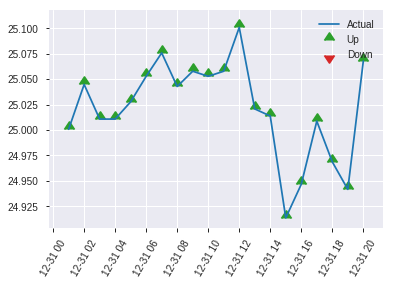


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2522223805033663
RMSE: 0.502217463359615
LogLoss: 0.6985651675219688
Mean Per-Class Error: 0.46521057347670247
AUC: 0.5301299283154122
pr_auc: 0.5514114601627224
Gini: 0.06025985663082434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41126251220703125: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    238  0.9917   (238.0/240.0)
1      0    279  0        (0.0/279.0)
Total  2    517  0.4586   (238.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.411263     0.701005   397
max f2                       0.411263     0.854256   397
max f0point5                 0.488732     0.600565   349
max accuracy                 0.488732     0.55684    349
max precision                0.724009     0.6        13
max recall                   0.411263     1          397
max specificity              0.764892     0.995833   0
max absolute_mcc             0.488732     0.0880584  349
max min_per_class_accuracy   0.587467     0.512545   195
max mean_per_class_accuracy  0.624483     0.534789   122

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 58.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.746746           0.620072  0.620072           0.333333         0.758123  0.333333                    0.758123            0.00716846      0.00716846                 -37.9928  -37.9928
    2        0.0211946                   0.733722           1.11613   0.845552           0.6              0.739926  0.454545                    0.749852            0.0107527       0.0179211                  11.6129   -15.4448
    3        0.0308285                   0.723031           1.48817   1.04637            0.8              0.726864  0.5625                      0.742668            0.0143369       0.0322581                  48.8172   4.6371
    4        0.0404624                   0.714576           1.11613   1.06298            0.6              0.719616  0.571429                    0.73718             0.0107527       0.0430108                  11.6129   6.298
    5        0.0500963                   0.706382           0.744086  1.00165            0.4              0.710908  0.538462                    0.732127            0.00716846      0.0501792                  -25.5914  0.165426
    6        0.100193                    0.682129           1.21629   1.10897            0.653846         0.694353  0.596154                    0.71324             0.0609319       0.111111                   21.6294   10.8974
    7        0.150289                    0.659186           0.858561  1.0255             0.461538         0.669651  0.551282                    0.698711            0.0430108       0.154122                   -14.1439  2.55032
    8        0.200385                    0.641767           1.00165   1.01954            0.538462         0.650097  0.548077                    0.686557            0.0501792       0.204301                   0.165426  1.95409
    9        0.300578                    0.622246           1.21629   1.08513            0.653846         0.630301  0.583333                    0.667805            0.121864        0.326165                   21.6294   8.51254
    10       0.400771                    0.606421           0.965881  1.05531            0.519231         0.61468   0.567308                    0.654524            0.0967742       0.422939                   -3.41191  5.53143
    11       0.500963                    0.586709           0.894334  1.02312            0.480769         0.596042  0.55                        0.642828            0.0896057       0.512545                   -10.5666  2.31183
    12       0.599229                    0.570117           1.05777   1.0288             0.568627         0.579073  0.553055                    0.632373            0.103943        0.616487                   5.77693   2.88006
    13       0.699422                    0.548433           1.0732    1.03516            0.576923         0.559951  0.556474                    0.621998            0.107527        0.724014                   7.3201    3.5161
    14       0.799615                    0.524105           0.930108  1.022              0.5              0.536112  0.549398                    0.611237            0.09319         0.817204                   -6.98925  2.19977
    15       0.899807                    0.484716           1.03743   1.02372            0.557692         0.505245  0.550321                    0.599435            0.103943        0.921147                   3.74276   2.37158
    16       1                           0.343774           0.787014  1                  0.423077         0.455059  0.537572                    0.584969          

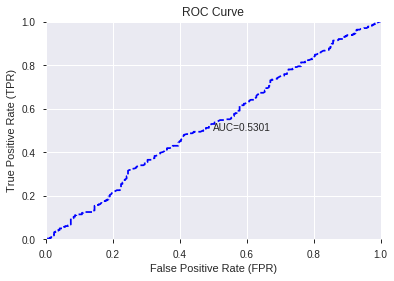

This function is available for GLM models only


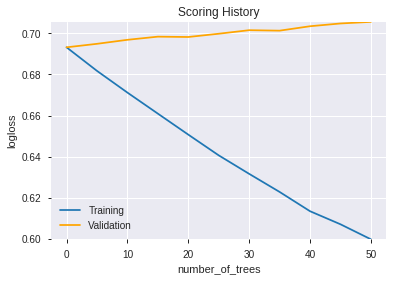

--2019-08-25 15:12:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190825_151038',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190825_151038',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_b222',
   'type

['OBV',
 'BOP',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'WILLR_20',
 'ULTOSC',
 'CORREL_8',
 'HT_DCPERIOD',
 'TRANGE',
 'BETA_12',
 'DX_8',
 'BETA_14',
 'PLUS_DM_8',
 'STOCHRSI_fastd',
 'CORREL_30',
 'HT_PHASOR_inphase',
 'BETA_20',
 'CORREL_12',
 'STDDEV_8',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'ADX_8',
 'STOCH_slowd',
 'WILLR_14',
 'aroonup_8',
 'CCI_14',
 'SIN',
 'ADX_24',
 'Volume',
 'MINUS_DI_8',
 'CCI_12',
 'MFI_24',
 'MFI_12',
 'DIV',
 'DX_12',
 'dayofyear',
 'PLUS_DM_20',
 'CCI_30',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_8',
 'DX_24',
 'DX_14',
 'SAREXT',
 'MFI_8',
 'WILLR_24',
 'WILLR_30',
 'BETA_8',
 'BETA_24',
 'day',
 'ROC_30',
 'ADOSC',
 'MACDFIX_hist_8',
 'AD',
 'aroonup_20',
 'WILLR_8',
 'WILLR_12',
 'MFI_14',
 'hour',
 'STDDEV_12',
 'CMO_20',
 'ADXR_14',
 'PLUS_DI_30',
 'MINUS_DM_24',
 'ADX_14',
 'MACD_signal',
 'AROONOSC_12',
 'STDDEV_20',
 'CORREL_24',
 'aroonup_24',
 'BBANDS_upperband_30_6_5',
 'PLUS_DI_20',
 'BBANDS_upperband_8_6_4',
 'MACDFIX_signal_20',
 'CCI_24',
 'CM

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

372

['BBANDS_upperband_8_5_2',
 'BBANDS_middleband_8_5_2',
 'BBANDS_lowerband_8_5_2',
 'BBANDS_upperband_8_5_3',
 'BBANDS_middleband_8_5_3',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_upperband_8_5_4',
 'BBANDS_middleband_8_5_4',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_upperband_8_5_5',
 'BBANDS_middleband_8_5_5',
 'BBANDS_lowerband_8_5_5',
 'MA_8_6',
 'BBANDS_upperband_8_6_2',
 'BBANDS_middleband_8_6_2',
 'BBANDS_lowerband_8_6_2',
 'BBANDS_upperband_8_6_3',
 'BBANDS_middleband_8_6_3',
 'BBANDS_lowerband_8_6_3',
 'BBANDS_upperband_8_6_4',
 'BBANDS_middleband_8_6_4',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_upperband_8_6_5',
 'BBANDS_middleband_8_6_5',
 'BBANDS_lowerband_8_6_5',
 'MA_8_7',
 'T3_8_7',
 'BBANDS_upperband_8_7_2',
 'BBANDS_middleband_8_7_2',
 'BBANDS_lowerband_8_7_2',
 'BBANDS_upperband_8_7_3',
 'BBANDS_lowerband_8_7_3',
 'BBANDS_middleband_8_7_4',
 'BBANDS_lowerband_8_7_4',
 'BBANDS_upperband_8_7_5',
 'BBANDS_lowerband_8_7_5',
 'MAVP_8_8',
 'BBANDS_upperband_8_8_2',
 'BBANDS_lowerband_8_8_2',

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_151659_model_1  0.544131  1.840722              0.497917  0.615932  0.379372
1  DeepLearning_grid_1_AutoML_20190825_151659_model_4  0.516495  0.824931              0.481004  0.535250  0.286493
2  DeepLearning_grid_1_AutoML_20190825_151659_model_6  0.506989  0.691811              0.495542  0.499332  0.249333
3  DeepLearning_grid_1_AutoML_20190825_151659_model_2  0.505227  0.810643              0.497917  0.541298  0.293003
4               DeepLearning_1_AutoML_20190825_151659  0.502823  0.717624              0.500000  0.510596  0.260708
5  DeepLearning_grid_1_AutoML_20190825_151659_model_8  0.500000  0.690382              0.500000  0.498616  0.248618
6  DeepLearning_grid_1_AutoML_20190825_151659_model_9  0.500000  0.690830              0.500000  0.498840  0.248842
7  DeepLearning_grid_1_AutoML_20190825_151659_model_7  0.497140  0.776249              0.491667  0.532003  0.283027
8  DeepLearning_grid_1_AutoML_20190825_151659_model_3  0.489665  0.756766              0.500000  0.525026  0.275653
9  DeepLearning_grid_1_AutoML_20190825_151659_model_5  0.479309  0.690721              0.497917  0.498785  0.248787

variable  relative_importance  scaled_importance  percentage
0             CDLADVANCEBLOCK             1.000000           1.000000    0.006879
1                       VAR_8             0.828097           0.828097    0.005697
2                   CDLHAMMER             0.824403           0.824403    0.005671
3                      VAR_12             0.764913           0.764913    0.005262
4                      VAR_14             0.748510           0.748510    0.005149
..                        ...                  ...                ...         ...
367   BBANDS_upperband_12_3_4             0.343237           0.343237    0.002361
368  BBANDS_middleband_14_1_4             0.340700           0.340700    0.002344
369   BBANDS_middleband_8_5_5             0.331742           0.331742    0.002282
370              LINEARREG_20             0.327445           0.327445    0.002253
371    BBANDS_lowerband_8_8_2             0.321058           0.321058    0.002209

[372 rows x 4 columns]

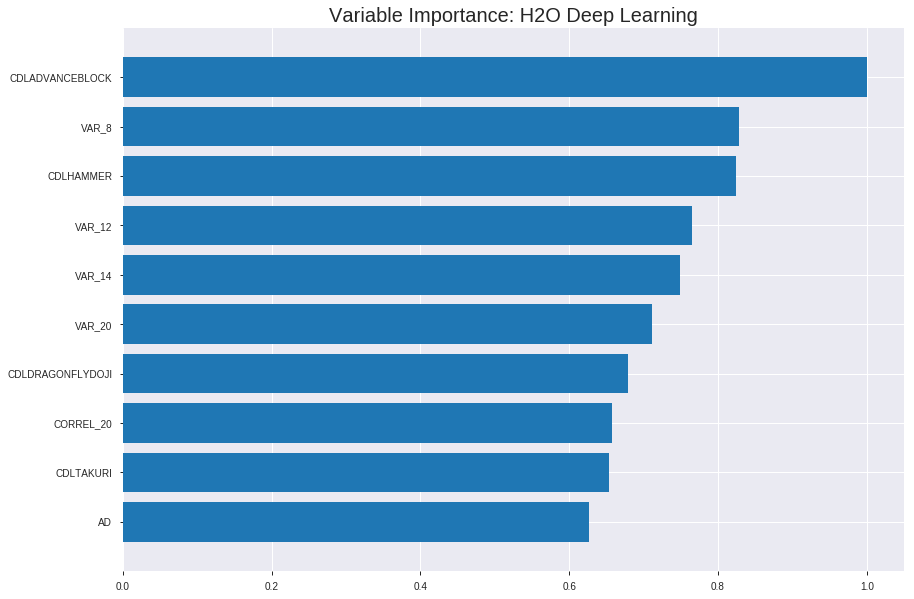

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_151659_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20971059892772836
RMSE: 0.45794169817535546
LogLoss: 0.627456627292493
Mean Per-Class Error: 0.30548021936270464
AUC: 0.7480853408392615
pr_auc: 0.7529073299074345
Gini: 0.49617068167852296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38674379352798227: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      752   934   0.554    (934.0/1686.0)
1      250   1692  0.1287   (250.0/1942.0)
Total  1002  2626  0.3264   (1184.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386744     0.740806  263
max f2                       0.0200409    0.854207  391
max f0point5                 0.590358     0.715596  186
max accuracy                 0.590358     0.696527  186
max precision                0.981852     0.912281  5
max recall                   0.000371236  1         399
max specificity              0.99915      0.998814  0
max absolute_mcc             0.590358     0.389458  186
max min_per_class_accuracy   0.617517     0.688612  175
max mean_per_class_accuracy  0.590358     0.69452   186

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 58.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101985                   0.988732           1.66621   1.66621            0.891892         0.994847  0.891892                    0.994847            0.0169928       0.0169928                  66.6212    66.6212
    2        0.0201213                   0.976579           1.6606    1.66345            0.888889         0.981935  0.890411                    0.98848             0.0164779       0.0334706                  66.0602    66.3445
    3        0.0300441                   0.970787           1.76439   1.69678            0.944444         0.973114  0.908257                    0.983405            0.0175077       0.0509784                  76.439     69.6785
    4        0.0402426                   0.964319           1.66621   1.68904            0.891892         0.967745  0.90411                     0.979436            0.0169928       0.0679712                  66.6212    68.9037
    5        0.0501654                   0.954906           1.55681   1.66288            0.833333         0.960006  0.89011                     0.975593            0.015448        0.0834192                  55.6814    66.2883
    6        0.100055                    0.923667           1.53789   1.60056            0.823204         0.938656  0.856749                    0.957176            0.076725        0.160144                   53.7892    60.0559
    7        0.150221                    0.891252           1.48838   1.5631             0.796703         0.907894  0.836697                    0.940718            0.0746653       0.234809                   48.8383    56.3099
    8        0.20011                     0.858959           1.34178   1.50792            0.718232         0.875418  0.807163                    0.924438            0.0669413       0.301751                   34.1785    50.7923
    9        0.300165                    0.788968           1.36897   1.4616             0.732782         0.823943  0.782369                    0.89094             0.136972        0.438723                   36.8967    46.1604
    10       0.399945                    0.714395           1.22309   1.4021             0.654696         0.752594  0.750517                    0.856425            0.122039        0.560762                   22.3088    40.2098
    11       0.5                         0.630049           1.15281   1.35221            0.61708          0.67198   0.723815                    0.819515            0.115345        0.676107                   15.2815    35.2214
    12       0.600055                    0.527304           0.993273  1.29236            0.53168          0.579432  0.691778                    0.779483            0.0993821       0.775489                   -0.672676  29.2363
    13       0.699835                    0.417609           0.737982  1.21332            0.395028         0.474775  0.649468                    0.736039            0.0736354       0.849125                   -26.2018   21.3322
    14       0.79989                     0.301086           0.669044  1.14524            0.358127         0.358964  0.613025                    0.688872            0.0669413       0.916066                   -33.0956   14.524
    15       0.899945                    0.155573           0.48377   1.0717             0.258953         0.22953   0.57366                     0.637803            0.0484037       0.96447                    -51.623    7.16986
    16       1                           1.65082e-05        0.355108  1                  0.190083         0.076453  0.535281                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3593932617243526
RMSE: 0.5994941715516111
LogLoss: 1.1595444742566023
Mean Per-Class Error: 0.48182957393483705
AUC: 0.5046656820622986
pr_auc: 0.5232362973479527
Gini: 0.009331364124597119
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.007608748504314944: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   493   0.9782   (493.0/504.0)
1      4    528   0.0075   (4.0/532.0)
Total  15   1021  0.4797   (497.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00760875   0.679974   395
max f2                       0.000438289  0.840708   399
max f0point5                 0.00760875   0.571924   395
max accuracy                 0.00760875   0.52027    395
max precision                0.995752     0.722222   2
max recall                   0.000438289  1          399
max specificity              0.999261     0.998016   0
max absolute_mcc             0.00760875   0.0598617  395
max min_per_class_accuracy   0.676071     0.513889   155
max mean_per_class_accuracy  0.670817     0.51817    157

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 58.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.996746           1.23923   1.23923            0.636364         0.997702   0.636364                    0.997702            0.0131579       0.0131579                  23.9234   23.9234
    2        0.0202703                   0.993363           1.36316   1.29825            0.7              0.995509   0.666667                    0.996657            0.0131579       0.0263158                  36.3158   29.8246
    3        0.030888                    0.988704           0.885167  1.15625            0.454545         0.990933   0.59375                     0.99469             0.0093985       0.0357143                  -11.4833  15.625
    4        0.0405405                   0.986269           1.36316   1.20551            0.7              0.98745    0.619048                    0.992966            0.0131579       0.0488722                  36.3158   20.5514
    5        0.0501931                   0.983813           1.16842   1.19838            0.6              0.9854     0.615385                    0.991511            0.0112782       0.0601504                  16.8421   19.8381
    6        0.100386                    0.969784           0.861336  1.02986            0.442308         0.977378   0.528846                    0.984445            0.0432331       0.103383                   -13.8664  2.98583
    7        0.150579                    0.949519           0.861336  0.973684           0.442308         0.960167   0.5                         0.976352            0.0432331       0.146617                   -13.8664  -2.63158
    8        0.200772                    0.923906           1.01113   0.983047           0.519231         0.936957   0.504808                    0.966503            0.0507519       0.197368                   1.11336   -1.69534
    9        0.300193                    0.858631           0.983137  0.983077           0.504854         0.888397   0.504823                    0.940635            0.0977444       0.295113                   -1.68625  -1.69233
    10       0.400579                    0.76174            1.06731   1.00419            0.548077         0.811336   0.515663                    0.908233            0.107143        0.402256                   6.73077   0.418516
    11       0.5                         0.67644            1.13439   1.03008            0.582524         0.718839   0.528958                    0.870573            0.112782        0.515038                   13.4389   3.00752
    12       0.600386                    0.527433           0.898785  1.00812            0.461538         0.610084   0.517685                    0.827019            0.0902256       0.605263                   -10.1215  0.81232
    13       0.699807                    0.362436           0.983137  1.00457            0.504854         0.439144   0.515862                    0.771914            0.0977444       0.703008                   -1.68625  0.45735
    14       0.800193                    0.220864           0.973684  1.0007             0.5              0.287659   0.513872                    0.711163            0.0977444       0.800752                   -2.63158  0.0698368
    15       0.899614                    0.0836069          0.983137  0.998758           0.504854         0.149605   0.512876                    0.649102            0.0977444       0.898496                   -1.68625  -0.124238
    16       1                           1.92361e-05        1.01113   1                  0.519231         0.0362641  0.513514            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:17:02  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:17:07  6.633 sec         511 obs/sec       0.761577  1             2763       0.663221         3.2343              -0.768255      0.519347        0.411941           1.1613           0.464719                         0.655938           3.45889               -0.722279        0.533587          0.400953             1.0622             0.486486
    2019-08-25 15:17:23  22.817 sec        541 obs/sec       3.04906   4             11062      0.600911         1.66905             -0.451602      0.591525        0.566808           1.56523          0.442393                         0.642075           2.12402               -0.650249        0.523507          0.497188             1.0622             0.483591
    2019-08-25 15:17:39  38.461 sec        555 obs/sec       5.34923   7             19407      0.572011         1.29219             -0.315334      0.610571        0.585912           1.46425          0.449559                         0.645049           1.94939               -0.665572        0.508694          0.49608              1.41627            0.486486
    2019-08-25 15:17:54  53.519 sec        567 obs/sec       7.63644   10            27705      0.549084         1.18753             -0.212009      0.614222        0.582462           1.11081          0.427784                         0.620322           1.71362               -0.540321        0.536345          0.518008             1.0622             0.486486
    2019-08-25 15:18:09  1 min  8.318 sec  575 obs/sec       9.91207   13            35961      0.575175         1.75161             -0.329929      0.588349        0.487134           1.31277          0.42613                          0.635246           2.45                  -0.615331        0.516975          0.427658             1.41627            0.482625
    2019-08-25 15:18:23  1 min 22.803 sec  582 obs/sec       12.1808   16            44192      0.513666         0.829118            -0.0606913     0.672626        0.688291           1.51474          0.409316                         0.607986           1.26773               -0.47967         0.506933          0.518102             0.885167           0.486486
    2019-08-25 15:18:38  1 min 37.140 sec  589 obs/sec       14.4573   19            52451      0.541314         0.998793            -0.177949      0.631817        0.621905           1.41376          0.425854                         0.623577           1.5036                -0.556532        0.513874          0.516511             0.885167           0.486486
    2019-08-25 15:18:52  1 min 51.135 sec  596 obs/sec       16.7279   22            60689      0.545559         1.32005             -0.196495      0.637631        0.554134           1.41376          0.391951                         0.626874           1.8904                -0.573033        0.523787          0.462464             1.5933             0.484556
    2019-08-25 15:19:06

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLADVANCEBLOCK           1.0                    1.0                  0.006879079043362572
VAR_8                     0.8280965089797974     0.8280965089797974   0.00569654134080463
CDLHAMMER                 0.8244028091430664     0.8244028091430664   0.005671132087665302
VAR_12                    0.7649133801460266     0.7649133801460266   0.00526189960335016
VAR_14                    0.7485100030899048     0.7485100030899048   0.0051490594760030175
---                       ---                    ---                  ---
BBANDS_upperband_12_3_4   0.3432370126247406     0.3432370126247406   0.0023611545404532276
BBANDS_middleband_14_1_4  0.3407002389431        0.3407002389431      0.0023437038737820996
BBANDS_middleband_8_5_5   0.3317420780658722     0.3317420780658722   0.0022820799770244915
LINEARREG_20              0.3274451196193695     0.3274451196193695   0.002252520860224955
BBANDS_lowerband_8_8_2    0.32105812430381775    0.32105812430381775  0.0022085842145996883


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5568400770712909)

('F1', 0.7001254705144292)

('auc', 0.5441308243727598)

('logloss', 1.8407215426485057)

('mean_per_class_error', 0.44901433691756276)

('rmse', 0.6159315911281941)

('mse', 0.37937172494970883)

deeplearning prediction progress: |███████████████████████████████████████| 100%


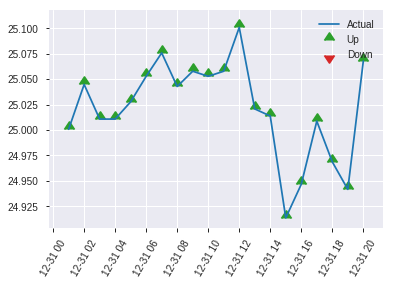


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.37937172494970883
RMSE: 0.6159315911281941
LogLoss: 1.8407215426485057
Mean Per-Class Error: 0.44901433691756276
AUC: 0.5441308243727598
pr_auc: 0.5459290284332186
Gini: 0.08826164874551967
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0009943715910933964: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    239  0.9958   (239.0/240.0)
1      0    279  0        (0.0/279.0)
Total  1    518  0.4605   (239.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000994372  0.700125  398
max f2                       0.000994372  0.853733  398
max f0point5                 0.481963     0.596491  310
max accuracy                 0.841423     0.55684   218
max precision                0.998891     0.627907  16
max recall                   0.000994372  1         398
max specificity              0.999995     0.966667  0
max absolute_mcc             0.945036     0.101688  148
max min_per_class_accuracy   0.945036     0.55      148
max mean_per_class_accuracy  0.945036     0.550986  148

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 78.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.999999           0.930108  0.930108           0.5              1          0.5                         1                   0.0107527       0.0107527                  -6.98925  -6.98925
    2        0.0211946                   0.999997           1.11613   1.01466            0.6              0.999998   0.545455                    0.999999            0.0107527       0.0215054                  11.6129   1.46628
    3        0.0308285                   0.999986           1.48817   1.16263            0.8              0.999991   0.625                       0.999997            0.0143369       0.0358423                  48.8172   16.2634
    4        0.0404624                   0.999976           0.372043  0.974398           0.2              0.999981   0.52381                     0.999993            0.00358423      0.0394265                  -62.7957  -2.56016
    5        0.0500963                   0.999962           1.48817   1.0732             0.8              0.999971   0.576923                    0.999989            0.0143369       0.0537634                  48.8172   7.3201
    6        0.100193                    0.999648           0.930108  1.00165            0.5              0.999866   0.538462                    0.999928            0.046595        0.100358                   -6.98925  0.165426
    7        0.150289                    0.999155           1.35939   1.1209             0.730769         0.999431   0.602564                    0.999762            0.0681004       0.168459                   35.9388   12.0899
    8        0.200385                    0.998117           1.14475   1.12686            0.615385         0.998703   0.605769                    0.999497            0.0573477       0.225806                   14.4748   12.6861
    9        0.300578                    0.992832           1.00165   1.08513            0.538462         0.995737   0.583333                    0.998244            0.100358        0.326165                   0.165426  8.51254
    10       0.400771                    0.980459           1.00165   1.06426            0.538462         0.987504   0.572115                    0.995559            0.100358        0.426523                   0.165426  6.42577
    11       0.500963                    0.950074           1.18052   1.08751            0.634615         0.965757   0.584615                    0.989598            0.11828         0.544803                   18.0521   8.75103
    12       0.599229                    0.878013           0.948345  1.06469            0.509804         0.915844   0.572347                    0.977504            0.09319         0.637993                   -5.16551  6.4689
    13       0.699422                    0.763222           0.930108  1.04541            0.5              0.832162   0.561983                    0.956683            0.09319         0.731183                   -6.98925  4.54101
    14       0.799615                    0.56568            0.858561  1.022              0.461538         0.674481   0.549398                    0.921323            0.0860215       0.817204                   -14.1439  2.19977
    15       0.899807                    0.261815           0.930108  1.01177            0.5              0.406091   0.543897                    0.863953            0.09319         0.910394                   -6.98925  1.17658
    16       1                           1.24677e-05        0.894334  1                  0.480769         0.0951519  0.537572                  

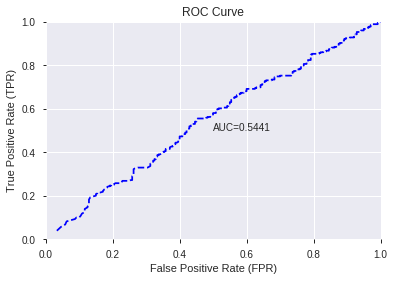

This function is available for GLM models only


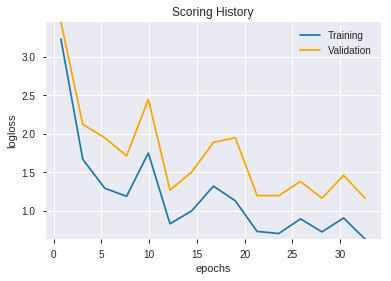

--2019-08-25 15:52:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_151659_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_151659_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLADVANCEBLOCK',
 'VAR_8',
 'CDLHAMMER',
 'VAR_12',
 'VAR_14',
 'VAR_20',
 'CDLDRAGONFLYDOJI',
 'CORREL_20',
 'CDLTAKURI',
 'AD',
 'CDLRICKSHAWMAN',
 'CORREL_8',
 'BBANDS_upperband_30_7_5',
 'CORREL_14',
 'CORREL_12',
 'CDLENGULFING',
 'TRANGE',
 'HT_TRENDMODE',
 'BBANDS_upperband_30_0_4',
 'BBANDS_upperband_24_5_4',
 'STDDEV_8',
 'CDLDOJI',
 'BOP',
 'CDLHARAMI',
 'ATR_14',
 'NATR_24',
 'ATR_30',
 'HT_DCPERIOD',
 'AROONOSC_24',
 'ATR_24',
 'BBANDS_upperband_30_0_3',
 'NATR_30',
 'ATR_20',
 'CDLLONGLEGGEDDOJI',
 'STDDEV_20',
 'CDLMARUBOZU',
 'BBANDS_upperband_14_7_5',
 'BBANDS_upperband_30_5_3',
 'ATR_12',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'MINUS_DM_8',
 'CDLBELTHOLD',
 'NATR_20',
 'BETA_20',
 'WILLR_20',
 'CDLSHORTLINE',
 'NATR_12',
 'aroonup_8',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastk',
 'aroondown_8',
 'PLUS_DM_20',
 'STDDEV_14',
 'BETA_8',
 'aroonup_30',
 'BBANDS_upperband_14_1_5',
 'aroonup_24',
 'ATR_8',
 'BBANDS_upperband_20_0_4',
 'NATR_8',
 'CDLHIKKAKE',
 'PLUS_DM_30

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_155310_model_1  0.518018  0.690173              0.495833  0.498514  0.248516

variable  relative_importance  scaled_importance  percentage
0        HT_PHASOR_quadrature             0.006107           1.000000    0.018944
1                         OBV             0.005698           0.933057    0.017676
2                  CDLHIKKAKE             0.004963           0.812671    0.015395
3                STOCHF_fastk             0.004707           0.770760    0.014601
4                     WILLR_8             0.004330           0.709109    0.013433
..                        ...                  ...                ...         ...
367                 MAVP_14_6             0.000013           0.002053    0.000039
368  BBANDS_middleband_20_2_2             0.000011           0.001775    0.000034
369   BBANDS_upperband_14_1_2             0.000009           0.001394    0.000026
370  BBANDS_middleband_20_3_3             0.000007           0.001226    0.000023
371  BBANDS_middleband_20_3_5             0.000005           0.000803    0.000015

[372 rows x 4 columns]

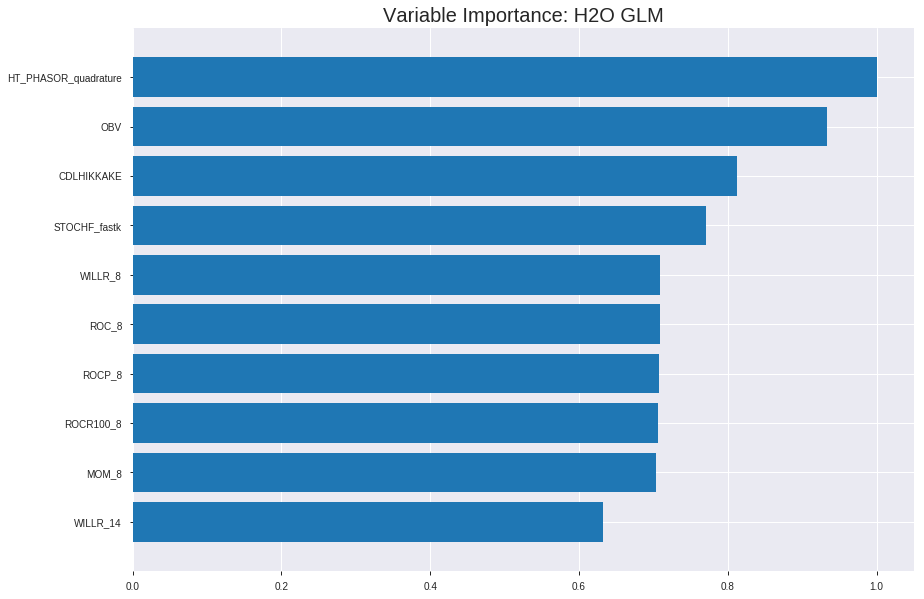

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_155310_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24767026937234007
RMSE: 0.4976648162893777
LogLoss: 0.6884659474446946
Null degrees of freedom: 3627
Residual degrees of freedom: 3255
Null deviance: 5011.396974952616
Residual deviance: 4995.508914658704
AIC: 5741.508914658704
AUC: 0.5427892268429778
pr_auc: 0.5807010280634202
Gini: 0.08557845368595562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46826014470157185: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      6    1680  0.9964   (1680.0/1686.0)
1      1    1941  0.0005   (1.0/1942.0)
Total  7    3621  0.4633   (1681.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.46826      0.697825   393
max f2                       0.46826      0.852138   393
max f0point5                 0.510775     0.591896   336
max accuracy                 0.527764     0.544653   246
max precision                0.655285     1          0
max recall                   0.438065     1          399
max specificity              0.655285     1          0
max absolute_mcc             0.55915      0.0789083  72
max min_per_class_accuracy   0.534488     0.530896   203
max mean_per_class_accuracy  0.533256     0.535406   210

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101985                   0.574625           1.46425   1.46425            0.783784         0.593103  0.783784                    0.593103            0.0149331       0.0149331                  46.4247    46.4247
    2        0.0201213                   0.570167           1.34924   1.40753            0.722222         0.572407  0.753425                    0.582897            0.0133883       0.0283213                  34.9239    40.7531
    3        0.0300441                   0.566616           0.934089  1.25116            0.5              0.568304  0.669725                    0.578077            0.0092688       0.0375901                  -6.59114   25.1165
    4        0.0402426                   0.564147           1.36326   1.27957            0.72973          0.565217  0.684932                    0.574818            0.0139032       0.0514933                  36.3264    27.9573
    5        0.0501654                   0.562116           1.19356   1.26256            0.638889         0.563021  0.675824                    0.572484            0.0118435       0.0633368                  19.3558    26.2559
    6        0.100055                    0.555606           1.10439   1.18369            0.59116          0.558868  0.633609                    0.565695            0.0550978       0.118435                   10.4392    18.3694
    7        0.150221                    0.551501           1.10859   1.15861            0.593407         0.553714  0.620183                    0.561694            0.0556128       0.174047                   10.8589    15.8613
    8        0.20011                     0.548423           0.897964  1.09363            0.480663         0.549966  0.585399                    0.55877             0.0447992       0.218847                   -10.2036   9.36299
    9        0.300165                    0.543324           1.02415   1.07047            0.548209         0.545896  0.573003                    0.554479            0.102472        0.321318                   2.41522    7.04706
    10       0.399945                    0.53864            1.05795   1.06735            0.566298         0.540925  0.57133                     0.551097            0.105561        0.42688                    5.79456    6.73459
    11       0.5                         0.534458           1.01901   1.05767            0.545455         0.536548  0.566152                    0.548186            0.101957        0.528836                   1.90057    5.76725
    12       0.600055                    0.530541           0.967541  1.04264            0.517906         0.532454  0.558107                    0.545563            0.0968074       0.625644                   -3.24592   4.26436
    13       0.699835                    0.526663           0.990856  1.03526            0.530387         0.528649  0.554155                    0.543151            0.0988671       0.724511                   -0.914362  3.526
    14       0.79989                     0.522245           0.957248  1.0255             0.512397         0.524495  0.548932                    0.540817            0.0957775       0.820288                   -4.27522   2.55018
    15       0.899945                    0.5163             0.88005   1.00933            0.471074         0.519249  0.540276                    0.538419            0.0880536       0.908342                   -11.995    0.933062
    16       1                           0.438065           0.916076  1                  0.490358         0.507054  0.535281                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2505544517121615
RMSE: 0.500554144635884
LogLoss: 0.6942644134764046
Null degrees of freedom: 1035
Residual degrees of freedom: 663
Null deviance: 1437.4140588309256
Residual deviance: 1438.51586472311
AIC: 2184.51586472311
AUC: 0.496046664279747
pr_auc: 0.5164812772221764
Gini: -0.007906671440506052
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48432652578168756: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    502   0.996    (502.0/504.0)
1      1    531   0.0019   (1.0/532.0)
Total  3    1033  0.4855   (503.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.484327     0.678594   396
max f2                       0.480243     0.840708   399
max f0point5                 0.503354     0.570388   371
max accuracy                 0.507864     0.519305   353
max precision                0.597915     0.666667   2
max recall                   0.480243     1          399
max specificity              0.600704     0.998016   0
max absolute_mcc             0.571447     0.0398216  26
max min_per_class_accuracy   0.532829     0.498016   208
max mean_per_class_accuracy  0.55254      0.511069   92

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 53.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.585514           1.23923   1.23923            0.636364         0.592728  0.636364                    0.592728            0.0131579       0.0131579                  23.9234   23.9234
    2        0.0202703                   0.575632           1.16842   1.20551            0.6              0.580355  0.619048                    0.586836            0.0112782       0.0244361                  16.8421   20.5514
    3        0.030888                    0.571386           1.23923   1.21711            0.636364         0.573149  0.625                       0.582131            0.0131579       0.037594                   23.9234   21.7105
    4        0.0405405                   0.56852            0.584211  1.06642            0.3              0.569822  0.547619                    0.5792              0.0056391       0.0432331                  -41.5789  6.6416
    5        0.0501931                   0.566467           0.778947  1.01113            0.4              0.567227  0.519231                    0.576898            0.0075188       0.0507519                  -22.1053  1.11336
    6        0.100386                    0.557928           1.01113   1.01113            0.519231         0.561473  0.519231                    0.569186            0.0507519       0.101504                   1.11336   1.11336
    7        0.150579                    0.553448           1.04858   1.02362            0.538462         0.555238  0.525641                    0.564536            0.0526316       0.154135                   4.8583    2.36167
    8        0.200772                    0.549193           0.898785  0.992409           0.461538         0.551175  0.509615                    0.561196            0.0451128       0.199248                   -10.1215  -0.759109
    9        0.300193                    0.543381           1.02095   1.00186            0.524272         0.546181  0.514469                    0.556223            0.101504        0.300752                   2.09504   0.186157
    10       0.400579                    0.537309           0.898785  0.97603            0.461538         0.540002  0.501205                    0.552158            0.0902256       0.390977                   -10.1215  -2.39696
    11       0.5                         0.532833           1.07767   0.996241           0.553398         0.535037  0.511583                    0.548754            0.107143        0.49812                    7.76699   -0.37594
    12       0.600386                    0.52797            0.95496   0.989338           0.490385         0.530427  0.508039                    0.545689            0.0958647       0.593985                   -4.50405  -1.06617
    13       0.699807                    0.522797           0.983137  0.988457           0.504854         0.525343  0.507586                    0.542799            0.0977444       0.691729                   -1.68625  -1.15426
    14       0.800193                    0.517362           1.02986   0.993651           0.528846         0.520233  0.510253                    0.539968            0.103383        0.795113                   2.98583   -0.63488
    15       0.899614                    0.510647           1.07767   1.00294            0.553398         0.514249  0.515021                    0.537126            0.107143        0.902256                   7.76699   0.293653
    16       1                           0.480243           0.973684  1                  0.5              0.5036    0.513514                    0.53376  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:53:11  0.000 sec   2            2.4       373           1.37693           1.38853
    2019-08-25 15:53:12  0.313 sec   3            1.7       373           1.37612           1.38889
    2019-08-25 15:53:12  0.651 sec   4            1.3       373           1.37519           1.38938
    2019-08-25 15:53:13  1.260 sec   6            0.92      373           1.37413           1.38998
    2019-08-25 15:53:13  1.908 sec   8            0.67      373           1.37291           1.39073

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5433526011560693)

('F1', 0.7010050251256281)

('auc', 0.518018219832736)

('logloss', 0.6901730253267356)

('mean_per_class_error', 0.4673835125448028)

('rmse', 0.4985139777686968)

('mse', 0.24851618603076878)

glm prediction progress: |████████████████████████████████████████████████| 100%


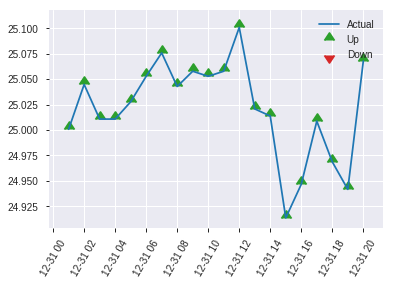


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24851618603076878
RMSE: 0.4985139777686968
LogLoss: 0.6901730253267356
Null degrees of freedom: 518
Residual degrees of freedom: 146
Null deviance: 716.5643274932833
Residual deviance: 716.3996002891516
AIC: 1462.3996002891517
AUC: 0.518018219832736
pr_auc: 0.5545668281529739
Gini: 0.036036439665471987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4773698939492159: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    238  0.9917   (238.0/240.0)
1      0    279  0        (0.0/279.0)
Total  2    517  0.4586   (238.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.47737      0.701005   397
max f2                       0.47737      0.854256   397
max f0point5                 0.494977     0.595187   392
max accuracy                 0.494977     0.543353   392
max precision                0.61626      1          0
max recall                   0.47737      1          397
max specificity              0.61626      1          0
max absolute_mcc             0.562808     0.0767008  104
max min_per_class_accuracy   0.547131     0.508961   199
max mean_per_class_accuracy  0.562808     0.532616   104

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 54.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.604967           1.24014   1.24014            0.666667         0.60988   0.666667                    0.60988             0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.599905           0.744086  1.01466            0.4              0.601452  0.545455                    0.606049            0.00716846      0.0215054                  -25.5914  1.46628
    3        0.0308285                   0.597981           1.11613   1.04637            0.6              0.599078  0.5625                      0.603871            0.0107527       0.0322581                  11.6129   4.6371
    4        0.0404624                   0.592343           0.744086  0.974398           0.4              0.594901  0.52381                     0.601735            0.00716846      0.0394265                  -25.5914  -2.56016
    5        0.0500963                   0.589788           1.11613   1.00165            0.6              0.590855  0.538462                    0.599643            0.0107527       0.0501792                  11.6129   0.165426
    6        0.100193                    0.577178           1.14475   1.0732             0.615385         0.583969  0.576923                    0.591806            0.0573477       0.107527                   14.4748   7.3201
    7        0.150289                    0.569435           1.0732    1.0732             0.576923         0.572631  0.576923                    0.585414            0.0537634       0.16129                    7.3201    7.3201
    8        0.200385                    0.565189           1.21629   1.10897            0.653846         0.567291  0.596154                    0.580883            0.0609319       0.222222                   21.6294   10.8974
    9        0.300578                    0.556822           0.930108  1.04935            0.5              0.561101  0.564103                    0.574289            0.09319         0.315412                   -6.98925  4.93521
    10       0.400771                    0.551638           0.894334  1.0106             0.480769         0.554439  0.543269                    0.569327            0.0896057       0.405018                   -10.5666  1.05976
    11       0.500963                    0.547014           1.03743   1.01596            0.557692         0.549112  0.546154                    0.565284            0.103943        0.508961                   3.74276   1.59636
    12       0.599229                    0.540727           0.98482   1.01086            0.529412         0.543656  0.543408                    0.561737            0.0967742       0.605735                   -1.51803  1.08564
    13       0.699422                    0.534391           1.03743   1.01466            0.557692         0.537475  0.545455                    0.558262            0.103943        0.709677                   3.74276   1.46628
    14       0.799615                    0.527086           0.965881  1.00855            0.519231         0.530835  0.542169                    0.554825            0.0967742       0.806452                   -3.41191  0.855033
    15       0.899807                    0.518235           0.930108  0.999816           0.5              0.523641  0.537473                    0.551353            0.09319         0.899642                   -6.98925  -0.01842
    16       1                           0.475193           1.00165   1                  0.538462         0.506917  0.537572                    0.546901        

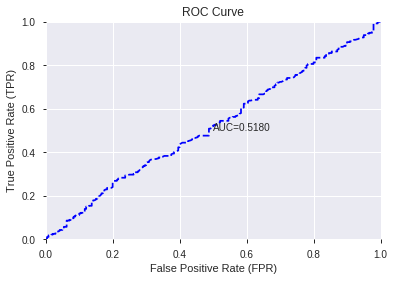

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


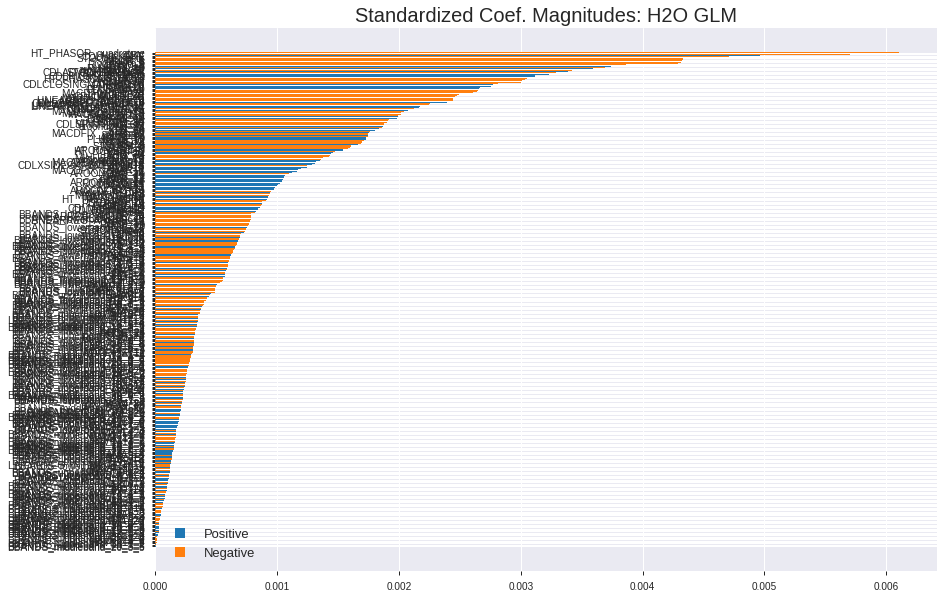

'log_likelihood'
--2019-08-25 15:53:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_155310_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_155310_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['HT_PHASOR_quadrature',
 'OBV',
 'CDLHIKKAKE',
 'STOCHF_fastk',
 'WILLR_8',
 'ROC_8',
 'ROCP_8',
 'ROCR100_8',
 'MOM_8',
 'WILLR_14',
 'PLUS_DI_30',
 'aroondown_30',
 'BETA_12',
 'STOCHRSI_fastk',
 'CDLADVANCEBLOCK',
 'CDLHAMMER',
 'BETA_20',
 'CDLRICKSHAWMAN',
 'PLUS_DI_24',
 'HT_PHASOR_inphase',
 'WILLR_12',
 'BOP',
 'CORREL_8',
 'CDLCLOSINGMARUBOZU',
 'MFI_20',
 'CDLDOJI',
 'PLUS_DI_20',
 'CDLHARAMI',
 'BETA_8',
 'MACDFIX_hist_24',
 'WILLR_20',
 'WILLR_30',
 'CDLLONGLINE',
 'MACDFIX_hist_20',
 'LINEARREG_SLOPE_8',
 'STOCHRSI_fastd',
 'LINEARREG_ANGLE_8',
 'CDLLONGLEGGEDDOJI',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'MFI_14',
 'CDLHIGHWAVE',
 'CDLENGULFING',
 'MACDFIX_signal_24',
 'MACDFIX_hist_12',
 'MACDFIX_hist_8',
 'MACD_hist',
 'aroonup_30',
 'PLUS_DI_14',
 'CORREL_12',
 'WILLR_24',
 'ATR_30',
 'MINUS_DM_30',
 'CDLSPINNINGTOP',
 'aroondown_20',
 'DX_24',
 'ATR_24',
 'DX_20',
 'DX_30',
 'ATR_20',
 'MACDFIX_signal_20',
 'ULTOSC',
 'ADXR_14',
 'NATR_30',
 'PLUS_DI_12',
 'AD

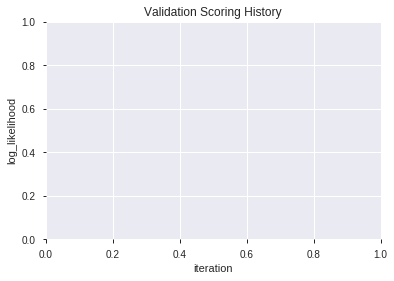

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190825_155424  0.522469  0.699709              0.500000  0.502804  0.252812
1               XGBoost_2_AutoML_20190825_155424  0.517824  0.706620              0.479794  0.505759  0.255793
2  XGBoost_grid_1_AutoML_20190825_155424_model_7  0.516950  0.718213              0.500000  0.510717  0.260832
3  XGBoost_grid_1_AutoML_20190825_155424_model_5  0.516047  0.729012              0.500000  0.515051  0.265277
4  XGBoost_grid_1_AutoML_20190825_155424_model_6  0.514710  0.711543              0.500000  0.507991  0.258055
5  XGBoost_grid_1_AutoML_20190825_155424_model_3  0.511649  0.701287              0.484543  0.503597  0.253610
6  XGBoost_grid_1_AutoML_20190825_155424_model_1  0.501680  0.706803              0.500000  0.506073  0.256110
7               XGBoost_1_AutoML_20190825_155424  0.494810  0.715346              0.493750  0.510003  0.260103
8  XGBoost_grid_1_AutoML_20190825_155424_model_2  0.488784  0.700244              0.497625  0.503340  0.253351
9  XGBoost_grid_1_AutoML_20190825_155424_model_4  0.484774  0.707365              0.493750  0.506463  0.256504

variable  relative_importance  scaled_importance  percentage
0                        OBV           258.117889           1.000000    0.038019
1                        BOP           193.861038           0.751056    0.028554
2       HT_PHASOR_quadrature           166.297211           0.644268    0.024494
3               STOCHF_fastk           130.859329           0.506975    0.019274
4             STOCHRSI_fastd           121.261292           0.469790    0.017861
..                       ...                  ...                ...         ...
227                  ROCR_14             2.183215           0.008458    0.000322
228           MACDFIX_hist_8             1.559778           0.006043    0.000230
229  BBANDS_middleband_8_5_2             1.034966           0.004010    0.000152
230                  NATR_30             0.711442           0.002756    0.000105
231   BBANDS_lowerband_8_5_5             0.658931           0.002553    0.000097

[232 rows x 4 columns]

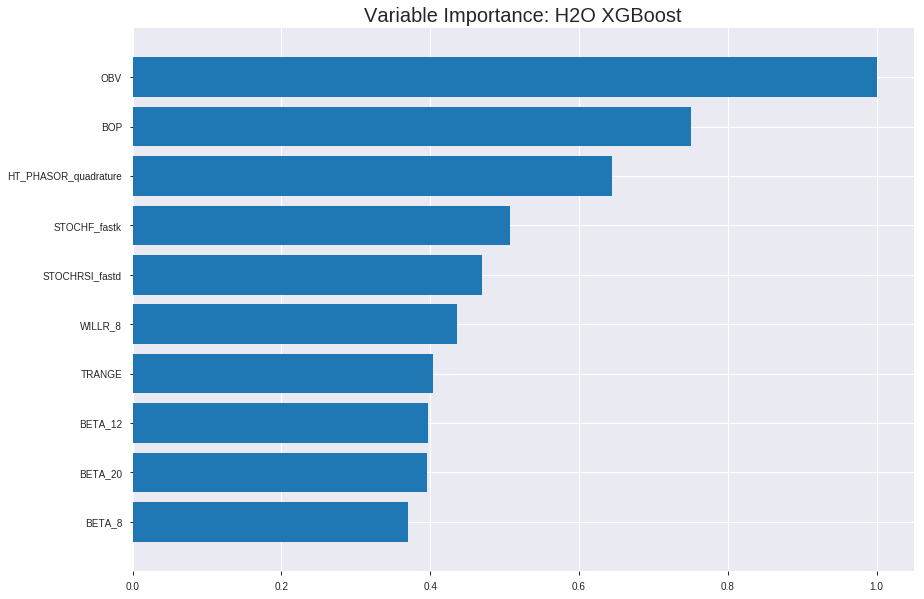

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190825_155424


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2054261898260791
RMSE: 0.45323966047343994
LogLoss: 0.602251485801785
Mean Per-Class Error: 0.17789501718276024
AUC: 0.9046689707325
pr_auc: 0.911959535211416
Gini: 0.8093379414649999
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5063327749570211: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1158  528   0.3132   (528.0/1686.0)
1      154   1788  0.0793   (154.0/1942.0)
Total  1312  2316  0.188    (682.0/3628.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506333     0.839831  239
max f2                       0.476866     0.901182  279
max f0point5                 0.544916     0.846452  183
max accuracy                 0.529911     0.82194   204
max precision                0.849103     1         0
max recall                   0.412818     1         348
max specificity              0.849103     1         0
max absolute_mcc             0.529911     0.64314   204
max min_per_class_accuracy   0.529911     0.819773  204
max mean_per_class_accuracy  0.529911     0.822105  204

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101985                   0.723596           1.86818    1.86818            1                0.753782  1                           0.753782            0.0190525       0.0190525                  86.8177   86.8177
    2        0.0201213                   0.693568           1.86818    1.86818            1                0.708342  1                           0.731373            0.0185376       0.0375901                  86.8177   86.8177
    3        0.0300441                   0.676559           1.81628    1.85104            0.972222         0.683452  0.990826                    0.715546            0.0180227       0.0556128                  81.6283   85.1038
    4        0.0402426                   0.664755           1.81769    1.84259            0.972973         0.67062   0.986301                    0.704161            0.0185376       0.0741504                  81.7686   84.2586
    5        0.0501654                   0.653489           1.86818    1.84765            1                0.659171  0.989011                    0.695261            0.0185376       0.092688                   86.8177   84.7648
    6        0.100055                    0.62317            1.82689    1.8373             0.977901         0.636797  0.983471                    0.66611             0.0911432       0.183831                   82.6891   83.7298
    7        0.150221                    0.603167           1.80659    1.82704            0.967033         0.612662  0.977982                    0.648261            0.0906282       0.274459                   80.6589   82.7043
    8        0.20011                     0.590574           1.71336    1.7987             0.917127         0.596652  0.96281                     0.635394            0.0854789       0.359938                   71.3356   79.8699
    9        0.300165                    0.568392           1.64688    1.74809            0.881543         0.579086  0.935721                    0.616625            0.164779        0.524717                   64.6878   74.8092
    10       0.399945                    0.550988           1.46048    1.67634            0.781768         0.559694  0.897312                    0.602421            0.145726        0.670443                   46.0481   67.6338
    11       0.5                         0.533256           1.26089    1.5932             0.674931         0.541696  0.852811                    0.590269            0.126159        0.796601                   26.0891   59.3203
    12       0.600055                    0.514967           0.926369   1.48201            0.495868         0.524264  0.793294                    0.579263            0.092688        0.889289                   -7.36312  48.2013
    13       0.699835                    0.494216           0.645089   1.36269            0.345304         0.504121  0.729421                    0.56855             0.0643666       0.953656                   -35.4911  36.2688
    14       0.79989                     0.469833           0.344815   1.23537            0.184573         0.482667  0.661268                    0.557807            0.0345005       0.988157                   -65.5185  23.5366
    15       0.899945                    0.438607           0.10293    1.10946            0.0550964        0.454067  0.593874                    0.546274            0.0102987       0.998455                   -89.707   10.9463
    16       1                           0.277649           0.0154395  1                  0.00826446       0.403826  0.535281                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25548683932296506
RMSE: 0.5054570598210743
LogLoss: 0.7047151393012883
Mean Per-Class Error: 0.48062865497076024
AUC: 0.5022377372001432
pr_auc: 0.5100246738607463
Gini: 0.004475474400286394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3441038727760315: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    504   1        (504.0/504.0)
1      0    532   0        (0.0/532.0)
Total  0    1036  0.4865   (504.0/1036.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.344104     0.678571   399
max f2                       0.344104     0.840708   399
max f0point5                 0.344104     0.568862   399
max accuracy                 0.499874     0.525097   267
max precision                0.765689     1          0
max recall                   0.344104     1          399
max specificity              0.765689     1          0
max absolute_mcc             0.428258     0.0468537  360
max min_per_class_accuracy   0.540888     0.503968   198
max mean_per_class_accuracy  0.499874     0.519371   267

Gains/Lift Table: Avg response rate: 51.35 %, avg score: 54.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0106178                   0.717278           1.0622    1.0622             0.545455         0.738544  0.545455                    0.738544            0.0112782       0.0112782                  6.2201    6.2201
    2        0.0202703                   0.697241           0.584211  0.834586           0.3              0.708982  0.428571                    0.724467            0.0056391       0.0169173                  -41.5789  -16.5414
    3        0.030888                    0.679612           1.0622    0.912829           0.545455         0.686655  0.46875                     0.711469            0.0112782       0.0281955                  6.2201    -8.71711
    4        0.0405405                   0.666775           1.16842   0.973684           0.6              0.672568  0.5                         0.702207            0.0112782       0.0394737                  16.8421   -2.63158
    5        0.0501931                   0.654382           0.778947  0.936235           0.4              0.66022   0.480769                    0.694133            0.0075188       0.0469925                  -22.1053  -6.37652
    6        0.100386                    0.626198           1.04858   0.992409           0.538462         0.639547  0.509615                    0.66684             0.0526316       0.0996241                  4.8583    -0.759109
    7        0.150579                    0.610078           0.898785  0.961201           0.461538         0.618099  0.49359                     0.650593            0.0451128       0.144737                   -10.1215  -3.87989
    8        0.200772                    0.599372           0.936235  0.95496            0.480769         0.604028  0.490385                    0.638952            0.0469925       0.191729                   -6.37652  -4.50405
    9        0.300193                    0.577489           0.983137  0.964292           0.504854         0.58802   0.495177                    0.622084            0.0977444       0.289474                   -1.68625  -3.57082
    10       0.400579                    0.55867            1.08603   0.9948             0.557692         0.568617  0.510843                    0.608685            0.109023        0.398496                   8.60324   -0.519975
    11       0.5                         0.540831           1.05876   1.00752            0.543689         0.549863  0.517375                    0.596989            0.105263        0.503759                   5.87634   0.75188
    12       0.600386                    0.522981           1.04858   1.01438            0.538462         0.531836  0.5209                      0.586095            0.105263        0.609023                   4.8583    1.43848
    13       0.699807                    0.502949           1.03986   1.018              0.533981         0.51315   0.522759                    0.575732            0.103383        0.712406                   3.98569   1.80036
    14       0.800193                    0.476641           0.95496   1.01009            0.490385         0.49059   0.518697                    0.565051            0.0958647       0.808271                   -4.50405  1.00946
    15       0.899614                    0.44867            0.907511  0.998758           0.466019         0.464184  0.512876                    0.553903            0.0902256       0.898496                   -9.24885  -0.124238
    16       1                           0.344104           1.01113   1                  0.519231         0.419067  0.513514                    0.540


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:54:34  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.464719                         0.5                0.693147              0.5               0                    1                  0.486486
    2019-08-25 15:54:35  0.324 sec   5                  0.494258         0.681714            0.708653        0.735999           1.76985          0.371555                         0.500054           0.693257              0.50317           0.515331             1.11278            0.486486
    2019-08-25 15:54:35  0.451 sec   10                 0.489662         0.672605            0.758268        0.777017           1.86818          0.339857                         0.500803           0.694777              0.49893           0.507088             0.708134           0.484556
    2019-08-25 15:54:35  0.597 sec   15                 0.484195         0.661818            0.796634        0.81273            1.86818          0.285832                         0.502112           0.697466              0.492841          0.506131             0.811404           0.485521
    2019-08-25 15:54:35  0.744 sec   20                 0.478911         0.651456            0.820665        0.833335           1.86818          0.264609                         0.503623           0.700653              0.486514          0.498013             0.885167           0.485521
    2019-08-25 15:54:35  0.886 sec   25                 0.473546         0.641081            0.851267        0.860467           1.86818          0.235391                         0.503302           0.700048              0.498603          0.505699             0.885167           0.48166
    2019-08-25 15:54:35  1.029 sec   30                 0.46883          0.631996            0.868995        0.878113           1.86818          0.219129                         0.503886           0.701245              0.495101          0.506768             0.708134           0.482625
    2019-08-25 15:54:35  1.180 sec   35                 0.465357         0.625291            0.876028        0.884336           1.86818          0.205899                         0.504768           0.703151              0.495942          0.509369             1.0622             0.486486
    2019-08-25 15:54:36  1.325 sec   40                 0.462352         0.619495            0.882341        0.890366           1.86818          0.208379                         0.504628           0.702871              0.4995            0.511238             1.0622             0.483591
    2019-08-25 15:54:36  1.480 sec   45                 0.457758         0.610779            0.894767        0.901822           1.86818          0.189085                         0.504956           0.703627              0.502307          0.510846             1.0622             0.486486
    2019-08-25 15:54:36  1.629 sec   50                 0.45324          0.602251            0.904669        0.91196            1.86818          0.187982                         0.505457           0.704715              0.502238          0.510025             1.0622             0.486486

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
OBV                      258.1178894042969      1.0                    0.03801858333024015
BOP                      193.8610382080078      0.7510561885323576     0.028554092289409992
HT_PHASOR_quadrature     166.29721069335938     0.6442684429085954     0.0244941734837645
STOCHF_fastk             130.8593292236328      0.5069750474313867     0.019274473087122622
STOCHRSI_fastd           121.26129150390625     0.4697903418618594     0.01786076325981711
---                      ---                    ---                    ---
ROCR_14                  2.1832146644592285     0.008458207486113454   0.0003215690661352654
MACDFIX_hist_8           1.5597782135009766     0.006042890777933856   0.000229742146596418
BBANDS_middleband_8_5_2  1.0349655151367188     0.004009662087061408   0.00015244167218304876
NATR_30                  0.7114419937133789     0.0027562676703861795  0.00010478939210702385
BBANDS_lowerband_8_5_5   0.658930778503418      0.002552828786970737   9.705493396528283e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5510597302504817)

('F1', 0.6992481203007519)

('auc', 0.5224686379928315)

('logloss', 0.6997094094366442)

('mean_per_class_error', 0.46507616487455206)

('rmse', 0.5028039491849213)

('mse', 0.25281181131595293)

xgboost prediction progress: |████████████████████████████████████████████| 100%


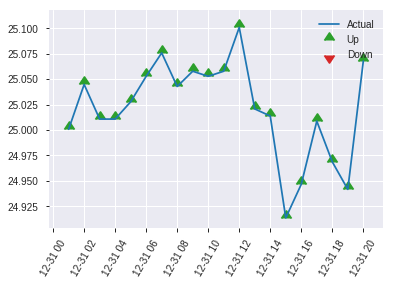


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25281181131595293
RMSE: 0.5028039491849213
LogLoss: 0.6997094094366442
Mean Per-Class Error: 0.46507616487455206
AUC: 0.5224686379928315
pr_auc: 0.5556205461343128
Gini: 0.044937275985662994
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3719291687011719: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    240  1        (240.0/240.0)
1      0    279  0        (0.0/279.0)
Total  0    519  0.4624   (240.0/519.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371929     0.699248  399
max f2                       0.371929     0.853211  399
max f0point5                 0.468766     0.5976    360
max accuracy                 0.491258     0.55106   336
max precision                0.719398     0.76      23
max recall                   0.371929     1         399
max specificity              0.796808     0.995833  0
max absolute_mcc             0.719398     0.100359  23
max min_per_class_accuracy   0.569694     0.512545  201
max mean_per_class_accuracy  0.534099     0.534924  273

Gains/Lift Table: Avg response rate: 53.76 %, avg score: 57.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115607                   0.766887           1.24014   1.24014            0.666667         0.778429  0.666667                    0.778429            0.0143369       0.0143369                  24.0143   24.0143
    2        0.0211946                   0.744468           0.744086  1.01466            0.4              0.754065  0.545455                    0.767355            0.00716846      0.0215054                  -25.5914  1.46628
    3        0.0308285                   0.736089           1.86022   1.2789             1                0.739932  0.6875                      0.758785            0.0179211       0.0394265                  86.0215   27.8898
    4        0.0404624                   0.728554           1.48817   1.32873            0.8              0.732553  0.714286                    0.752539            0.0143369       0.0537634                  48.8172   32.8725
    5        0.0500963                   0.718215           1.48817   1.35939            0.8              0.723249  0.730769                    0.746907            0.0143369       0.0681004                  48.8172   35.9388
    6        0.100193                    0.681672           0.787014  1.0732             0.423077         0.698099  0.576923                    0.722503            0.0394265       0.107527                   -21.2986  7.3201
    7        0.150289                    0.65651            0.858561  1.00165            0.461538         0.668004  0.538462                    0.704337            0.0430108       0.150538                   -14.1439  0.165426
    8        0.200385                    0.642235           1.00165   1.00165            0.538462         0.652005  0.538462                    0.691254            0.0501792       0.200717                   0.165426  0.165426
    9        0.300578                    0.609392           1.10897   1.03743            0.596154         0.623586  0.557692                    0.668698            0.111111        0.311828                   10.8974   3.74276
    10       0.400771                    0.589198           1.00165   1.02848            0.538462         0.597396  0.552885                    0.650873            0.100358        0.412186                   0.165426  2.84843
    11       0.500963                    0.569583           1.03743   1.03027            0.557692         0.579017  0.553846                    0.636501            0.103943        0.516129                   3.74276   3.0273
    12       0.599229                    0.551115           0.98482   1.02282            0.529412         0.559676  0.549839                    0.623903            0.0967742       0.612903                   -1.51803  2.28192
    13       0.699422                    0.530224           1.10897   1.03516            0.596154         0.541284  0.556474                    0.612068            0.111111        0.724014                   10.8974   3.5161
    14       0.799615                    0.505129           0.894334  1.01752            0.480769         0.518652  0.546988                    0.600363            0.0896057       0.81362                    -10.5666  1.75152
    15       0.899807                    0.472214           1.00165   1.01575            0.538462         0.489458  0.546039                    0.588013            0.100358        0.913978                   0.165426  1.57491
    16       1                           0.371929           0.858561  1                  0.461538         0.436839  0.537572                    0.572867          

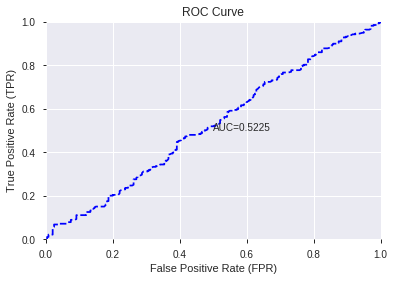

This function is available for GLM models only


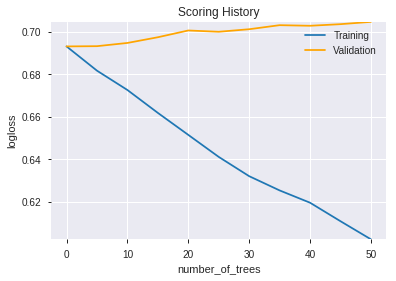

--2019-08-25 15:55:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190825_155424',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190825_155424',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b222',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_b222',
   'ty

['OBV',
 'BOP',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'WILLR_8',
 'TRANGE',
 'BETA_12',
 'BETA_20',
 'BETA_8',
 'CCI_8',
 'ULTOSC',
 'HT_DCPERIOD',
 'WILLR_20',
 'CORREL_14',
 'STOCH_slowk',
 'CCI_14',
 'PLUS_DI_30',
 'MFI_8',
 'CORREL_8',
 'MFI_24',
 'ADX_20',
 'DX_8',
 'MACDEXT_hist',
 'ADX_14',
 'PLUS_DM_8',
 'HT_PHASOR_inphase',
 'DX_12',
 'aroondown_30',
 'CCI_12',
 'CORREL_12',
 'AD',
 'STDDEV_8',
 'BETA_24',
 'MFI_12',
 'AROONOSC_24',
 'CCI_30',
 'MINUS_DM_8',
 'NATR_8',
 'WILLR_12',
 'MINUS_DI_8',
 'MACDFIX_hist_24',
 'ADX_8',
 'DX_14',
 'DX_20',
 'MINUS_DI_30',
 'STOCHF_fastd',
 'MFI_20',
 'MACDFIX_hist_12',
 'MACDFIX_hist_20',
 'ADXR_12',
 'LINEARREG_ANGLE_20',
 'MOM_30',
 'PLUS_DI_8',
 'APO',
 'DX_30',
 'MACDFIX_signal_24',
 'CMO_30',
 'DX_24',
 'BBANDS_upperband_14_5_3',
 'WILLR_30',
 'LINEARREG_INTERCEPT_20',
 'LINEARREG_ANGLE_8',
 'BBANDS_upperband_12_0_2',
 'ADX_12',
 'STOCHRSI_fastk',
 'MACD_hist',
 'MOM_8',
 'PLUS_DI_20',
 'MOM_24',
 'MACDFIX_12

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.561
GLM             0.543
XGBoost         0.557
dtype: float64

DeepLearning    GLM  XGBoost
All          0.561  0.543    0.557
DLF          0.553  0.541    0.541
Fwe          0.553  0.543    0.557
RFE          0.557  0.543    0.551
XGBF         0.557  0.541    0.541





F1


DeepLearning    0.705
GLM             0.701
XGBoost         0.701
dtype: float64

DeepLearning    GLM  XGBoost
All          0.700  0.700    0.701
DLF          0.701  0.699    0.699
Fwe          0.705  0.700    0.701
RFE          0.700  0.701    0.699
XGBF         0.701  0.699    0.699





auc


DeepLearning    0.544
GLM             0.518
XGBoost         0.530
dtype: float64

DeepLearning    GLM  XGBoost
All          0.538  0.514    0.530
DLF          0.523  0.501    0.492
Fwe          0.529  0.514    0.530
RFE          0.544  0.518    0.522
XGBF         0.535  0.501    0.492





logloss


DeepLearning    1.957
GLM             0.690
XGBoost         0.700
dtype: float64

DeepLearning   GLM  XGBoost
All          1.957  0.69    0.699
DLF          0.693  0.69    0.698
Fwe          1.080  0.69    0.699
RFE          1.841  0.69    0.700
XGBF         0.774  0.69    0.698





mean_per_class_error


DeepLearning    0.466
GLM             0.473
XGBoost         0.471
dtype: float64

DeepLearning    GLM  XGBoost
All          0.456  0.473    0.465
DLF          0.463  0.473    0.471
Fwe          0.466  0.473    0.465
RFE          0.449  0.467    0.465
XGBF         0.460  0.473    0.471





rmse


DeepLearning    0.626
GLM             0.499
XGBoost         0.503
dtype: float64

DeepLearning    GLM  XGBoost
All          0.626  0.499    0.502
DLF          0.500  0.499    0.502
Fwe          0.587  0.499    0.502
RFE          0.616  0.499    0.503
XGBF         0.525  0.499    0.502





mse


DeepLearning    0.392
GLM             0.249
XGBoost         0.253
dtype: float64

DeepLearning    GLM  XGBoost
All          0.392  0.249    0.252
DLF          0.250  0.249    0.252
Fwe          0.344  0.249    0.252
RFE          0.379  0.249    0.253
XGBF         0.276  0.249    0.252

{'F1':       DeepLearning    GLM  XGBoost
 All          0.700    NaN      NaN
 DLF          0.701    NaN      NaN
 DLF            NaN  0.699      NaN
 DLF            NaN    NaN    0.699
 All            NaN  0.700      NaN
 All            NaN    NaN    0.701
 XGBF         0.701    NaN      NaN
 XGBF           NaN  0.699      NaN
 XGBF           NaN    NaN    0.699
 Fwe          0.705    NaN      NaN
 Fwe            NaN  0.700      NaN
 Fwe            NaN    NaN    0.701
 RFE          0.700    NaN      NaN
 RFE            NaN  0.701      NaN
 RFE            NaN    NaN    0.699,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.561    NaN      NaN
 DLF          0.553    NaN      NaN
 DLF            NaN  0.541      NaN
 DLF            NaN    NaN    0.541
 All            NaN  0.543      NaN
 All            NaN    NaN    0.557
 XGBF         0.557    NaN      NaN
 XGBF           NaN  0.541      NaN
 XGBF           NaN    NaN    0.541
 Fwe          0.553    NaN      NaN
 Fwe     